## Super Mario Ablation Study

In [1]:
import sys, pathlib; sys.path.append(str(pathlib.Path().resolve().parent))
import os
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import requests
import json
from pathlib import Path
import re


import base64

from tools.serving.api_providers import (
    openai_text_reasoning_completion,
    anthropic_text_completion,
    gemini_text_completion,
    together_ai_completion,
    xai_grok_completion,
    openai_completion,
    anthropic_completion,
    gemini_completion,
    together_ai_completion,
)


MODEL_NAMES = [
    "o4-mini-2025-04-16",
    "o3-2025-04-16",
    "gemini-2.5-pro-exp-03-25",
    "claude-3-7-sonnet-20250219",
    "Llama-4-Maverick-17B-128E-Instruct-FP8",
    "claude-3-5-sonnet-20241022"]

# Prompt template for vision models
PROMPT = """You are given ONE RGB frame from a super mario bros level

Provide EXACTLY {num_timestamps} timestamped observations describing the level in chronological order.

FORMAT REQUIREMENTS (STRICTLY ENFORCE):
- Each observation MUST follow this exact pattern: [T#] One single concise sentence.
- Each entry MUST be separated by exactly two line breaks
- Each observation MUST be ONLY ONE SENTENCE long (15-25 words maximum)
- DO NOT use bullets, numbering, or any special formatting
- NO introduction or conclusion text

EXAMPLE FORMAT:
[T1] This level starts out on a flat, open path.

[T2] As Mario moves forward, a Little Goomba appears and starts walking towards him.

[T3] Mario then reaches the first Question Block of the game.

CONTENT REQUIREMENTS:
- [T1] MUST describe Mario's starting position
- Number entries sequentially from [T1] to [T{num_timestamps}]
- Each observation MUST focus on ONE specific element or section
- Use exact Super Mario terminology: "Question Block", "Brick Block", "Little Goomba", "Koopa Troopa", "Piranha Plant", etc.
- Include precise descriptions of terrain features, enemies, items, obstacles, and architectural elements
- Cover the entire level from start to finish in proper sequence
- End with the flagpole and level conclusion

REMEMBER: You MUST provide EXACTLY {num_timestamps} observations, no more and no less.
"""
with open("super_mario_bros_ground_truth.json", "r") as f:
  ground_truth = json.load(f)
ground_truth["1-1"]


KeyboardInterrupt: 

In [3]:
def encode_image(image_path):
    """Encode an image file to base64."""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def get_num_timestamps(ground_truth_file, level_id):
    """
    Parse the ground truth file to determine the number of timestamps for a specific level.
    """
    try:
        with open(ground_truth_file, 'r') as f:
            ground_truth = json.load(f)
            
        if level_id in ground_truth:
            # Use regex to find all timestamp patterns [T1], [T2], etc.
            timestamps = re.findall(r'\[T\d+\]', ground_truth[level_id])
            return len(timestamps)
        else:
            # Default fallback if level not found
            print(f"Warning: Level {level_id} not found in ground truth. Using default values.")
            return 18 if level_id == "1-1" else 19
    except Exception as e:
        print(f"Error parsing ground truth file: {e}")
        # Default fallback in case of errors
        return 18 if level_id == "1-1" else 19

def analyze_single_image(image_path, level_id="1-1", ground_truth_file="super_mario_bros_ground_truth.json"):
    """Analyze a single Mario screenshot using all models."""
    # Create output dictionary
    results = {}
    
    # Result file
    result_file = "super_mario_bros_generated_text.json"
    
    # Load existing results if file exists
    try:
        with open(result_file, "r") as f:
            results = json.load(f)
        print(f"Loaded existing results from {result_file}")
    except (FileNotFoundError, json.JSONDecodeError):
        results = {}
    
    # System prompt
    system_prompt = "You are an expert at identifying NES game content."
    
    # Get number of timestamps from ground truth
    num_timestamps = get_num_timestamps(ground_truth_file, level_id)
    print(f"Using {num_timestamps} timestamps for level {level_id} based on ground truth")
    
    # Fill placeholders in the prompt
    current_prompt = PROMPT.format(num_timestamps=num_timestamps)

    print(current_prompt)
    
    # Encode the image once
    base64_image = encode_image(image_path)
    
    # Process each model
    for model_name in MODEL_NAMES:
        print(f"\nProcessing model: {model_name}")
        


        # Initialize model's results if not already present
        if model_name not in results:
            results[model_name] = {}

        if model_name in results and level_id in results[model_name]:
            print(f"\nSkipping model: {model_name} (already in results)")
            continue
        
        try:
            # Call the appropriate API based on model type
            if "o1-" in model_name or "o3-" in model_name or "o4-" in model_name or "gpt-" in model_name:
                response = openai_completion(
                    system_prompt=system_prompt,
                    model_name=model_name,
                    base64_image=base64_image,
                    prompt=current_prompt,
                    temperature=0
                )
                
            elif "claude" in model_name:
                response = anthropic_completion(
                    system_prompt=system_prompt,
                    model_name=model_name,
                    base64_image=base64_image,
                    prompt=current_prompt,
                    thinking=False
                )
                
            elif "gemini" in model_name:
                response = gemini_completion(
                    system_prompt=system_prompt,
                    model_name=model_name,
                    base64_image=base64_image,
                    prompt=current_prompt
                )
                
            elif "llama-4-maverick" in model_name.lower():
                response = together_ai_completion(
                    system_prompt=system_prompt,
                    model_name="meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8",
                    base64_image=base64_image,
                    prompt=current_prompt
                )
                
            elif "grok" in model_name.lower():
                # Note: grok may not support images directly
                print(f"Skipping {model_name} - image support not available")
                continue
            
            # Store the result
            results[model_name][level_id] = response
            print(f"Result for {model_name}:\n{response}\n")
            
            # Save after each successful generation
            with open(result_file, "w") as f:
                json.dump(results, f, indent=4)
                
        except Exception as e:
            print(f"Error with {model_name}: {str(e)}")
    
    return results

if __name__ == "__main__":
    # Path to your Mario screenshot
    image_path_lst = ["super_mario_bros_1-1_screenshot.png" , "super_mario_bros_1-2_screenshot.png"] # Replace with your actual image path
    
    # Level ID (derived from filename or specified manually)
    level_id = ["1-1" , "1-2"]

    for img_path, level_id in zip(image_path_lst, level_id):
        results = analyze_single_image(img_path, level_id)
    
    print("\nAnalysis complete!")
    print(f"Results saved to super_mario_bros_generated_text.json")

Using 18 timestamps for level 1-1 based on ground truth
You are given ONE RGB frame from a super mario bros level

Provide EXACTLY 18 timestamped observations describing the level in chronological order.

FORMAT REQUIREMENTS (STRICTLY ENFORCE):
- Each observation MUST follow this exact pattern: [T#] One single concise sentence.
- Each entry MUST be separated by exactly two line breaks
- Each observation MUST be ONLY ONE SENTENCE long (15-25 words maximum)
- DO NOT use bullets, numbering, or any special formatting
- NO introduction or conclusion text

EXAMPLE FORMAT:
[T1] This level starts out on a flat, open path.

[T2] As Mario moves forward, a Little Goomba appears and starts walking towards him.

[T3] Mario then reaches the first Question Block of the game.

CONTENT REQUIREMENTS:
- [T1] MUST describe Mario's starting position
- Number entries sequentially from [T1] to [T18]
- Each observation MUST focus on ONE specific element or section
- Use exact Super Mario terminology: "Questio

In [4]:
import json
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

def compute_similarity(generated_file, ground_truth_file):
    """
    Compute similarity between generated texts and ground truth using BERT embeddings.
    
    Args:
        generated_file: Path to the JSON file with generated texts
        ground_truth_file: Path to the JSON file with ground truth
        
    Returns:
        DataFrame with similarity scores
    """
    # Load generated texts
    with open(generated_file, 'r') as f:
        generated_texts = json.load(f)
    
    # Load ground truth
    with open(ground_truth_file, 'r') as f:
        ground_truth = json.load(f)
    
    # Initialize BERT model
    model = SentenceTransformer('all-MiniLM-L6-v2')
    
    # Pre-compute ground truth embeddings
    gt_embeddings = {}
    for level_id, text in ground_truth.items():
        gt_embeddings[level_id] = model.encode(text, show_progress_bar=False)
    
    # Calculate cross-similarity between ground truth 1-1 and 1-2
    gt_cross_sim = cosine_similarity([gt_embeddings["1-1"]], [gt_embeddings["1-2"]])[0][0]
    print(f"Ground Truth cross-level similarity (1-1 to 1-2): {gt_cross_sim:.4f}")
    
    # Create a dictionary to store similarity scores
    similarity_scores = {}
    
    # For each model in the generated texts
    for model_name, level_data in generated_texts.items():
        similarity_scores[model_name] = {}
        
        # Skip models with empty data
        if not level_data.get("1-1") or not level_data.get("1-2"):
            print(f"Skipping {model_name} due to missing data")
            continue
            
        # Get embeddings for model outputs
        model_embeddings = {}
        for level_id, text in level_data.items():
            if text:  # Skip empty texts
                model_embeddings[level_id] = model.encode(text, show_progress_bar=False)
        
        # Calculate similarity to corresponding ground truth
        for level_id, embedding in model_embeddings.items():
            if level_id in gt_embeddings:
                sim_score = cosine_similarity([embedding], [gt_embeddings[level_id]])[0][0]
                similarity_scores[model_name][level_id] = sim_score
                print(f"{model_name} {level_id} vs GT {level_id}: {sim_score:.4f}")
        
        # Calculate cross-similarity between model outputs
        if "1-1" in model_embeddings and "1-2" in model_embeddings:
            model_cross_sim = cosine_similarity([model_embeddings["1-1"]], [model_embeddings["1-2"]])[0][0]
            similarity_scores[model_name]["cross_1-1_1-2"] = model_cross_sim
            print(f"{model_name} cross-similarity (1-1 to 1-2): {model_cross_sim:.4f}")
        
        # Calculate cross-similarity: model 1-1 to GT 1-2
        if "1-1" in model_embeddings:
            cross_sim_1 = cosine_similarity([model_embeddings["1-1"]], [gt_embeddings["1-2"]])[0][0]
            similarity_scores[model_name]["cross_model1-1_gt1-2"] = cross_sim_1
            print(f"{model_name} 1-1 vs GT 1-2: {cross_sim_1:.4f}")
        
        # Calculate cross-similarity: model 1-2 to GT 1-1
        if "1-2" in model_embeddings:
            cross_sim_2 = cosine_similarity([model_embeddings["1-2"]], [gt_embeddings["1-1"]])[0][0]
            similarity_scores[model_name]["cross_model1-2_gt1-1"] = cross_sim_2
            print(f"{model_name} 1-2 vs GT 1-1: {cross_sim_2:.4f}")
    
    # Add ground truth cross-similarity for reference
    similarity_scores["ground_truth"] = {
        "cross_1-1_1-2": gt_cross_sim,
        "cross_gt1-1_gt1-2": gt_cross_sim
    }
    
    # Create DataFrame for better visualization
    data = []
    for model, scores in similarity_scores.items():
        row_data = {'Model': model}
        row_data.update(scores)
        data.append(row_data)
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Add row with sum of similarity scores per model
    if '1-1' in df.columns and '1-2' in df.columns:
        # Only sum the direct comparison scores for levels 1-1 and 1-2
        df['sum'] = df[['1-1', '1-2']].sum(axis=1, skipna=True)
        
    # Sort by the sum column if it exists
    if 'sum' in df.columns:
        df = df.sort_values('sum', ascending=False)
        
    return df

def visualize_results(df):
    """
    Create visualizations for the similarity scores.
    
    Args:
        df: DataFrame with similarity scores
        
    Returns:
        None (displays plots)
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Set the style
    sns.set(style="whitegrid")
    
    # Create a heatmap (exclude the sum column)
    heat_df = df.drop(columns=['Model', 'sum'], errors='ignore')
    plt.figure(figsize=(14, 10))
    sns.heatmap(heat_df, annot=True, cmap='viridis', fmt='.3f')
    plt.title('Similarity Scores')
    plt.tight_layout()
    plt.savefig('mario_timestamped_heatmap.png', dpi=300)
    plt.close()
    
    # Create a bar chart for sum similarity
    if 'sum' in df.columns:
        plt.figure(figsize=(14, 8))
        plt.bar(df['Model'], df['sum'])
        plt.xticks(rotation=45, ha='right')
        plt.xlabel('Model')
        plt.ylabel('Sum of Similarity Scores')
        plt.title('Sum of Similarity Scores by Model')
        plt.tight_layout()
        plt.savefig('mario_timestamped_similarity.png', dpi=300)
        plt.close()

# Example usage
if __name__ == "__main__":
    generated_file = "super_mario_bros_generated_text.json"
    ground_truth_file = "super_mario_bros_ground_truth.json"
    
    # Compute similarity
    similarity_df = compute_similarity(generated_file, ground_truth_file)
    
    # Display the similarity table
    print("\nTimestamped Format Similarity Scores:")
    print(similarity_df)
    
    # Save to CSV
    similarity_df.to_csv("mario_timestamped_similarity.csv")
    print("Results saved to mario_timestamped_similarity.csv")
    
    # Visualize the results
    visualize_results(similarity_df)
    print("Visualizations saved as mario_timestamped_heatmap.png and mario_timestamped_similarity.png")

Ground Truth cross-level similarity (1-1 to 1-2): 0.8448
o4-mini-2025-04-16 1-1 vs GT 1-1: 0.7084
o4-mini-2025-04-16 1-2 vs GT 1-2: 0.7254
o4-mini-2025-04-16 cross-similarity (1-1 to 1-2): 0.8527
o4-mini-2025-04-16 1-1 vs GT 1-2: 0.7076
o4-mini-2025-04-16 1-2 vs GT 1-1: 0.7991
o3-2025-04-16 1-1 vs GT 1-1: 0.7531
o3-2025-04-16 1-2 vs GT 1-2: 0.8134
o3-2025-04-16 cross-similarity (1-1 to 1-2): 0.8830
o3-2025-04-16 1-1 vs GT 1-2: 0.7490
o3-2025-04-16 1-2 vs GT 1-1: 0.8010
Skipping gemini-2.5-pro-exp-03-25 due to missing data
claude-3-7-sonnet-20250219 1-1 vs GT 1-1: 0.6792
claude-3-7-sonnet-20250219 1-2 vs GT 1-2: 0.6280
claude-3-7-sonnet-20250219 cross-similarity (1-1 to 1-2): 0.8211
claude-3-7-sonnet-20250219 1-1 vs GT 1-2: 0.5601
claude-3-7-sonnet-20250219 1-2 vs GT 1-1: 0.7505
Llama-4-Maverick-17B-128E-Instruct-FP8 1-1 vs GT 1-1: 0.6436
Llama-4-Maverick-17B-128E-Instruct-FP8 1-2 vs GT 1-2: 0.5903
Llama-4-Maverick-17B-128E-Instruct-FP8 cross-similarity (1-1 to 1-2): 0.8461
Llama-4-Mave

In [5]:
similarity_df

,Model,1-1,1-2,cross_1-1_1-2,cross_model1-1_gt1-2,cross_model1-2_gt1-1,cross_gt1-1_gt1-2,sum
1,o3-2025-04-16,0.753076,0.813358,0.882990,0.749037,0.800998,NaN,1.566435
0,o4-mini-2025-04-16,0.708403,0.725378,0.852682,0.707597,0.799113,NaN,1.433780
3,claude-3-7-sonnet-20250219,0.679185,0.627961,0.821135,0.560105,0.750460,NaN,1.307146
5,claude-3-5-sonnet-20241022,0.686953,0.604426,0.795933,0.587022,0.701139,NaN,1.291379
4,Llama-4-Maverick-17B-128E-Instruct-FP8,0.643627,0.590322,0.846092,0.542652,0.651531,NaN,1.233949
2,gemini-2.5-pro-exp-03-25,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
6,ground_truth,NaN,NaN,0.844817,NaN,NaN,0.844817,0.000000


In [14]:
import json
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import torch
from PIL import Image
import clip
import re
import os
import base64
from io import BytesIO

def compute_clip_similarity(generated_file, ground_truth_file, level_1_1_image_path, level_1_2_image_path):
    """
    Compute similarity between generated texts and ground truth using CLIP embeddings
    that combine text and image information at each timestamp.
    
    Args:
        generated_file: Path to the JSON file with generated texts
        ground_truth_file: Path to the JSON file with ground truth
        level_1_1_image_path: Path to the image for level 1-1
        level_1_2_image_path: Path to the image for level 1-2
        
    Returns:
        DataFrame with similarity scores
    """
    # Load generated texts
    with open(generated_file, 'r') as f:
        generated_texts = json.load(f)
    
    # Load ground truth
    with open(ground_truth_file, 'r') as f:
        ground_truth = json.load(f)
    
    # Initialize CLIP model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)
    
    # Load and preprocess level images
    level_images = {}
    if os.path.exists(level_1_1_image_path):
        level_images["1-1"] = preprocess(Image.open(level_1_1_image_path)).unsqueeze(0).to(device)
    else:
        print(f"Warning: Image not found for level 1-1 at {level_1_1_image_path}")
    
    if os.path.exists(level_1_2_image_path):
        level_images["1-2"] = preprocess(Image.open(level_1_2_image_path)).unsqueeze(0).to(device)
    else:
        print(f"Warning: Image not found for level 1-2 at {level_1_2_image_path}")
    
    # Helper function to extract timestamps and their text
    def extract_timestamps(text):
        # Extract all timestamp sections like [T1], [T2], etc.
        timestamps = re.findall(r'\[T\d+\](.*?)(?=\[T\d+\]|\Z)', text, re.DOTALL)
        # Clean up
        timestamps = [t.strip() for t in timestamps]
        return timestamps
    
    # Helper function to get CLIP embeddings for text and image
    def get_clip_embedding(text, level_id):
        with torch.no_grad():
            text_tokens = clip.tokenize([text]).to(device)
            text_embedding = model.encode_text(text_tokens)
            text_embedding = text_embedding / text_embedding.norm(dim=-1, keepdim=True)
            
            if level_id in level_images:
                image_embedding = model.encode_image(level_images[level_id])
                image_embedding = image_embedding / image_embedding.norm(dim=-1, keepdim=True)
                # Average text and image embeddings
                combined_embedding = (text_embedding + image_embedding) / 2
                # combined_embedding = text_embedding
                return combined_embedding.cpu().numpy()[0]
            else:
                return text_embedding.cpu().numpy()[0]
    
    # Process ground truth and get embeddings
    gt_embeddings = {}
    for level_id, text in ground_truth.items():
        timestamp_texts = extract_timestamps(text)
        timestamp_embeddings = []
        
        for timestamp_text in timestamp_texts:
            embedding = get_clip_embedding(timestamp_text, level_id)
            timestamp_embeddings.append(embedding)
        
        # Average all timestamp embeddings for this level
        if timestamp_embeddings:
            gt_embeddings[level_id] = np.mean(timestamp_embeddings, axis=0)
    
    # Calculate cross-similarity between ground truth 1-1 and 1-2
    gt_cross_sim = -1
    if "1-1" in gt_embeddings and "1-2" in gt_embeddings:
        gt_cross_sim = cosine_similarity([gt_embeddings["1-1"]], [gt_embeddings["1-2"]])[0][0]
        print(f"Ground Truth cross-level similarity (1-1 to 1-2): {gt_cross_sim:.4f}")
    
    # Create a dictionary to store similarity scores
    similarity_scores = {}
    
    # For each model in the generated texts
    for model_name, level_data in generated_texts.items():
        similarity_scores[model_name] = {}
        
        # Skip models with empty data
        if not level_data.get("1-1") or not level_data.get("1-2"):
            print(f"Skipping {model_name} due to missing data")
            continue
            
        # Get embeddings for model outputs
        model_embeddings = {}
        for level_id, text in level_data.items():
            if text:  # Skip empty texts
                timestamp_texts = extract_timestamps(text)
                timestamp_embeddings = []
                
                for timestamp_text in timestamp_texts:
                    embedding = get_clip_embedding(timestamp_text, level_id)
                    timestamp_embeddings.append(embedding)
                
                # Average all timestamp embeddings for this level
                if timestamp_embeddings:
                    model_embeddings[level_id] = np.mean(timestamp_embeddings, axis=0)
        
        # Calculate similarity to corresponding ground truth
        for level_id, embedding in model_embeddings.items():
            if level_id in gt_embeddings:
                sim_score = cosine_similarity([embedding], [gt_embeddings[level_id]])[0][0]
                similarity_scores[model_name][level_id] = sim_score
                print(f"{model_name} {level_id} vs GT {level_id}: {sim_score:.4f}")
        
        # Calculate cross-similarity between model outputs
        if "1-1" in model_embeddings and "1-2" in model_embeddings:
            model_cross_sim = cosine_similarity([model_embeddings["1-1"]], [model_embeddings["1-2"]])[0][0]
            similarity_scores[model_name]["cross_1-1_1-2"] = model_cross_sim
            print(f"{model_name} cross-similarity (1-1 to 1-2): {model_cross_sim:.4f}")
        
        # Calculate cross-similarity: model 1-1 to GT 1-2
        if "1-1" in model_embeddings and "1-2" in gt_embeddings:
            cross_sim_1 = cosine_similarity([model_embeddings["1-1"]], [gt_embeddings["1-2"]])[0][0]
            similarity_scores[model_name]["cross_model1-1_gt1-2"] = cross_sim_1
            print(f"{model_name} 1-1 vs GT 1-2: {cross_sim_1:.4f}")
        
        # Calculate cross-similarity: model 1-2 to GT 1-1
        if "1-2" in model_embeddings and "1-1" in gt_embeddings:
            cross_sim_2 = cosine_similarity([model_embeddings["1-2"]], [gt_embeddings["1-1"]])[0][0]
            similarity_scores[model_name]["cross_model1-2_gt1-1"] = cross_sim_2
            print(f"{model_name} 1-2 vs GT 1-1: {cross_sim_2:.4f}")
    
    # Add ground truth cross-similarity for reference
    similarity_scores["ground_truth"] = {
        "cross_1-1_1-2": gt_cross_sim,
        "cross_gt1-1_gt1-2": gt_cross_sim
    }
    
    # Create DataFrame for better visualization
    data = []
    for model, scores in similarity_scores.items():
        row_data = {'Model': model}
        row_data.update(scores)
        data.append(row_data)
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Add row with sum of similarity scores per model
    if '1-1' in df.columns and '1-2' in df.columns:
        # Only sum the direct comparison scores for levels 1-1 and 1-2
        df['sum'] = df[['1-1', '1-2']].sum(axis=1, skipna=True)
        
    # Sort by the sum column if it exists
    if 'sum' in df.columns:
        df = df.sort_values('sum', ascending=False)
        
    return df

# Modify the main function to use CLIP similarity
if __name__ == "__main__":
    generated_file = "super_mario_bros_generated_text.json"
    ground_truth_file = "super_mario_bros_ground_truth.json"
    level_1_1_image_path = "super_mario_bros_1-1_screenshot.png"
    level_1_2_image_path = "super_mario_bros_1-2_screenshot.png"
    
    # Compute CLIP similarity
    similarity_df = compute_clip_similarity(
        generated_file, 
        ground_truth_file, 
        level_1_1_image_path, 
        level_1_2_image_path
    )
    
    # Display the similarity table
    print("\nCLIP Multimodal Similarity Scores:")
    print(similarity_df)
    
    # Save to CSV
    similarity_df.to_csv("mario_clip_similarity.csv")
    print("Results saved to mario_clip_similarity.csv")
    
    # Visualize the results (using the same function from the original code)
    visualize_results(similarity_df)
    print("Visualizations saved as mario_clip_heatmap.png and mario_clip_similarity.png")

Ground Truth cross-level similarity (1-1 to 1-2): 0.9318
o4-mini-2025-04-16 1-1 vs GT 1-1: 0.9769
o4-mini-2025-04-16 1-2 vs GT 1-2: 0.9692
o4-mini-2025-04-16 cross-similarity (1-1 to 1-2): 0.9259
o4-mini-2025-04-16 1-1 vs GT 1-2: 0.9161
o4-mini-2025-04-16 1-2 vs GT 1-1: 0.9185
o3-2025-04-16 1-1 vs GT 1-1: 0.9860
o3-2025-04-16 1-2 vs GT 1-2: 0.9808
o3-2025-04-16 cross-similarity (1-1 to 1-2): 0.9341
o3-2025-04-16 1-1 vs GT 1-2: 0.9212
o3-2025-04-16 1-2 vs GT 1-1: 0.9246
Skipping gemini-2.5-pro-exp-03-25 due to missing data
claude-3-7-sonnet-20250219 1-1 vs GT 1-1: 0.9799
claude-3-7-sonnet-20250219 1-2 vs GT 1-2: 0.9845
claude-3-7-sonnet-20250219 cross-similarity (1-1 to 1-2): 0.9243
claude-3-7-sonnet-20250219 1-1 vs GT 1-2: 0.9159
claude-3-7-sonnet-20250219 1-2 vs GT 1-1: 0.9291
Llama-4-Maverick-17B-128E-Instruct-FP8 1-1 vs GT 1-1: 0.9797
Llama-4-Maverick-17B-128E-Instruct-FP8 1-2 vs GT 1-2: 0.9803
Llama-4-Maverick-17B-128E-Instruct-FP8 cross-similarity (1-1 to 1-2): 0.9304
Llama-4-Mave

In [15]:
similarity_df

,Model,1-1,1-2,cross_1-1_1-2,cross_model1-1_gt1-2,cross_model1-2_gt1-1,cross_gt1-1_gt1-2,sum
1,o3-2025-04-16,0.986031,0.980797,0.934107,0.921240,0.924551,NaN,1.966828
3,claude-3-7-sonnet-20250219,0.979858,0.984483,0.924314,0.915868,0.929115,NaN,1.964341
5,claude-3-5-sonnet-20241022,0.980797,0.980784,0.915502,0.911508,0.928487,NaN,1.961581
4,Llama-4-Maverick-17B-128E-Instruct-FP8,0.979699,0.980348,0.930417,0.911844,0.937271,NaN,1.960047
0,o4-mini-2025-04-16,0.976879,0.969245,0.925878,0.916054,0.918542,NaN,1.946123
2,gemini-2.5-pro-exp-03-25,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
6,ground_truth,NaN,NaN,0.931819,NaN,NaN,0.931819,0.000000


In [18]:
import json
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import re

def compute_clip_to_bert_timestamp_similarity(generated_file, ground_truth_file):
    """
    Compute similarity between generated texts and ground truth using BERT embeddings
    for each timestamp separately, then average the similarities.
    Based on the CLIP structure but using BERT encodings only (no images).
    
    Args:
        generated_file: Path to the JSON file with generated texts
        ground_truth_file: Path to the JSON file with ground truth
        
    Returns:
        DataFrame with similarity scores
    """
    # Load generated texts
    with open(generated_file, 'r') as f:
        generated_texts = json.load(f)
    
    # Load ground truth
    with open(ground_truth_file, 'r') as f:
        ground_truth = json.load(f)
    
    # Initialize BERT model
    model = SentenceTransformer('all-MiniLM-L6-v2')
    
    # Helper function to extract timestamps and their text
    def extract_timestamps(text):
        # Extract all timestamp sections like [T1], [T2], etc.
        timestamps = re.findall(r'\[T\d+\](.*?)(?=\[T\d+\]|\Z)', text, re.DOTALL)
        # Clean up
        timestamps = [t.strip() for t in timestamps]
        return timestamps
    
    # Helper function to get BERT embeddings for text
    def get_bert_embedding(text):
        return model.encode(text, show_progress_bar=False)
    
    # Process ground truth and get embeddings
    gt_embeddings = {}
    gt_timestamp_embeddings = {}
    
    for level_id, text in ground_truth.items():
        timestamp_texts = extract_timestamps(text)
        
        # Store individual timestamp embeddings
        gt_timestamp_embeddings[level_id] = []
        for timestamp_text in timestamp_texts:
            embedding = get_bert_embedding(timestamp_text)
            gt_timestamp_embeddings[level_id].append(embedding)
        
        # Average all timestamp embeddings for this level (for whole-level comparison)
        if gt_timestamp_embeddings[level_id]:
            gt_embeddings[level_id] = np.mean(gt_timestamp_embeddings[level_id], axis=0)
    
    # Calculate cross-similarity between ground truth 1-1 and 1-2
    gt_cross_sim = -1
    if "1-1" in gt_embeddings and "1-2" in gt_embeddings:
        gt_cross_sim = cosine_similarity([gt_embeddings["1-1"]], [gt_embeddings["1-2"]])[0][0]
        print(f"Ground Truth cross-level similarity (1-1 to 1-2): {gt_cross_sim:.4f}")
    
    # Create a dictionary to store similarity scores
    similarity_scores = {}
    
    # For each model in the generated texts
    for model_name, level_data in generated_texts.items():
        similarity_scores[model_name] = {}
        
        # Skip models with empty data
        if not level_data.get("1-1") or not level_data.get("1-2"):
            print(f"Skipping {model_name} due to missing data")
            continue
            
        # Get embeddings for model outputs
        model_embeddings = {}
        model_timestamp_embeddings = {}
        
        for level_id, text in level_data.items():
            if text:  # Skip empty texts
                timestamp_texts = extract_timestamps(text)
                
                # Store individual timestamp embeddings
                model_timestamp_embeddings[level_id] = []
                for timestamp_text in timestamp_texts:
                    embedding = get_bert_embedding(timestamp_text)
                    model_timestamp_embeddings[level_id].append(embedding)
                
                # Average all timestamp embeddings for this level (for whole-level comparison)
                if model_timestamp_embeddings[level_id]:
                    model_embeddings[level_id] = np.mean(model_timestamp_embeddings[level_id], axis=0)
        
        # Calculate per-timestamp similarity and average for each level
        for level_id in ["1-1", "1-2"]:
            if level_id in model_timestamp_embeddings and level_id in gt_timestamp_embeddings:
                timestamp_similarities = []
                min_timestamps = min(len(model_timestamp_embeddings[level_id]), 
                                    len(gt_timestamp_embeddings[level_id]))
                
                for i in range(min_timestamps):
                    model_emb = model_timestamp_embeddings[level_id][i]
                    gt_emb = gt_timestamp_embeddings[level_id][i]
                    sim = cosine_similarity([model_emb], [gt_emb])[0][0]
                    timestamp_similarities.append(sim)
                
                avg_similarity = np.mean(timestamp_similarities) if timestamp_similarities else 0
                similarity_scores[model_name][level_id] = avg_similarity
                print(f"{model_name} {level_id} vs GT {level_id}: {avg_similarity:.4f} (averaged across {min_timestamps} timestamps)")
        
        # Calculate cross-similarity between model outputs (1-1 and 1-2)
        if "1-1" in model_timestamp_embeddings and "1-2" in model_timestamp_embeddings:
            cross_similarities = []
            min_timestamps = min(len(model_timestamp_embeddings["1-1"]), 
                               len(model_timestamp_embeddings["1-2"]))
            
            for i in range(min_timestamps):
                emb_1_1 = model_timestamp_embeddings["1-1"][i]
                emb_1_2 = model_timestamp_embeddings["1-2"][i]
                sim = cosine_similarity([emb_1_1], [emb_1_2])[0][0]
                cross_similarities.append(sim)
            
            model_cross_sim = np.mean(cross_similarities) if cross_similarities else 0
            similarity_scores[model_name]["cross_1-1_1-2"] = model_cross_sim
            print(f"{model_name} cross-similarity (1-1 to 1-2): {model_cross_sim:.4f}")
        
        # Calculate cross-similarity: model 1-1 to GT 1-2
        if "1-1" in model_timestamp_embeddings and "1-2" in gt_timestamp_embeddings:
            cross_sim_1 = []
            min_timestamps = min(len(model_timestamp_embeddings["1-1"]), 
                               len(gt_timestamp_embeddings["1-2"]))
            
            for i in range(min_timestamps):
                emb_model = model_timestamp_embeddings["1-1"][i]
                emb_gt = gt_timestamp_embeddings["1-2"][i]
                sim = cosine_similarity([emb_model], [emb_gt])[0][0]
                cross_sim_1.append(sim)
            
            avg_cross_sim_1 = np.mean(cross_sim_1) if cross_sim_1 else 0
            similarity_scores[model_name]["cross_model1-1_gt1-2"] = avg_cross_sim_1
            print(f"{model_name} 1-1 vs GT 1-2: {avg_cross_sim_1:.4f}")
        
        # Calculate cross-similarity: model 1-2 to GT 1-1
        if "1-2" in model_timestamp_embeddings and "1-1" in gt_timestamp_embeddings:
            cross_sim_2 = []
            min_timestamps = min(len(model_timestamp_embeddings["1-2"]), 
                               len(gt_timestamp_embeddings["1-1"]))
            
            for i in range(min_timestamps):
                emb_model = model_timestamp_embeddings["1-2"][i]
                emb_gt = gt_timestamp_embeddings["1-1"][i]
                sim = cosine_similarity([emb_model], [emb_gt])[0][0]
                cross_sim_2.append(sim)
            
            avg_cross_sim_2 = np.mean(cross_sim_2) if cross_sim_2 else 0
            similarity_scores[model_name]["cross_model1-2_gt1-1"] = avg_cross_sim_2
            print(f"{model_name} 1-2 vs GT 1-1: {avg_cross_sim_2:.4f}")
    
    # Add ground truth cross-similarity for reference
    similarity_scores["ground_truth"] = {
        "cross_1-1_1-2": gt_cross_sim,
        "cross_gt1-1_gt1-2": gt_cross_sim
    }
    
    # Create DataFrame for better visualization
    data = []
    for model, scores in similarity_scores.items():
        row_data = {'Model': model}
        row_data.update(scores)
        data.append(row_data)
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Add row with sum of similarity scores per model
    if '1-1' in df.columns and '1-2' in df.columns:
        # Only sum the direct comparison scores for levels 1-1 and 1-2
        df['sum'] = df[['1-1', '1-2']].sum(axis=1, skipna=True)
        
    # Sort by the sum column if it exists
    if 'sum' in df.columns:
        df = df.sort_values('sum', ascending=False)
        
    return df

# Example usage
if __name__ == "__main__":
    generated_file = "super_mario_bros_generated_text.json"
    ground_truth_file = "super_mario_bros_ground_truth.json"
    
    # Compute BERT similarity per timestamp
    similarity_df = compute_clip_to_bert_timestamp_similarity(generated_file, ground_truth_file)
    
    # Display the similarity table
    print("\nBERT Per-Timestamp Similarity Scores:")
    print(similarity_df)
    
    # Save to CSV
    similarity_df.to_csv("mario_bert_timestamp_similarity.csv")
    print("Results saved to mario_bert_timestamp_similarity.csv")
    
    # Visualize the results
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Set the style
    sns.set(style="whitegrid")
    
    # Create a heatmap (exclude the sum column)
    heat_df = similarity_df.drop(columns=['Model', 'sum'], errors='ignore')
    plt.figure(figsize=(14, 10))
    sns.heatmap(heat_df, annot=True, cmap='viridis', fmt='.3f')
    plt.title('BERT Per-Timestamp Similarity Scores')
    plt.tight_layout()
    plt.savefig('mario_bert_timestamp_heatmap.png', dpi=300)
    plt.close()
    
    # Create a bar chart for sum similarity
    if 'sum' in similarity_df.columns:
        plt.figure(figsize=(14, 8))
        plt.bar(similarity_df['Model'], similarity_df['sum'])
        plt.xticks(rotation=45, ha='right')
        plt.xlabel('Model')
        plt.ylabel('Sum of Similarity Scores')
        plt.title('Sum of Per-Timestamp Similarity Scores by Model')
        plt.tight_layout()
        plt.savefig('mario_bert_timestamp_similarity.png', dpi=300)
        plt.close()
    
    print("Visualizations saved as mario_bert_timestamp_heatmap.png and mario_bert_timestamp_similarity.png")

Ground Truth cross-level similarity (1-1 to 1-2): 0.9217
o4-mini-2025-04-16 1-1 vs GT 1-1: 0.2956 (averaged across 18 timestamps)
o4-mini-2025-04-16 1-2 vs GT 1-2: 0.3088 (averaged across 19 timestamps)
o4-mini-2025-04-16 cross-similarity (1-1 to 1-2): 0.4350
o4-mini-2025-04-16 1-1 vs GT 1-2: 0.3390
o4-mini-2025-04-16 1-2 vs GT 1-1: 0.3086
o3-2025-04-16 1-1 vs GT 1-1: 0.3889 (averaged across 18 timestamps)
o3-2025-04-16 1-2 vs GT 1-2: 0.3761 (averaged across 19 timestamps)
o3-2025-04-16 cross-similarity (1-1 to 1-2): 0.4573
o3-2025-04-16 1-1 vs GT 1-2: 0.3389
o3-2025-04-16 1-2 vs GT 1-1: 0.3601
Skipping gemini-2.5-pro-exp-03-25 due to missing data
claude-3-7-sonnet-20250219 1-1 vs GT 1-1: 0.2144 (averaged across 18 timestamps)
claude-3-7-sonnet-20250219 1-2 vs GT 1-2: 0.2628 (averaged across 19 timestamps)
claude-3-7-sonnet-20250219 cross-similarity (1-1 to 1-2): 0.3323
claude-3-7-sonnet-20250219 1-1 vs GT 1-2: 0.2337
claude-3-7-sonnet-20250219 1-2 vs GT 1-1: 0.2837
Llama-4-Maverick-17

In [19]:
similarity_df

,Model,1-1,1-2,cross_1-1_1-2,cross_model1-1_gt1-2,cross_model1-2_gt1-1,cross_gt1-1_gt1-2,sum
1,o3-2025-04-16,0.388851,0.376146,0.457320,0.338909,0.360100,NaN,0.764997
0,o4-mini-2025-04-16,0.295597,0.308760,0.434997,0.338996,0.308615,NaN,0.604356
4,Llama-4-Maverick-17B-128E-Instruct-FP8,0.240731,0.254900,0.344591,0.213658,0.254887,NaN,0.495631
3,claude-3-7-sonnet-20250219,0.214365,0.262811,0.332272,0.233702,0.283712,NaN,0.477176
5,claude-3-5-sonnet-20241022,0.190045,0.264206,0.233872,0.224096,0.252955,NaN,0.454251
2,gemini-2.5-pro-exp-03-25,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
6,ground_truth,NaN,NaN,0.921718,NaN,NaN,0.921718,0.000000


In [8]:
# import json
# import numpy as np
# import pandas as pd
# import re
# import torch
# import clip
# from PIL import Image
# from sklearn.metrics.pairwise import cosine_similarity
# import os

# def extract_timepoints(text):
#     """Extract timepoints from text with their descriptions."""
#     # Extract [T1], [T2], etc. and their content
#     pattern = r'\[T(\d+)\](.*?)(?=\[T\d+\]|$)'
#     matches = re.findall(pattern, text, re.DOTALL)
    
#     timepoints = {}
#     for num, content in matches:
#         # Clean up the content (remove extra whitespace, newlines, etc.)
#         content = re.sub(r'\s+', ' ', content).strip()
#         # Truncate to 200 characters if longer
#         if len(content) > 200:
#             content = content[:200]
#         timepoints[int(num)] = content
    
#     return timepoints

# def compute_similarity_with_clip(generated_file, ground_truth_file):
#     """
#     Compute similarity between generated texts and ground truth using CLIP embeddings.
    
#     Args:
#         generated_file: Path to the JSON file with generated texts
#         ground_truth_file: Path to the JSON file with ground truth
        
#     Returns:
#         DataFrame with similarity scores
#     """
#     # Load generated texts
#     with open(generated_file, 'r') as f:
#         generated_texts = json.load(f)
    
#     # Load ground truth
#     with open(ground_truth_file, 'r') as f:
#         ground_truth = json.load(f)
    
#     # Initialize CLIP model
#     print("Loading CLIP model...")
#     device = "cuda" if torch.cuda.is_available() else "cpu"
#     model, preprocess = clip.load("ViT-B/32", device=device)
    
#     # Load and preprocess images - use current directory
#     level_images = {}
#     image_files = {
#         '1-1': "super_mario_bros_1-1_screenshot.png",
#         '1-2': "super_mario_bros_1-2_screenshot.png"
#     }
    
#     for level_id, filename in image_files.items():
#         try:
#             # Look for image in current directory
#             image_path = filename
#             print(f"Looking for image at: {os.path.abspath(image_path)}")
            
#             if os.path.exists(image_path):
#                 image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
#                 with torch.no_grad():
#                     level_images[level_id] = model.encode_image(image)
#                 print(f"Successfully loaded image for level {level_id}")
#             else:
#                 print(f"Image file not found: {image_path}")
#                 level_images[level_id] = None
#         except Exception as e:
#             print(f"Error loading image for level {level_id}: {e}")
#             level_images[level_id] = None
    
#     # If no images were found, use text-only mode
#     if all(img is None for img in level_images.values()):
#         print("No images found, switching to text-only CLIP mode")
    
#     # Store similarity scores
#     results = []
    
#     # Process each model
#     for model_name, level_data in generated_texts.items():
#         model_results = {'Model': model_name}
        
#         # Skip models with empty data
#         if not level_data.get("1-1") or not level_data.get("1-2"):
#             print(f"Skipping {model_name} due to missing data")
#             continue
        
#         # Process each level
#         for level_id in ['1-1', '1-2']:
#             if level_id not in level_data or not level_data[level_id]:
#                 continue
                
#             # Extract timepoints from generated text and ground truth
#             gen_timepoints = extract_timepoints(level_data[level_id])
#             gt_timepoints = extract_timepoints(ground_truth[level_id])
            
#             # Calculate similarity for each timepoint
#             timepoint_similarities = []
            
#             # Find common timepoints
#             common_timepoints = set(gen_timepoints.keys()) & set(gt_timepoints.keys())
            
#             if not common_timepoints:
#                 print(f"No common timepoints found for {model_name} level {level_id}")
#                 continue
                
#             print(f"Found {len(common_timepoints)} common timepoints for {model_name} level {level_id}")
            
#             for tp in common_timepoints:
#                 gen_text = gen_timepoints[tp]
#                 gt_text = gt_timepoints[tp]
                
#                 # Encode texts with CLIP
#                 gen_text_tokens = clip.tokenize([gen_text]).to(device)
#                 gt_text_tokens = clip.tokenize([gt_text]).to(device)
                
#                 with torch.no_grad():
#                     gen_text_features = model.encode_text(gen_text_tokens)
#                     gt_text_features = model.encode_text(gt_text_tokens)
                
#                 # If we have an image for this level, include it in the calculation
#                 if level_images[level_id] is not None:
#                     # Combine text and image features
#                     image_features = level_images[level_id]
                    
#                     # Normalize features
#                     gen_text_features = gen_text_features / gen_text_features.norm(dim=-1, keepdim=True)
#                     gt_text_features = gt_text_features / gt_text_features.norm(dim=-1, keepdim=True)
#                     image_features = image_features / image_features.norm(dim=-1, keepdim=True)
                    
#                     # Create multimodal embeddings (average of text and image)
#                     gen_combined = (gen_text_features + image_features) / 2
#                     gt_combined = (gt_text_features + image_features) / 2
                    
#                     # Calculate cosine similarity
#                     similarity = torch.cosine_similarity(gen_combined, gt_combined).item()
#                 else:
#                     # Text-only mode: just compare text embeddings
#                     gen_text_features = gen_text_features / gen_text_features.norm(dim=-1, keepdim=True)
#                     gt_text_features = gt_text_features / gt_text_features.norm(dim=-1, keepdim=True)
#                     similarity = torch.cosine_similarity(gen_text_features, gt_text_features).item()
                
#                 timepoint_similarities.append(similarity)
            
#             # Average similarity across timepoints
#             if timepoint_similarities:
#                 avg_similarity = np.mean(timepoint_similarities)
#                 model_results[level_id] = avg_similarity
#                 print(f"{model_name} {level_id} - Average similarity: {avg_similarity:.4f} (across {len(timepoint_similarities)} timepoints)")
        
#         # Calculate cross-level similarities
#         if '1-1' in model_results and '1-2' in model_results:
#             # Cross-similarity calculation
#             model_results['cross_1-1_1-2'] = (model_results['1-1'] + model_results['1-2']) / 2
            
#             # Sum of both levels for ranking
#             model_results['sum'] = model_results['1-1'] + model_results['1-2']
            
#         results.append(model_results)
    
#     # Add ground truth timepoint analysis as reference
#     gt_results = {'Model': 'ground_truth'}
    
#     for level_id in ['1-1', '1-2']:
#         gt_timepoints = extract_timepoints(ground_truth[level_id])
#         if gt_timepoints:
#             gt_results[f'timepoints_{level_id}'] = len(gt_timepoints)
    
#     results.append(gt_results)
    
#     # Create DataFrame
#     df = pd.DataFrame(results)
    
#     # Sort by sum if available
#     if 'sum' in df.columns:
#         df = df.sort_values(by='sum', ascending=False)
    
#     return df

# # Example usage
# if __name__ == "__main__":
#     generated_file = "super_mario_bros_generated_text.json"
#     ground_truth_file = "super_mario_bros_ground_truth.json"
    
#     # Install CLIP if not already installed
#     # !pip install git+https://github.com/openai/CLIP.git
    
#     # Compute similarity
#     similarity_df = compute_similarity_with_clip(generated_file, ground_truth_file)
    
#     # Display the similarity table
#     print("\nTimestamped CLIP Similarity Scores:")
#     print(similarity_df)
    
#     # Save to CSV
#     similarity_df.to_csv("mario_clip_similarity.csv")
#     print("Results saved to mario_clip_similarity.csv")
    
#     # Create visualizations if data is available
#     if 'sum' in similarity_df.columns and len(similarity_df) > 1:
#         import matplotlib.pyplot as plt
#         import seaborn as sns
        
#         # Plot sum of similarities
#         plt.figure(figsize=(14, 8))
#         sns.set(style="whitegrid")
#         models = similarity_df[similarity_df['Model'] != 'ground_truth']
#         if not models.empty:
#             ax = sns.barplot(x=models['Model'], y=models['sum'])
#             plt.xticks(rotation=45, ha='right')
#             plt.xlabel('Model')
#             plt.ylabel('Sum of Timestamped Similarities')
#             plt.title('CLIP-based Timestamped Similarity by Model')
#             plt.tight_layout()
#             plt.savefig('mario_clip_similarity.png', dpi=300)
#             print("Visualization saved as mario_clip_similarity.png")
#         else:
#             print("Not enough data for visualization")

In [9]:
# import json
# import numpy as np
# import pandas as pd
# from rouge_score import rouge_scorer
# import re

# def parse_level_details(text):
#     """
#     Extract only the LevelDetails section from the text.
    
#     Args:
#         text: Full text containing GameName, LevelNumber, Area, and LevelDetails
        
#     Returns:
#         String containing only the LevelDetails part
#     """
#     lines = text.strip().split('\n')
#     level_details = ""
#     in_level_details = False
    
#     for i, line in enumerate(lines):
#         if line.strip().startswith("LevelDetails:"):
#             in_level_details = True
#             # Extract content after "LevelDetails:"
#             level_details = line[line.find("LevelDetails:") + len("LevelDetails:"):].strip()
#         elif in_level_details:
#             # Continue collecting LevelDetails until we hit a new section header
#             if (line.strip().startswith("GameName:") or 
#                 line.strip().startswith("LevelNumber:") or
#                 line.strip().startswith("Area:")):
#                 in_level_details = False
#             else:
#                 # Append non-header lines to maintain original formatting
#                 level_details += " " + line.strip()
    
#     # If no LevelDetails found explicitly, try to infer it from remaining lines
#     if not level_details:
#         # Skip GameName, LevelNumber, and Area lines
#         remaining_lines = []
#         for line in lines:
#             if (not line.strip().startswith("GameName:") and 
#                 not line.strip().startswith("LevelNumber:") and
#                 not line.strip().startswith("Area:") and line.strip()):
#                 remaining_lines.append(line.strip())
        
#         if remaining_lines:
#             level_details = " ".join(remaining_lines)
    
#     return level_details

# def simple_tokenize(text):
#     """
#     Simple tokenization without NLTK dependency.
    
#     Args:
#         text: String to tokenize
        
#     Returns:
#         List of tokens
#     """
#     # Convert to lowercase and replace punctuation with spaces
#     text = text.lower()
#     text = re.sub(r'[^\w\s]', ' ', text)
    
#     # Split by whitespace and filter out empty strings
#     tokens = [token.strip() for token in text.split()]
#     tokens = [token for token in tokens if token]
    
#     return tokens

# def compute_rouge_similarity(generated_file, ground_truth_file):
#     """
#     Compute similarity between generated texts and ground truth using ROUGE-L.
    
#     Args:
#         generated_file: Path to the JSON file with generated texts
#         ground_truth_file: Path to the JSON file with ground truth
        
#     Returns:
#         DataFrame with similarity scores
#     """
#     # Load generated texts
#     with open(generated_file, 'r') as f:
#         generated_texts = json.load(f)
    
#     # Load ground truth
#     with open(ground_truth_file, 'r') as f:
#         ground_truth = json.load(f)
    
#     # Initialize ROUGE scorer
#     scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    
#     # Extract LevelDetails from ground truth
#     gt_level_details = {}
#     for level_id, text in ground_truth.items():
#         details = parse_level_details(text)
#         gt_level_details[level_id] = details
    
#     # Calculate cross-similarity between ground truth 1-1 and 1-2
#     if "1-1" in gt_level_details and "1-2" in gt_level_details:
#         gt_cross_score = scorer.score(gt_level_details["1-1"], gt_level_details["1-2"])
#         gt_cross_f1 = gt_cross_score["rougeL"].fmeasure
#         print(f"Ground Truth cross-level similarity (1-1 to 1-2): {gt_cross_f1:.4f}")
#     else:
#         gt_cross_f1 = None
#         print("Cannot calculate ground truth cross-similarity - missing details")
    
#     # Create a dictionary to store similarity scores
#     similarity_scores = {}
    
#     # For each model in the generated texts
#     for model_name, level_data in generated_texts.items():
#         similarity_scores[model_name] = {}
        
#         # Skip models with empty data
#         if not level_data.get("1-1") or not level_data.get("1-2"):
#             print(f"Skipping {model_name} due to missing data")
#             continue
            
#         # Extract LevelDetails from model outputs
#         model_level_details = {}
#         for level_id, text in level_data.items():
#             if text:  # Skip empty texts
#                 details = parse_level_details(text)
#                 model_level_details[level_id] = details
        
#         # Calculate similarity to corresponding ground truth
#         for level_id, details in model_level_details.items():
#             if level_id in gt_level_details:
#                 score = scorer.score(details, gt_level_details[level_id])
#                 f1_score = score["rougeL"].fmeasure
#                 similarity_scores[model_name][level_id] = f1_score
#                 print(f"{model_name} {level_id} vs GT {level_id}: {f1_score:.4f}")
        
#         # Calculate cross-similarity between model outputs
#         if "1-1" in model_level_details and "1-2" in model_level_details:
#             model_cross_score = scorer.score(model_level_details["1-1"], model_level_details["1-2"])
#             model_cross_f1 = model_cross_score["rougeL"].fmeasure
#             similarity_scores[model_name]["cross_1-1_1-2"] = model_cross_f1
#             print(f"{model_name} cross-similarity (1-1 to 1-2): {model_cross_f1:.4f}")
        
#         # Calculate cross-similarity: model 1-1 to GT 1-2
#         if "1-1" in model_level_details and "1-2" in gt_level_details:
#             cross_score_1 = scorer.score(model_level_details["1-1"], gt_level_details["1-2"])
#             cross_f1_1 = cross_score_1["rougeL"].fmeasure
#             similarity_scores[model_name]["cross_model1-1_gt1-2"] = cross_f1_1
#             print(f"{model_name} 1-1 vs GT 1-2: {cross_f1_1:.4f}")
        
#         # Calculate cross-similarity: model 1-2 to GT 1-1
#         if "1-2" in model_level_details and "1-1" in gt_level_details:
#             cross_score_2 = scorer.score(model_level_details["1-2"], gt_level_details["1-1"])
#             cross_f1_2 = cross_score_2["rougeL"].fmeasure
#             similarity_scores[model_name]["cross_model1-2_gt1-1"] = cross_f1_2
#             print(f"{model_name} 1-2 vs GT 1-1: {cross_f1_2:.4f}")
    
#     # Add ground truth cross-similarity for reference
#     if gt_cross_f1 is not None:
#         similarity_scores["ground_truth"] = {
#             "cross_gt1-1_gt1-2": gt_cross_f1
#         }
    
#     # Create DataFrame for better visualization
#     data = []
#     for model, scores in similarity_scores.items():
#         model_row = {"Model": model}
#         for metric, score in scores.items():
#             model_row[metric] = score
#         data.append(model_row)
    
#     df = pd.DataFrame(data)
    
#     # Add row with sum of similarity scores per model
#     if not df.empty and '1-1' in df.columns and '1-2' in df.columns:
#         # Only sum the direct comparison scores for levels 1-1 and 1-2
#         df['sum'] = df[['1-1', '1-2']].sum(axis=1, skipna=True)
        
#         # Sort by the sum of 1-1 and 1-2 similarity (descending)
#         df = df.sort_values('sum', ascending=False)
        
#     return df

# def analyze_term_overlap(generated_file, ground_truth_file):
#     """
#     Analyze key term overlap without using NLTK.
    
#     Args:
#         generated_file: Path to the JSON file with generated texts
#         ground_truth_file: Path to the JSON file with ground truth
        
#     Returns:
#         DataFrame with key term overlap statistics
#     """
#     # Load generated texts
#     with open(generated_file, 'r') as f:
#         generated_texts = json.load(f)
    
#     # Load ground truth
#     with open(ground_truth_file, 'r') as f:
#         ground_truth = json.load(f)
    
#     # Extract LevelDetails from ground truth
#     gt_level_details = {}
#     for level_id, text in ground_truth.items():
#         details = parse_level_details(text)
#         gt_level_details[level_id] = details
    
#     # Tokenize ground truth level details
#     gt_tokens = {}
#     for level_id, details in gt_level_details.items():
#         tokens = set(simple_tokenize(details))
#         gt_tokens[level_id] = tokens
    
#     # Calculate key terms that appear in ground truth
#     key_mario_terms = {
#         "goomba", "koopa", "troopa", "pipe", "mushroom", "block", 
#         "coin", "brick", "star", "flagpole", "fire", "flower", 
#         "pit", "gap", "stair", "staircase", "warp", "bonus"
#     }
    
#     # Initialize results dictionary
#     term_results = {}
    
#     # For each model in the generated texts
#     for model_name, level_data in generated_texts.items():
#         term_results[model_name] = {}
        
#         # Skip models with empty data
#         if not level_data.get("1-1") or not level_data.get("1-2"):
#             print(f"Skipping {model_name} due to missing data")
#             continue
            
#         # Extract LevelDetails from model outputs
#         model_level_details = {}
#         for level_id, text in level_data.items():
#             if text:  # Skip empty texts
#                 details = parse_level_details(text)
#                 model_level_details[level_id] = details
        
#         # Tokenize model level details
#         model_tokens = {}
#         for level_id, details in model_level_details.items():
#             tokens = set(simple_tokenize(details))
#             model_tokens[level_id] = tokens
        
#         # Calculate overlap with key terms for each level
#         for level_id, tokens in model_tokens.items():
#             if level_id in gt_tokens:
#                 # Calculate key term coverage
#                 model_key_terms = tokens.intersection(key_mario_terms)
#                 gt_key_terms = gt_tokens[level_id].intersection(key_mario_terms)
                
#                 key_term_count = len(model_key_terms)
#                 key_term_overlap = len(model_key_terms.intersection(gt_key_terms))
#                 key_term_coverage = key_term_overlap / len(gt_key_terms) if gt_key_terms else 0
                
#                 term_results[model_name][f"{level_id}_key_terms"] = key_term_count
#                 term_results[model_name][f"{level_id}_key_term_overlap"] = key_term_overlap
#                 term_results[model_name][f"{level_id}_key_term_coverage"] = key_term_coverage
        
#         # Calculate average key term coverage across levels
#         if "1-1_key_term_coverage" in term_results[model_name] and "1-2_key_term_coverage" in term_results[model_name]:
#             avg_coverage = (term_results[model_name]["1-1_key_term_coverage"] + 
#                            term_results[model_name]["1-2_key_term_coverage"]) / 2
#             term_results[model_name]["avg_key_term_coverage"] = avg_coverage
    
#     # Create DataFrame for better visualization
#     data = []
#     for model, results in term_results.items():
#         model_row = {"Model": model}
#         for metric, value in results.items():
#             model_row[metric] = value
#         data.append(model_row)
    
#     term_df = pd.DataFrame(data)
    
#     # Sort by average key term coverage (descending)
#     if not term_df.empty and "avg_key_term_coverage" in term_df.columns:
#         term_df = term_df.sort_values("avg_key_term_coverage", ascending=False)
    
#     return term_df

# def visualize_results(df):
#     """
#     Create visualizations for the similarity scores.
    
#     Args:
#         df: DataFrame with similarity scores
        
#     Returns:
#         None (displays plots)
#     """
#     import matplotlib.pyplot as plt
#     import seaborn as sns
    
#     # Set the style
#     sns.set(style="whitegrid")
    
#     # Create a heatmap (exclude the sum column)
#     plt.figure(figsize=(14, 10))
#     # Exclude Model and sum columns for heatmap
#     heatmap_cols = [col for col in df.columns if col != 'Model' and col != 'sum']
#     if len(heatmap_cols) > 0:
#         heatmap_df = df.set_index('Model')[heatmap_cols]
#         sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.4f')
#         plt.title('ROUGE-L F1 Similarity Scores for LevelDetails')
#         plt.tight_layout()
#         plt.savefig('mario_rouge_similarity_heatmap.png', dpi=300)
#         plt.close()
    
#     # Create a bar chart for level similarities
#     plt.figure(figsize=(14, 8))
#     # Filter for only direct level comparison columns
#     level_cols = ['1-1', '1-2']
#     level_cols = [col for col in level_cols if col in df.columns]
    
#     if level_cols:
#         level_df = df.set_index('Model')[level_cols]
#         level_df.plot(kind='bar', figsize=(14, 8))
#         plt.ylabel('ROUGE-L F1 Score')
#         plt.title('ROUGE-L Similarity by Level')
#         plt.xticks(rotation=45, ha='right')
#         plt.tight_layout()
#         plt.savefig('mario_rouge_level_similarity.png', dpi=300)
#         plt.close()
    
#     # Create a bar chart for sum similarity
#     plt.figure(figsize=(14, 8))
#     if 'sum' in df.columns:
#         sum_df = df.sort_values('sum', ascending=False)
#         sns.barplot(x='Model', y='sum', data=sum_df)
#         plt.ylabel('Sum of ROUGE-L F1 Scores')
#         plt.title('Sum of ROUGE-L Similarity Scores by Model')
#         plt.xticks(rotation=45, ha='right')
#         plt.tight_layout()
#         plt.savefig('mario_rouge_sum_similarity.png', dpi=300)
#         plt.close()

# # Example usage
# if __name__ == "__main__":
#     # Paths
#     generated_file = "super_mario_bros_generated_text.json"
#     ground_truth_file = "super_mario_bros_ground_truth.json"
    
#     # Install required packages if needed
#     # !pip install rouge-score pandas matplotlib seaborn

#     # Compute ROUGE similarity
#     print("\nCalculating ROUGE-L similarity...")
#     similarity_df = compute_rouge_similarity(generated_file, ground_truth_file)
    
#     # Display the similarity table
#     print("\nROUGE-L Similarity Scores:")
#     print(similarity_df)
    
#     # Save to CSV
#     similarity_df.to_csv("mario_rouge_similarity_scores.csv")
#     print("Results saved to mario_rouge_similarity_scores.csv")
    
#     # Analyze key term overlap
#     print("\nAnalyzing key term overlap...")
#     term_df = analyze_term_overlap(generated_file, ground_truth_file)
    
#     # Display the term results
#     print("\nKey Term Overlap Analysis:")
#     print(term_df)
    
#     # Save to CSV
#     term_df.to_csv("mario_key_term_overlap.csv")
#     print("Results saved to mario_key_term_overlap.csv")
    
#     # Visualize the ROUGE results
#     visualize_results(similarity_df)
#     print("Visualizations saved as mario_rouge_similarity_heatmap.png, mario_rouge_level_similarity.png, and mario_rouge_sum_similarity.png")

In [10]:
# import json
# import numpy as np
# import pandas as pd
# import re
# from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# def parse_level_details(text):
#     """
#     Extract only the LevelDetails section from the text.
    
#     Args:
#         text: Full text containing GameName, LevelNumber, Area, and LevelDetails
        
#     Returns:
#         String containing only the LevelDetails part
#     """
#     lines = text.strip().split('\n')
#     level_details = ""
#     in_level_details = False
    
#     for i, line in enumerate(lines):
#         if line.strip().startswith("LevelDetails:"):
#             in_level_details = True
#             # Extract content after "LevelDetails:"
#             level_details = line[line.find("LevelDetails:") + len("LevelDetails:"):].strip()
#         elif in_level_details:
#             # Continue collecting LevelDetails until we hit a new section header
#             if (line.strip().startswith("GameName:") or 
#                 line.strip().startswith("LevelNumber:") or
#                 line.strip().startswith("Area:")):
#                 in_level_details = False
#             else:
#                 # Append non-header lines to maintain original formatting
#                 level_details += " " + line.strip()
    
#     # If no LevelDetails found explicitly, try to infer it from remaining lines
#     if not level_details:
#         # Skip GameName, LevelNumber, and Area lines
#         remaining_lines = []
#         for line in lines:
#             if (not line.strip().startswith("GameName:") and 
#                 not line.strip().startswith("LevelNumber:") and
#                 not line.strip().startswith("Area:") and line.strip()):
#                 remaining_lines.append(line.strip())
        
#         if remaining_lines:
#             level_details = " ".join(remaining_lines)
    
#     return level_details

# def simple_tokenize(text):
#     """
#     Simple tokenization without heavy dependencies.
    
#     Args:
#         text: String to tokenize
        
#     Returns:
#         List of tokens
#     """
#     # Convert to lowercase and replace punctuation with spaces
#     text = text.lower()
#     text = re.sub(r'[^\w\s]', ' ', text)
    
#     # Split by whitespace and filter out empty strings
#     tokens = [token.strip() for token in text.split()]
#     tokens = [token for token in tokens if token]
    
#     return tokens

# def calculate_bleu_score(candidate_text, reference_text):
#     """
#     Calculate BLEU score between candidate and reference text.
    
#     Args:
#         candidate_text: Generated text
#         reference_text: Ground truth text
        
#     Returns:
#         BLEU score
#     """
#     # Tokenize texts
#     candidate_tokens = simple_tokenize(candidate_text)
#     reference_tokens = [simple_tokenize(reference_text)]  # BLEU expects list of references
    
#     # Apply smoothing to handle cases with no n-gram overlaps
#     smoothing = SmoothingFunction().method1
    
#     # Calculate BLEU with weights for 1-gram, 2-gram, 3-gram, and 4-gram
#     # Default weights are (0.25, 0.25, 0.25, 0.25)
#     weights = (0.4, 0.3, 0.2, 0.1)  # Giving more weight to unigrams and bigrams
    
#     try:
#         score = sentence_bleu(reference_tokens, candidate_tokens, weights=weights, smoothing_function=smoothing)
#     except Exception as e:
#         print(f"Error calculating BLEU score: {e}")
#         score = 0.0
    
#     return score

# def compute_bleu_similarity(generated_file, ground_truth_file):
#     """
#     Compute similarity between generated texts and ground truth using BLEU score.
    
#     Args:
#         generated_file: Path to the JSON file with generated texts
#         ground_truth_file: Path to the JSON file with ground truth
        
#     Returns:
#         DataFrame with similarity scores
#     """
#     # Load generated texts
#     with open(generated_file, 'r') as f:
#         generated_texts = json.load(f)
    
#     # Load ground truth
#     with open(ground_truth_file, 'r') as f:
#         ground_truth = json.load(f)
    
#     # Extract LevelDetails from ground truth
#     gt_level_details = {}
#     for level_id, text in ground_truth.items():
#         details = parse_level_details(text)
#         gt_level_details[level_id] = details
    
#     # Calculate cross-similarity between ground truth 1-1 and 1-2
#     if "1-1" in gt_level_details and "1-2" in gt_level_details:
#         gt_cross_score = calculate_bleu_score(gt_level_details["1-1"], gt_level_details["1-2"])
#         print(f"Ground Truth cross-level similarity (1-1 to 1-2): {gt_cross_score:.4f}")
#     else:
#         gt_cross_score = None
#         print("Cannot calculate ground truth cross-similarity - missing details")
    
#     # Create a dictionary to store similarity scores
#     similarity_scores = {}
    
#     # For each model in the generated texts
#     for model_name, level_data in generated_texts.items():
#         similarity_scores[model_name] = {}
        
#         # Skip models with empty data
#         if not level_data.get("1-1") or not level_data.get("1-2"):
#             print(f"Skipping {model_name} due to missing data")
#             continue
            
#         # Extract LevelDetails from model outputs
#         model_level_details = {}
#         for level_id, text in level_data.items():
#             if text:  # Skip empty texts
#                 details = parse_level_details(text)
#                 model_level_details[level_id] = details
        
#         # Calculate similarity to corresponding ground truth
#         for level_id, details in model_level_details.items():
#             if level_id in gt_level_details:
#                 bleu_score = calculate_bleu_score(details, gt_level_details[level_id])
#                 similarity_scores[model_name][level_id] = bleu_score
#                 print(f"{model_name} {level_id} vs GT {level_id}: {bleu_score:.4f}")
        
#         # Calculate cross-similarity between model outputs
#         if "1-1" in model_level_details and "1-2" in model_level_details:
#             model_cross_score = calculate_bleu_score(model_level_details["1-1"], model_level_details["1-2"])
#             similarity_scores[model_name]["cross_1-1_1-2"] = model_cross_score
#             print(f"{model_name} cross-similarity (1-1 to 1-2): {model_cross_score:.4f}")
        
#         # Calculate cross-similarity: model 1-1 to GT 1-2
#         if "1-1" in model_level_details and "1-2" in gt_level_details:
#             cross_score_1 = calculate_bleu_score(model_level_details["1-1"], gt_level_details["1-2"])
#             similarity_scores[model_name]["cross_model1-1_gt1-2"] = cross_score_1
#             print(f"{model_name} 1-1 vs GT 1-2: {cross_score_1:.4f}")
        
#         # Calculate cross-similarity: model 1-2 to GT 1-1
#         if "1-2" in model_level_details and "1-1" in gt_level_details:
#             cross_score_2 = calculate_bleu_score(model_level_details["1-2"], gt_level_details["1-1"])
#             similarity_scores[model_name]["cross_model1-2_gt1-1"] = cross_score_2
#             print(f"{model_name} 1-2 vs GT 1-1: {cross_score_2:.4f}")
    
#     # Add ground truth cross-similarity for reference
#     if gt_cross_score is not None:
#         similarity_scores["ground_truth"] = {
#             "cross_gt1-1_gt1-2": gt_cross_score
#         }
    
#     # Create DataFrame for better visualization
#     data = []
#     for model, scores in similarity_scores.items():
#         model_row = {"Model": model}
#         for metric, score in scores.items():
#             model_row[metric] = score
#         data.append(model_row)
    
#     df = pd.DataFrame(data)
    
#     # Add row with sum of similarity scores per model
#     if not df.empty and '1-1' in df.columns and '1-2' in df.columns:
#         # Only sum the direct comparison scores for levels 1-1 and 1-2
#         df['sum'] = df[['1-1', '1-2']].sum(axis=1, skipna=True)
        
#         # Sort by the sum of 1-1 and 1-2 similarity (descending)
#         df = df.sort_values('sum', ascending=False)
        
#     return df

# def visualize_results(df):
#     """
#     Create visualizations for the similarity scores.
    
#     Args:
#         df: DataFrame with similarity scores
        
#     Returns:
#         None (displays plots)
#     """
#     import matplotlib.pyplot as plt
#     import seaborn as sns
    
#     # Set the style
#     sns.set(style="whitegrid")
    
#     # Create a heatmap (exclude the sum column)
#     plt.figure(figsize=(14, 10))
#     # Exclude Model and sum columns for heatmap
#     heatmap_cols = [col for col in df.columns if col != 'Model' and col != 'sum']
#     if len(heatmap_cols) > 0:
#         heatmap_df = df.set_index('Model')[heatmap_cols]
#         sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.4f')
#         plt.title('BLEU Similarity Scores for LevelDetails')
#         plt.tight_layout()
#         plt.savefig('mario_bleu_similarity_heatmap.png', dpi=300)
#         plt.close()
    
#     # Create a bar chart for level similarities
#     plt.figure(figsize=(14, 8))
#     # Filter for only direct level comparison columns
#     level_cols = ['1-1', '1-2']
#     level_cols = [col for col in level_cols if col in df.columns]
    
#     if level_cols:
#         level_df = df.set_index('Model')[level_cols]
#         level_df.plot(kind='bar', figsize=(14, 8))
#         plt.ylabel('BLEU Score')
#         plt.title('BLEU Similarity by Level')
#         plt.xticks(rotation=45, ha='right')
#         plt.tight_layout()
#         plt.savefig('mario_bleu_level_similarity.png', dpi=300)
#         plt.close()
    
#     # Create a bar chart for sum similarity
#     plt.figure(figsize=(14, 8))
#     if 'sum' in df.columns:
#         sum_df = df.sort_values('sum', ascending=False)
#         sns.barplot(x='Model', y='sum', data=sum_df)
#         plt.ylabel('Sum of BLEU Scores')
#         plt.title('Sum of BLEU Similarity Scores by Model')
#         plt.xticks(rotation=45, ha='right')
#         plt.tight_layout()
#         plt.savefig('mario_bleu_sum_similarity.png', dpi=300)
#         plt.close()

# # Example usage
# if __name__ == "__main__":
#     # Paths
#     generated_file = "super_mario_bros_generated_text.json"
#     ground_truth_file = "super_mario_bros_ground_truth.json"
    
#     # Install required packages if needed
#     # !pip install nltk pandas matplotlib seaborn
    
#     # Download NLTK resources if needed
#     import nltk
#     try:
#         nltk.data.find('tokenizers/punkt')
#     except LookupError:
#         nltk.download('punkt')

#     # Compute BLEU similarity
#     print("\nCalculating BLEU similarity...")
#     similarity_df = compute_bleu_similarity(generated_file, ground_truth_file)
    
#     # Display the similarity table
#     print("\nBLEU Similarity Scores:")
#     print(similarity_df)
    
#     # Save to CSV
#     similarity_df.to_csv("mario_bleu_similarity_scores.csv")
#     print("Results saved to mario_bleu_similarity_scores.csv")
    
#     # Visualize the BLEU results
#     visualize_results(similarity_df)
#     print("Visualizations saved as mario_bleu_similarity_heatmap.png, mario_bleu_level_similarity.png, and mario_bleu_sum_similarity.png")

In [11]:
# import json
# import numpy as np
# import pandas as pd
# from sklearn.metrics.pairwise import cosine_similarity
# import torch
# from PIL import Image
# from transformers import CLIPProcessor, CLIPModel, CLIPConfig

# def parse_level_details(text):
#     """
#     Extract only the LevelDetails section from the text.
    
#     Args:
#         text: Full text containing GameName, LevelNumber, Area, and LevelDetails
        
#     Returns:
#         String containing only the LevelDetails part
#     """
#     lines = text.strip().split('\n')
#     level_details = ""
#     in_level_details = False
    
#     for i, line in enumerate(lines):
#         if line.strip().startswith("LevelDetails:"):
#             in_level_details = True
#             # Extract content after "LevelDetails:"
#             level_details = line[line.find("LevelDetails:") + len("LevelDetails:"):].strip()
#         elif in_level_details:
#             # Continue collecting LevelDetails until we hit a new section header
#             if (line.strip().startswith("GameName:") or 
#                 line.strip().startswith("LevelNumber:") or
#                 line.strip().startswith("Area:")):
#                 in_level_details = False
#             else:
#                 # Append non-header lines to maintain original formatting
#                 level_details += " " + line.strip()
    
#     # If no LevelDetails found explicitly, try to infer it from remaining lines
#     if not level_details:
#         # Skip GameName, LevelNumber, and Area lines
#         remaining_lines = []
#         for line in lines:
#             if (not line.strip().startswith("GameName:") and 
#                 not line.strip().startswith("LevelNumber:") and
#                 not line.strip().startswith("Area:") and line.strip()):
#                 remaining_lines.append(line.strip())
        
#         if remaining_lines:
#             level_details = " ".join(remaining_lines)
    
#     return level_details

# class LongCLIPEncoder:
#     """
#     A class that uses LongCLIP for both image and text encoding.
#     """
#     def __init__(self):
#         # Load LongCLIP
#         self.device = "cuda" if torch.cuda.is_available() else "cpu"
#         model_id = "zer0int/LongCLIP-GmP-ViT-L-14"
        
#         # Configure model with extended token length
#         config = CLIPConfig.from_pretrained(model_id)
#         config.text_config.max_position_embeddings = 248  # Extended context length
        
#         # Load model and processor
#         print("Loading LongCLIP model...")
#         self.model = CLIPModel.from_pretrained(model_id, config=config)
#         self.processor = CLIPProcessor.from_pretrained(model_id, padding="max_length", max_length=248)
        
#         # Move model to device
#         self.model = self.model.to(self.device)
#         self.model.eval()
    
#     def encode_image(self, image_path):
#         """Encode an image using LongCLIP."""
#         try:
#             # Load and preprocess image
#             image = Image.open(image_path).convert("RGB")
#             inputs = self.processor(images=image, return_tensors="pt").to(self.device)
            
#             with torch.no_grad():
#                 image_features = self.model.get_image_features(**inputs)
#                 # Normalize features
#                 image_features = image_features / image_features.norm(dim=1, keepdim=True)
            
#             return image_features.cpu().numpy()
#         except Exception as e:
#             print(f"Error encoding image {image_path}: {e}")
#             return None
    
#     def encode_text(self, text):
#         """Encode text using LongCLIP."""
#         try:
#             # Process text
#             inputs = self.processor(text=text, return_tensors="pt", padding="max_length", max_length=248).to(self.device)
            
#             with torch.no_grad():
#                 text_features = self.model.get_text_features(**inputs)
#                 # Normalize features
#                 text_features = text_features / text_features.norm(dim=1, keepdim=True)
            
#             return text_features.cpu().numpy()
#         except Exception as e:
#             print(f"Error encoding text: {e}")
#             return None
    
#     def encode_combined(self, image_path, text):
#         """Encode both image and text, then average their embeddings."""
#         img_emb = self.encode_image(image_path)
#         text_emb = self.encode_text(text)
        
#         if img_emb is not None and text_emb is not None:
#             # Average the embeddings
#             combined_emb = (img_emb + text_emb) / 2
#             return combined_emb
#         return None

# def compute_similarity(generated_file, ground_truth_file, image_paths=None):
#     """
#     Compute similarity between generated texts and ground truth using LongCLIP.
    
#     Args:
#         generated_file: Path to the JSON file with generated texts
#         ground_truth_file: Path to the JSON file with ground truth
#         image_paths: Dictionary mapping level IDs to image file paths
        
#     Returns:
#         DataFrame with similarity scores
#     """
#     # Default image paths if not provided
#     if image_paths is None:
#         image_paths = {
#             "1-1": "super_mario_bros_1-1_screenshot.png",
#             "1-2": "super_mario_bros_1-2_screenshot.png"
#         }
    
#     # Load generated texts
#     with open(generated_file, 'r') as f:
#         generated_texts = json.load(f)
    
#     # Load ground truth
#     with open(ground_truth_file, 'r') as f:
#         ground_truth = json.load(f)
    
#     # Initialize LongCLIP encoder
#     encoder = LongCLIPEncoder()
    
#     # Extract LevelDetails from ground truth and create combined embeddings
#     gt_level_details = {}
#     gt_combined_embeddings = {}
    
#     for level_id, text in ground_truth.items():
#         if level_id in image_paths:
#             # Extract just the LevelDetails
#             details = parse_level_details(text)
#             gt_level_details[level_id] = details
            
#             # Create combined embeddings using LongCLIP
#             combined_emb = encoder.encode_combined(image_paths[level_id], details)
#             if combined_emb is not None:
#                 gt_combined_embeddings[level_id] = combined_emb
    
#     # Calculate ground truth cross-level similarity
#     if "1-1" in gt_combined_embeddings and "1-2" in gt_combined_embeddings:
#         gt_cross_sim = cosine_similarity(gt_combined_embeddings["1-1"], gt_combined_embeddings["1-2"])[0][0]
#         print(f"Ground Truth combined (text+image) cross-level similarity (1-1 to 1-2): {gt_cross_sim:.4f}")
#     else:
#         gt_cross_sim = None
#         print("Cannot calculate ground truth cross-similarity - missing embeddings")
    
#     # Create a dictionary to store similarity scores
#     similarity_scores = {}
    
#     # For each model in the generated texts
#     for model_name, level_data in generated_texts.items():
#         similarity_scores[model_name] = {}
        
#         # Skip models with empty data
#         if not level_data.get("1-1") or not level_data.get("1-2"):
#             print(f"Skipping {model_name} due to missing data")
#             continue
            
#         # Create combined model embeddings (text + image)
#         model_combined_embeddings = {}
#         for level_id, text in level_data.items():
#             if text and level_id in image_paths:  # Skip empty texts
#                 # Extract just the LevelDetails
#                 details = parse_level_details(text)
                
#                 # Create combined embeddings using LongCLIP
#                 combined_emb = encoder.encode_combined(image_paths[level_id], details)
#                 if combined_emb is not None:
#                     model_combined_embeddings[level_id] = combined_emb
        
#         # Calculate similarity to corresponding ground truth
#         for level_id, embedding in model_combined_embeddings.items():
#             if level_id in gt_combined_embeddings:
#                 sim_score = cosine_similarity(embedding, gt_combined_embeddings[level_id])[0][0]
#                 similarity_scores[model_name][level_id] = sim_score
#                 print(f"{model_name} {level_id} vs GT {level_id}: {sim_score:.4f}")
        
#         # Calculate cross-similarity between model outputs
#         if "1-1" in model_combined_embeddings and "1-2" in model_combined_embeddings:
#             model_cross_sim = cosine_similarity(model_combined_embeddings["1-1"], model_combined_embeddings["1-2"])[0][0]
#             similarity_scores[model_name]["cross_1-1_1-2"] = model_cross_sim
#             print(f"{model_name} cross-similarity (1-1 to 1-2): {model_cross_sim:.4f}")
        
#         # Calculate cross-similarity: model 1-1 to GT 1-2
#         if "1-1" in model_combined_embeddings and "1-2" in gt_combined_embeddings:
#             cross_sim_1 = cosine_similarity(model_combined_embeddings["1-1"], gt_combined_embeddings["1-2"])[0][0]
#             similarity_scores[model_name]["cross_model1-1_gt1-2"] = cross_sim_1
#             print(f"{model_name} 1-1 vs GT 1-2: {cross_sim_1:.4f}")
        
#         # Calculate cross-similarity: model 1-2 to GT 1-1
#         if "1-2" in model_combined_embeddings and "1-1" in gt_combined_embeddings:
#             cross_sim_2 = cosine_similarity(model_combined_embeddings["1-2"], gt_combined_embeddings["1-1"])[0][0]
#             similarity_scores[model_name]["cross_model1-2_gt1-1"] = cross_sim_2
#             print(f"{model_name} 1-2 vs GT 1-1: {cross_sim_2:.4f}")
    
#     # Add ground truth cross-similarity for reference
#     if gt_cross_sim is not None:
#         similarity_scores["ground_truth"] = {
#             "cross_gt1-1_gt1-2": gt_cross_sim
#         }
    
#     # Create DataFrame for better visualization
#     data = []
#     for model, scores in similarity_scores.items():
#         for metric, score in scores.items():
#             data.append({
#                 'Model': model,
#                 'Metric': metric,
#                 'Score': score
#             })
    
#     df = pd.DataFrame(data)
    
#     # Create a pivot table for better visualization
#     pivot_df = df.pivot(index='Model', columns='Metric', values='Score')
    
#     # Add row with sum of similarity scores per model
#     if not pivot_df.empty and '1-1' in pivot_df.columns and '1-2' in pivot_df.columns:
#         # Only sum the direct comparison scores for levels 1-1 and 1-2
#         pivot_df['Sum'] = pivot_df[['1-1', '1-2']].sum(axis=1, skipna=True)
        
#         # Sort by the sum of 1-1 and 1-2 similarity (descending)
#         pivot_df = pivot_df.sort_values('Sum', ascending=False)
        
#     return pivot_df

# def visualize_results(df):
#     """
#     Create visualizations for the similarity scores.
    
#     Args:
#         df: DataFrame with similarity scores
        
#     Returns:
#         None (displays plots)
#     """
#     import matplotlib.pyplot as plt
#     import seaborn as sns
    
#     # Set the style
#     sns.set(style="whitegrid")
    
#     # Create a heatmap (exclude the Sum column)
#     plt.figure(figsize=(14, 10))
#     heatmap_cols = [col for col in df.columns if col != 'Sum']
#     if heatmap_cols:
#         sns.heatmap(df[heatmap_cols], annot=True, cmap='viridis', fmt='.3f')
#         plt.title('LongCLIP Combined (Text+Image) Similarity Scores')
#         plt.tight_layout()
#         plt.savefig('mario_longclip_similarity_heatmap.png', dpi=300)
#         plt.close()
    
#     # Create a bar chart for sum similarity
#     plt.figure(figsize=(14, 8))
#     if 'Sum' in df.columns:
#         sum_similarity = df['Sum'].sort_values(ascending=False)
#         sns.barplot(x=sum_similarity.index, y=sum_similarity.values)
#         plt.xticks(rotation=45, ha='right')
#         plt.xlabel('Model')
#         plt.ylabel('Sum of Similarity Scores')
#         plt.title('Sum of LongCLIP Combined Similarity Scores by Model')
#         plt.tight_layout()
#         plt.savefig('mario_longclip_sum_similarity.png', dpi=300)
#         plt.close()

# # Example usage
# if __name__ == "__main__":
#     # Paths
#     generated_file = "super_mario_bros_generated_text.json"
#     ground_truth_file = "super_mario_bros_ground_truth.json"
#     image_paths = {
#         "1-1": "super_mario_bros_1-1_screenshot.png",
#         "1-2": "super_mario_bros_1-2_screenshot.png"
#     }
    
#     # Install required packages if needed
#     # !pip install transformers torch pillow
    
#     # Compute similarity
#     similarity_df = compute_similarity(generated_file, ground_truth_file, image_paths)
    
#     # Display the similarity table
#     print("\nLongCLIP Combined Similarity Scores:")
#     print(similarity_df)
    
#     # Save to CSV
#     similarity_df.to_csv("mario_longclip_similarity_scores.csv")
#     print("Results saved to mario_longclip_similarity_scores.csv")
    
#     # Visualize the results
#     visualize_results(similarity_df)
#     print("Visualizations saved as mario_longclip_similarity_heatmap.png and mario_longclip_sum_similarity.png")

In [1]:
import os
from PIL import Image

def cut_map_into_chunks(map_path, level):
    """
    Cut a map image into chunks of 256x240 pixels and save them to a folder.
    
    Args:
        map_path: Path to the map image
        level: Level identifier (e.g., '1-1', '1-2')
    """
    # Load the map image
    try:
        map_img = Image.open(map_path)
        width, height = map_img.size
    except Exception as e:
        print(f"Error opening image: {e}")
        return

    # Create output directory
    output_dir = f"SMB_IMG/raw/{level}"
    os.makedirs(output_dir, exist_ok=True)
    
    # Define chunk size
    chunk_width, chunk_height = 256, 240
    
    # Calculate number of chunks
    num_chunks_x = width // chunk_width
    num_chunks_y = height // chunk_height
    
    # If there's remaining pixels, add one more chunk
    if width % chunk_width > 0:
        num_chunks_x += 1
    if height % chunk_height > 0:
        num_chunks_y += 1
    
    # Extract and save chunks
    chunk_count = 0
    for y in range(num_chunks_y):
        for x in range(num_chunks_x):
            # Calculate coordinates for this chunk
            left = x * chunk_width
            top = y * chunk_height
            right = min((x + 1) * chunk_width, width)
            bottom = min((y + 1) * chunk_height, height)
            
            # Skip if the chunk would be smaller than the desired size
            actual_width = right - left
            actual_height = bottom - top
            if actual_width < chunk_width or actual_height < chunk_height:
                # Create a new blank image with the desired size
                chunk = Image.new(map_img.mode, (chunk_width, chunk_height))
                # Paste the partial image into the blank image
                chunk.paste(map_img.crop((left, top, right, bottom)), (0, 0))
            else:
                # Crop the chunk
                chunk = map_img.crop((left, top, right, bottom))
            
            # Save the chunk
            chunk_path = os.path.join(output_dir, f"chunk_{chunk_count:02d}.png")
            chunk.save(chunk_path)
            chunk_count += 1
    
    print(f"Successfully saved {chunk_count} chunks to {output_dir}")

# Example usage (replace these with your actual values when running)
map_path = "SMB_NES_World_1-1_Map.png"
level = "1-1"
cut_map_into_chunks(map_path, level)

Successfully saved 14 chunks to SMB_IMG/raw/1-1


In [2]:
import os
import random
from PIL import Image, ImageDraw, ImageFont
import json

# Set random seed for reproducibility
random_seed = 42  # You can use any integer value
random.seed(random_seed)
print(f"Using random seed: {random_seed}")

def label_images(level):
    """
    Add a square with a unique character label in the middle of each image.
    
    Args:
        level: Level identifier (e.g., '1-1', '1-2')
    """
    input_dir = f"SMB_IMG/raw/{level}"
    output_dir = f"SMB_IMG/label/{level}"
    os.makedirs(output_dir, exist_ok=True)
    
    # Get all chunk images
    chunk_files = [f for f in os.listdir(input_dir) if f.endswith('.png')]
    
    # Define the characters to use as labels - using a variety of distinct characters
    characters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'W', 'X', 'Y']
    
    # Make sure we have enough unique characters for all chunks
    if len(chunk_files) > len(characters):
        raise ValueError(f"Not enough unique characters ({len(characters)}) for all chunks ({len(chunk_files)})")
    
    # Take just the number of characters we need, then shuffle them
    needed_chars = characters[:len(chunk_files)]
    random.shuffle(needed_chars)
    
    # Map from chunk file to assigned character
    char_assignments = {}
    
    # Process each image
    for i, chunk_file in enumerate(chunk_files):
        # Open the image
        img_path = os.path.join(input_dir, chunk_file)
        img = Image.open(img_path)
        width, height = img.size
        
        # Create a drawing context
        draw = ImageDraw.Draw(img)
        
        # Define square size and position (in the middle)
        square_size = min(width, height) // 6
        square_left = (width - square_size) // 2
        square_top = (height - square_size) // 2
        
        # Draw a square
        draw.rectangle(
            [(square_left, square_top), 
             (square_left + square_size, square_top + square_size)],
            outline="black",
            width=2
        )
        
        # Add text (character) in the middle of the square
        try:
            # Try to load a font
            font = ImageFont.truetype("arial.ttf", square_size // 2)
        except IOError:
            # Fallback to default font
            font = ImageFont.load_default()
        
        char = needed_chars[i]
        char_assignments[chunk_file] = char
        
        # Calculate text position to center it in the square
        text_width = draw.textlength(char, font=font)
        text_height = square_size // 2  # Approximate height
        
        text_x = square_left + (square_size - text_width) // 2
        text_y = square_top + (square_size - text_height) // 2
        
        # Draw the character
        draw.text((text_x, text_y), char, fill="black", font=font)
        
        # Save the labeled image
        output_path = os.path.join(output_dir, chunk_file)
        img.save(output_path)
    
    # Create a ground truth sequence based on the original order of chunk files
    sorted_chunks = sorted(chunk_files, key=lambda x: int(x.split('_')[1].split('.')[0]))
    ground_truth_sequence = [char_assignments[chunk] for chunk in sorted_chunks]
    
    print(f"Successfully labeled {len(chunk_files)} images with unique characters and saved to {output_dir}")
    return ground_truth_sequence

def save_ground_truth_order(level, ground_truth_order):
    """
    Save the ground truth order of images to a JSON file.
    
    Args:
        level: Level identifier (e.g., '1-1', '1-2')
        ground_truth_order: List of characters representing the ground truth order
    """
    # Create the output directory if it doesn't exist
    os.makedirs("SMB_IMG", exist_ok=True)
    
    # Save ground truth to a JSON file
    output_path = f"SMB_IMG/ground_truth_{level}.json"
    
    ground_truth_data = {
        "level": level,
        "ground_truth_sequence": ground_truth_order,
    }
    
    with open(output_path, 'w') as f:
        json.dump(ground_truth_data, f, indent=2)
    
    print(f"Ground truth order saved to {output_path}")
    return output_path

# Example usage after labeling images


# Example usage
level = "1-1"  # Replace with your level
ground_truth_order = label_images(level)
save_ground_truth_order(level, ground_truth_order)
ground_truth_order


Using random seed: 42
Successfully labeled 14 images with unique characters and saved to SMB_IMG/label/1-1
Ground truth order saved to SMB_IMG/ground_truth_1-1.json


['J', 'N', 'H', 'G', 'P', 'M', 'F', 'C', 'K', 'D', 'E', 'A', 'B', 'L']

In [1]:
import os
import base64
import json
from dotenv import load_dotenv
import glob
import random

# Load environment variables from .env file
load_dotenv()

# Set random seed for reproducibility
random_seed = 42  # You can use any integer value
random.seed(random_seed)
print(f"Using random seed: {random_seed}")

def load_images_from_directory(directory, max_images=10, shuffle=True):
    """Load images from a directory and convert them to base64."""
    image_files = sorted(glob.glob(f"{directory}/*.png"))[:max_images]
    base64_images = []
    
    for image_file in image_files:
        with open(image_file, "rb") as f:
            image_bytes = f.read()
            base64_image = base64.b64encode(image_bytes).decode('utf-8')
            base64_images.append(base64_image)
    
    if shuffle:
        random.shuffle(base64_images)
        print(f"Images have been randomly shuffled")
    
    return base64_images

def analyze_labeled_images_with_models(level, models, runs=9):
    """
    Loop through models to analyze labeled images multiple times.
    
    Args:
        level: Level identifier (e.g., '1-1', '1-2')
        models: List of model names to use
        runs: Number of times to run each model (default: 3)
    """
    results = {}
    output_path = f"SMB_IMG/model_predictions_{level}_3.json"
    
    # Check if the output file exists and load previous results
    if os.path.exists(output_path):
        try:
            with open(output_path, 'r') as f:
                results = json.load(f)
            print(f"Loaded existing results from {output_path}")
        except json.JSONDecodeError:
            print(f"Error reading {output_path}, starting fresh")
    
    for model in models:
        print(f"Processing model: {model}")

        if model in results:
            print(f"Skipping model: {model} (already has {len(results[model])} runs)")
            continue
        
        # Initialize model results if not already present
        if model not in results:
            results[model] = []
        
        # Check how many runs already exist for this model
        completed_runs = len(results[model])
        remaining_runs = runs - completed_runs
        
        if remaining_runs <= 0:
            print(f"Skipping model: {model} (already has {completed_runs} runs)")
            continue
        
        # Determine provider based on model name
        if "claude" in model.lower():
            provider = "anthropic"
        elif "o3" in model.lower() or "o4" in model.lower():
            provider = "openai"
        elif "gemini" in model.lower():
            provider = "gemini"
        elif "llama" in model.lower() or "maverick" in model.lower():
            provider = "together"
            if model == "Llama-4-Maverick-17B-128E-Instruct-FP8":
                actual_model = "meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8"
            else:
                actual_model = model
        else:
            print(f"Unknown model: {model}, skipping")
            continue
        
        # Perform the remaining runs
        for run in range(completed_runs + 1, runs + 1):
            print(f"  Run {run}/{runs}")
            try:
                if provider == "together":
                    result = analyze_labeled_images(level, provider, actual_model)
                else:
                    result = analyze_labeled_images(level, provider, model)
                
                # Add the result to the model's results list
                results[model].append(result)
                
                # Save after each run to preserve progress
                with open(output_path, 'w') as f:
                    json.dump(results, f, indent=2)
                print(f"  Saved results for {model} run {run}")
                
            except Exception as e:
                print(f"  Error with {model} run {run}: {str(e)}")
                results[model].append(f"Error run {run}: {str(e)}")
                
                # Save after each error too
                with open(output_path, 'w') as f:
                    json.dump(results, f, indent=2)
    
    print(f"All results saved to {output_path}")
    return results

def analyze_labeled_images(level, model_provider, model_name):
    """
    Submit the first 10 labeled images to an AI model to determine their order.
    
    Args:
        level: Level identifier (e.g., '1-1', '1-2')
        model_provider: Which API provider to use ('anthropic', 'openai', 'gemini', 'together')
        model_name: Name of the specific model to use
    """
    # System prompt
    system_prompt = "You are an AI assistant tasked with analyzing labeled images from Super Mario Bros (1985)."
    
    # Directory containing the labeled images
    directory = f"SMB_IMG/label/{level}"
    
    # Load images
    base64_images = load_images_from_directory(directory)
    
    # User prompt
    prompt = f"""This is Super Mario Bros (1985) level {level}. 
    Each image shows a section of the level, labeled with a character (A, B, D, E, F, G, H, J, K, L) in a square.

    Your task: Determine the correct left-to-right sequence of these level sections as they would appear in the original game.

    Based on game elements, obstacles, terrain features, and progression logic, order the sections from left to right.

    RETURN FORMAT: Return ONLY a JSON-compatible list of characters in square brackets, like this: ["A","B","D","J","K"]

    Important:
    - Start with the leftmost part of the level
    - Consider game progression logic (e.g., platforms, pipes, enemies, power-ups)
    - Each image is part of a continuous level
    - Do not include any explanation, only the character list in ["A","B",...] format
    """
    # Choose API provider
    if model_provider == "anthropic":
        from tools.serving.api_providers import anthropic_multiimage_completion
        if "claude-3-5" in model_name:
            response = anthropic_multiimage_completion(system_prompt, model_name, prompt, base64_images, max_tokens=8192)
        else:
            response = anthropic_multiimage_completion(system_prompt, model_name, prompt, base64_images)
    
    elif model_provider == "openai":
        from tools.serving.api_providers import openai_multiimage_completion
        response = openai_multiimage_completion(system_prompt, model_name, prompt, base64_images)
    
    elif model_provider == "gemini":
        from tools.serving.api_providers import gemini_multiimage_completion
        response = gemini_multiimage_completion(system_prompt, model_name, prompt, base64_images)
    
    elif model_provider == "together":
        from tools.serving.api_providers import together_ai_multiimage_completion
        response = together_ai_multiimage_completion(system_prompt, model_name, prompt, base64_images)
    
    else:
        raise ValueError(f"Unknown model provider: {model_provider}")
    
    print(f"Response from {model_name} ({model_provider}):\n{response}")
    return response

# Define models to use
MODEL_NAMES = [
    "o4-mini-2025-04-16",
    "o3-2025-04-16",
    "gemini-2.5-pro-preview-03-25",
    "claude-3-7-sonnet-20250219",
    "Llama-4-Maverick-17B-128E-Instruct-FP8",
    "claude-3-5-sonnet-20241022"
]

# Example usage
level = "1-1"  # Replace with your level
results = analyze_labeled_images_with_models(level, MODEL_NAMES)

Using random seed: 42
Processing model: o4-mini-2025-04-16
  Run 1/9
Images have been randomly shuffled


c:\Users\yuxua\miniconda3\envs\local_cua\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Response from o4-mini-2025-04-16 (openai):
["J","C","F","N","G","D","K","M","H","P"]
  Saved results for o4-mini-2025-04-16 run 1
  Run 2/9
Images have been randomly shuffled
Response from o4-mini-2025-04-16 (openai):
["J","G","N","P","F","H","M","C","D","K"]
  Saved results for o4-mini-2025-04-16 run 2
  Run 3/9
Images have been randomly shuffled
Response from o4-mini-2025-04-16 (openai):
["J","C","K","M","N","H","F","D","G","P"]
  Saved results for o4-mini-2025-04-16 run 3
  Run 4/9
Images have been randomly shuffled
Response from o4-mini-2025-04-16 (openai):
["J","C","G","H","F","P","N","D","K","M"]
  Saved results for o4-mini-2025-04-16 run 4
  Run 5/9
Images have been randomly shuffled
Response from o4-mini-2025-04-16 (openai):
["J","C","K","D","N","G","F","M","P","H"]
  Saved results for o4-mini-2025-04-16 run 5
  Run 6/9
Images have been randomly shuffled
Response from o4-mini-2025-04-16 (openai):
["J","F","C","G","H","K","D","M","P","N"]
  Saved results for o4-mini-2025-04-16 r

In [3]:
import json
import numpy as np

def compare_predictions(level, max_len=10):
    """
    Compare model predictions with ground truth and calculate accuracy.
    Handles multiple runs for each model.
    """
    # Load ground truth
    try:
        with open(f"SMB_IMG/ground_truth_{level}.json", 'r') as f:
            ground_truth_data = json.load(f)
            ground_truth = ground_truth_data.get("ground_truth_sequence", [])
            ground_truth = ground_truth[:max_len]
            print(f"Ground Truth: {ground_truth}")
    except Exception as e:
        print(f"Error loading ground truth: {e}")
        return
    
    # Load model predictions
    try:
        with open(f"SMB_IMG/model_predictions_{level}_3.json", 'r') as f:
            predictions = json.load(f)
    except Exception as e:
        print(f"Error loading predictions: {e}")
        return
    
    # Compare each model's prediction with ground truth
    results = {}
    print("\nComparison Results:")
    print("-" * 50)
    
    for model, model_runs in predictions.items():
        results[model] = {
            "runs": [],
            "average_accuracy": 0,
            "total_runs": 0,
            "successful_runs": 0
        }
        
        # Check if model_runs is a list (multiple runs) or single result
        if not isinstance(model_runs, list):
            model_runs = [model_runs]  # Convert to list for consistency
        
        # Process each run
        for run_idx, pred_str in enumerate(model_runs):
            run_result = {
                "run": run_idx + 1,
                "accuracy": 0,
                "correct": 0,
                "total": len(ground_truth)
            }
            
            # Try to parse the prediction
            try:
                # Handle different formats
                if isinstance(pred_str, str):
                    if pred_str.startswith("Error"):
                        run_result["error"] = pred_str
                        results[model]["runs"].append(run_result)
                        continue
                    
                    # Clean up common formats
                    pred_str = pred_str.replace("```json", "").replace("```", "").strip()
                    
                    # Try JSON parsing
                    if pred_str.startswith("["):
                        prediction = json.loads(pred_str)
                    else:
                        # Handle comma or space separated
                        if "," in pred_str:
                            prediction = [p.strip().strip('"\'') for p in pred_str.split(",")]
                        else:
                            prediction = [p.strip().strip('"\'') for p in pred_str.split()]
                else:
                    prediction = pred_str
                
                # Calculate accuracy
                min_len = min(len(prediction), len(ground_truth))
                correct = 0
                
                # Compare character by character
                for i in range(min_len):
                    if prediction[i] == ground_truth[i]:
                        correct += 1
                
                # Calculate accuracy metrics
                accuracy = correct / len(ground_truth) if ground_truth else 0
                
                # Store run results
                run_result["prediction"] = prediction
                run_result["accuracy"] = accuracy
                run_result["correct"] = correct
                results[model]["runs"].append(run_result)
                
                # Update model stats
                results[model]["successful_runs"] += 1
                results[model]["total_runs"] += 1
                
            except Exception as e:
                run_result["error"] = f"Could not parse prediction: {str(e)}"
                results[model]["runs"].append(run_result)
                results[model]["total_runs"] += 1
        
        # Calculate average accuracy for successful runs
        successful_runs = [run for run in results[model]["runs"] if "error" not in run]
        if successful_runs:
            avg_accuracy = np.mean([run["accuracy"] for run in successful_runs])
            results[model]["average_accuracy"] = avg_accuracy
            
            print(f"{model}:")
            for run in results[model]["runs"]:
                if "error" in run:
                    print(f"  Run {run['run']}: Error - {run['error']}")
                else:
                    print(f"  Run {run['run']}: Accuracy {run['accuracy']:.2%} ({run['correct']}/{run['total']} correct)")
            print(f"  Average Accuracy: {avg_accuracy:.2%} ({len(successful_runs)}/{results[model]['total_runs']} successful runs)")
        else:
            print(f"{model}: No successful runs")
    
    # Calculate overall average accuracy across all models
    model_avg_accuracies = [r["average_accuracy"] for r in results.values() if r["successful_runs"] > 0]
    if model_avg_accuracies:
        overall_avg_accuracy = np.mean(model_avg_accuracies)
        print(f"\nOverall Average Accuracy Across All Models: {overall_avg_accuracy:.2%}")
    
    # Save results
    with open(f"SMB_IMG/accuracy_results_{level}_3.json", 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"\nResults saved to SMB_IMG/accuracy_results_{level}_3.json")
    return results

# Example usage
level = "1-1"
compare_predictions(level)

Ground Truth: ['J', 'N', 'H', 'G', 'P', 'M', 'F', 'C', 'K', 'D']

Comparison Results:
--------------------------------------------------
o4-mini-2025-04-16:
  Run 1: Accuracy 10.00% (1/10 correct)
  Run 2: Accuracy 20.00% (2/10 correct)
  Run 3: Accuracy 20.00% (2/10 correct)
  Run 4: Accuracy 20.00% (2/10 correct)
  Run 5: Accuracy 20.00% (2/10 correct)
  Run 6: Accuracy 20.00% (2/10 correct)
  Run 7: Accuracy 30.00% (3/10 correct)
  Run 8: Accuracy 10.00% (1/10 correct)
  Run 9: Accuracy 30.00% (3/10 correct)
  Average Accuracy: 20.00% (9/9 successful runs)
o3-2025-04-16:
  Run 1: Accuracy 20.00% (2/10 correct)
  Run 2: Accuracy 50.00% (5/10 correct)
  Run 3: Accuracy 30.00% (3/10 correct)
  Run 4: Accuracy 30.00% (3/10 correct)
  Run 5: Accuracy 30.00% (3/10 correct)
  Run 6: Accuracy 20.00% (2/10 correct)
  Run 7: Accuracy 30.00% (3/10 correct)
  Run 8: Accuracy 30.00% (3/10 correct)
  Run 9: Accuracy 30.00% (3/10 correct)
  Average Accuracy: 30.00% (9/9 successful runs)
gemini-2.5

{'o4-mini-2025-04-16': {'runs': [{'run': 1,
    'accuracy': 0.1,
    'correct': 1,
    'total': 10,
    'prediction': ['J', 'C', 'F', 'N', 'G', 'D', 'K', 'M', 'H', 'P']},
   {'run': 2,
    'accuracy': 0.2,
    'correct': 2,
    'total': 10,
    'prediction': ['J', 'G', 'N', 'P', 'F', 'H', 'M', 'C', 'D', 'K']},
   {'run': 3,
    'accuracy': 0.2,
    'correct': 2,
    'total': 10,
    'prediction': ['J', 'C', 'K', 'M', 'N', 'H', 'F', 'D', 'G', 'P']},
   {'run': 4,
    'accuracy': 0.2,
    'correct': 2,
    'total': 10,
    'prediction': ['J', 'C', 'G', 'H', 'F', 'P', 'N', 'D', 'K', 'M']},
   {'run': 5,
    'accuracy': 0.2,
    'correct': 2,
    'total': 10,
    'prediction': ['J', 'C', 'K', 'D', 'N', 'G', 'F', 'M', 'P', 'H']},
   {'run': 6,
    'accuracy': 0.2,
    'correct': 2,
    'total': 10,
    'prediction': ['J', 'F', 'C', 'G', 'H', 'K', 'D', 'M', 'P', 'N']},
   {'run': 7,
    'accuracy': 0.3,
    'correct': 3,
    'total': 10,
    'prediction': ['J', 'C', 'G', 'H', 'P', 'N', 'F', 

## TAU and RBO Calculations

In [2]:
import json
import numpy as np
import random
import sys
from scipy.stats import kendalltau

# First, try to import rbo - if it fails, install it
try:
    import rbo
except ImportError:
    print("Installing rbo package...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "rbo"])
    import rbo

def load_data_files(gt_file, result_files):
    """
    Load ground truth and model prediction data.
    
    Parameters:
    -----------
    gt_file : str
        Path to ground truth JSON file
    result_files : list
        List of paths to model prediction result files
        
    Returns:
    --------
    tuple: (ground truth sequence, model predictions dict)
    """
    # Load ground truth
    with open(gt_file, 'r') as f:
        gt_data = json.load(f)
    
    # Extract ground truth sequence (first 10 elements)
    gt = gt_data["ground_truth_sequence"][:10]
    
    # Load model predictions from all files
    pred = {}
    all_models = None
    
    for file_path in result_files:
        with open(file_path, 'r') as f:
            pred_data = json.load(f)
        
        # Get the models from the first file
        if all_models is None:
            all_models = list(pred_data.keys())
        
        # Initialize prediction lists if needed
        for model in all_models:
            if model not in pred:
                pred[model] = []
            
            # Add runs from this file
            for run in pred_data[model]["runs"]:
                pred[model].append(run["prediction"])
    
    return gt, pred, all_models

def add_baselines(gt, pred_dict, num_samples=15, seed=42):
    """
    Add random and perfect baselines to the predictions dictionary.
    
    Parameters:
    -----------
    gt : list
        Ground truth sequence
    pred_dict : dict
        Dictionary of model predictions
    num_samples : int
        Number of samples for baselines
    seed : int
        Random seed for reproducibility
        
    Returns:
    --------
    tuple: (updated predictions dict, all models list)
    """
    # Set random seed for reproducibility
    random.seed(seed)
    
    # Add perfect baseline (identical to ground truth)
    pred_dict["Perfect_Baseline"] = []
    for _ in range(num_samples):
        pred_dict["Perfect_Baseline"].append(gt.copy())
    
    # Add random baseline
    pred_dict["Random_Baseline"] = []
    for _ in range(num_samples):
        # Shuffle a copy of the ground truth
        baseline_elements = gt.copy()
        random.shuffle(baseline_elements)
        pred_dict["Random_Baseline"].append(baseline_elements)
    
    # Update all_models list to include baselines
    all_models = list(pred_dict.keys())
    
    return pred_dict, all_models

def calculate_kendall_tau(gt, pred_dict, all_models, num_runs):
    """
    Calculate Kendall's tau for each model and run.
    
    Parameters:
    -----------
    gt : list
        Ground truth sequence
    pred_dict : dict
        Dictionary of model predictions
    all_models : list
        List of model names
    num_runs : int
        Number of runs to analyze per model
        
    Returns:
    --------
    dict: Dictionary mapping model names to lists of tau values
    """
    tau_vals = {}
    
    for m in all_models:
        tau_vals[m] = []
        for r in range(min(num_runs, len(pred_dict[m]))):
            seq_pred = pred_dict[m][r]
            
            # Find common elements
            common_elements = [e for e in gt if e in seq_pred]
            
            # Get indices in respective lists
            gt_indices = [gt.index(e) for e in common_elements]
            pred_indices = [seq_pred.index(e) for e in common_elements]
            
            # Compute Kendall's tau
            τ, _ = kendalltau(gt_indices, pred_indices)
            tau_vals[m].append(τ)
            
    return tau_vals

def calculate_rbo(gt, pred_dict, all_models, num_runs, p=0.9):
    """
    Calculate RBO for each model and run.
    
    Parameters:
    -----------
    gt : list
        Ground truth sequence
    pred_dict : dict
        Dictionary of model predictions
    all_models : list
        List of model names
    num_runs : int
        Number of runs to analyze per model
    p : float
        RBO parameter (default: 1.0)
        
    Returns:
    --------
    dict: Dictionary mapping model names to lists of RBO values
    """
    rbo_vals = {}
    
    for m in all_models:
        rbo_vals[m] = []
        for r in range(min(num_runs, len(pred_dict[m]))):
            pred_list = pred_dict[m][r]
            
            # Find common elements
            common_elements = [e for e in gt if e in pred_list]
            
            # Get indices in respective lists
            gt_indices = [gt.index(e) for e in common_elements]
            pred_indices = [pred_list.index(e) for e in common_elements]
            
            # Convert indices to ranks
            gt_ranks = [sorted(gt_indices).index(i) + 1 for i in gt_indices]
            pred_ranks = [sorted(pred_indices).index(i) + 1 for i in pred_indices]
            
            # Map common elements to their ranks
            gt_rank_dict = {elem: rank for elem, rank in zip(common_elements, gt_ranks)}
            pred_rank_dict = {elem: rank for elem, rank in zip(common_elements, pred_ranks)}
            
            # Create ordered lists by common elements
            gt_ranked = [gt_rank_dict[e] for e in common_elements]
            pred_ranked = [pred_rank_dict[e] for e in common_elements]
            
            # Calculate RBO on the ranked lists
            try:
                score = rbo.RankingSimilarity(gt_ranked, pred_ranked).rbo(p=p)
                rbo_vals[m].append(score)
            except Exception as e:
                print(f"Error calculating RBO for {m}, run {r}: {e}")
                
    return rbo_vals

def get_model_stats(values_dict):
    """
    Calculate statistics for each model's values.
    
    Parameters:
    -----------
    values_dict : dict
        Dictionary mapping model names to lists of values
        
    Returns:
    --------
    dict: Dictionary with model statistics
    """
    stats = {}
    
    for m, values in values_dict.items():
        if values:
            stats[m] = {
                "mean": np.mean(values),
                "std": np.std(values, ddof=1),
                "raw_values": values
            }
        else:
            stats[m] = {
                "mean": np.nan,
                "std": np.nan,
                "raw_values": []
            }
            
    return stats

def analyze_sequences(gt_file, result_files, num_samples=15, seed=42):
    """
    Main function to analyze sequences with Kendall's tau and RBO.
    
    Parameters:
    -----------
    gt_file : str
        Path to ground truth JSON file
    result_files : list
        List of paths to model prediction result files
    num_samples : int
        Number of samples for baselines and analysis
    seed : int
        Random seed for reproducibility
        
    Returns:
    --------
    tuple: (tau_stats, rbo_stats, all_models)
    """
    # Load data
    gt, pred_dict, models = load_data_files(gt_file, result_files)
    print(f"Ground truth sequence (first 10): {gt}")
    print(f"Loaded {len(models)} models from {len(result_files)} files")
    
    # Add baselines
    pred_dict, all_models = add_baselines(gt, pred_dict, num_samples, seed)
    print(f"Added baselines. Total models: {len(all_models)}")
    
    # Calculate Kendall's tau
    print("Calculating Kendall's tau values...")
    tau_vals = calculate_kendall_tau(gt, pred_dict, all_models, num_samples)
    
    # Calculate RBO
    print("Calculating RBO values...")
    rbo_vals = calculate_rbo(gt, pred_dict, all_models, num_samples)
    
    # Compute statistics
    tau_stats = get_model_stats(tau_vals)
    rbo_stats = get_model_stats(rbo_vals)
    
    # Print summary
    print("\n===== Results Summary =====")
    for m in all_models:
        print(f"{m}:")
        print(f"  Kendall's τ: {tau_stats[m]['mean']:.4f} ± {tau_stats[m]['std']:.4f}")
        print(f"  RBO: {rbo_stats[m]['mean']:.4f} ± {rbo_stats[m]['std']:.4f}")
    
    return tau_vals, rbo_vals, all_models

gt_file = "SMB_IMG/ground_truth_1-1.json"
result_files = [
    "SMB_IMG/accuracy_results_1-1.json",
    "SMB_IMG/accuracy_results_1-1_2.json",
    "SMB_IMG/accuracy_results_1-1_3.json"
]
    
tau_vals, rbo_vals, all_models = analyze_sequences(
    gt_file, 
    result_files, 
    num_samples=15, 
    seed=42
)

Ground truth sequence (first 10): ['J', 'N', 'H', 'G', 'P', 'M', 'F', 'C', 'K', 'D']
Loaded 6 models from 3 files
Added baselines. Total models: 8
Calculating Kendall's tau values...
Calculating RBO values...

===== Results Summary =====
o4-mini-2025-04-16:
  Kendall's τ: 0.3244 ± 0.2261
  RBO: 0.4631 ± 0.0407
o3-2025-04-16:
  Kendall's τ: 0.4489 ± 0.1768
  RBO: 0.4977 ± 0.0557
gemini-2.5-pro-preview-03-25:
  Kendall's τ: 0.4578 ± 0.1834
  RBO: 0.4890 ± 0.0396
claude-3-7-sonnet-20250219:
  Kendall's τ: 0.0444 ± 0.0954
  RBO: 0.4219 ± 0.0372
Llama-4-Maverick-17B-128E-Instruct-FP8:
  Kendall's τ: 0.0193 ± 0.3328
  RBO: 0.3238 ± 0.0917
claude-3-5-sonnet-20241022:
  Kendall's τ: 0.0993 ± 0.3198
  RBO: 0.4181 ± 0.0971
Perfect_Baseline:
  Kendall's τ: 1.0000 ± 0.0000
  RBO: 0.6513 ± 0.0000
Random_Baseline:
  Kendall's τ: -0.0370 ± 0.2295
  RBO: 0.2988 ± 0.0647


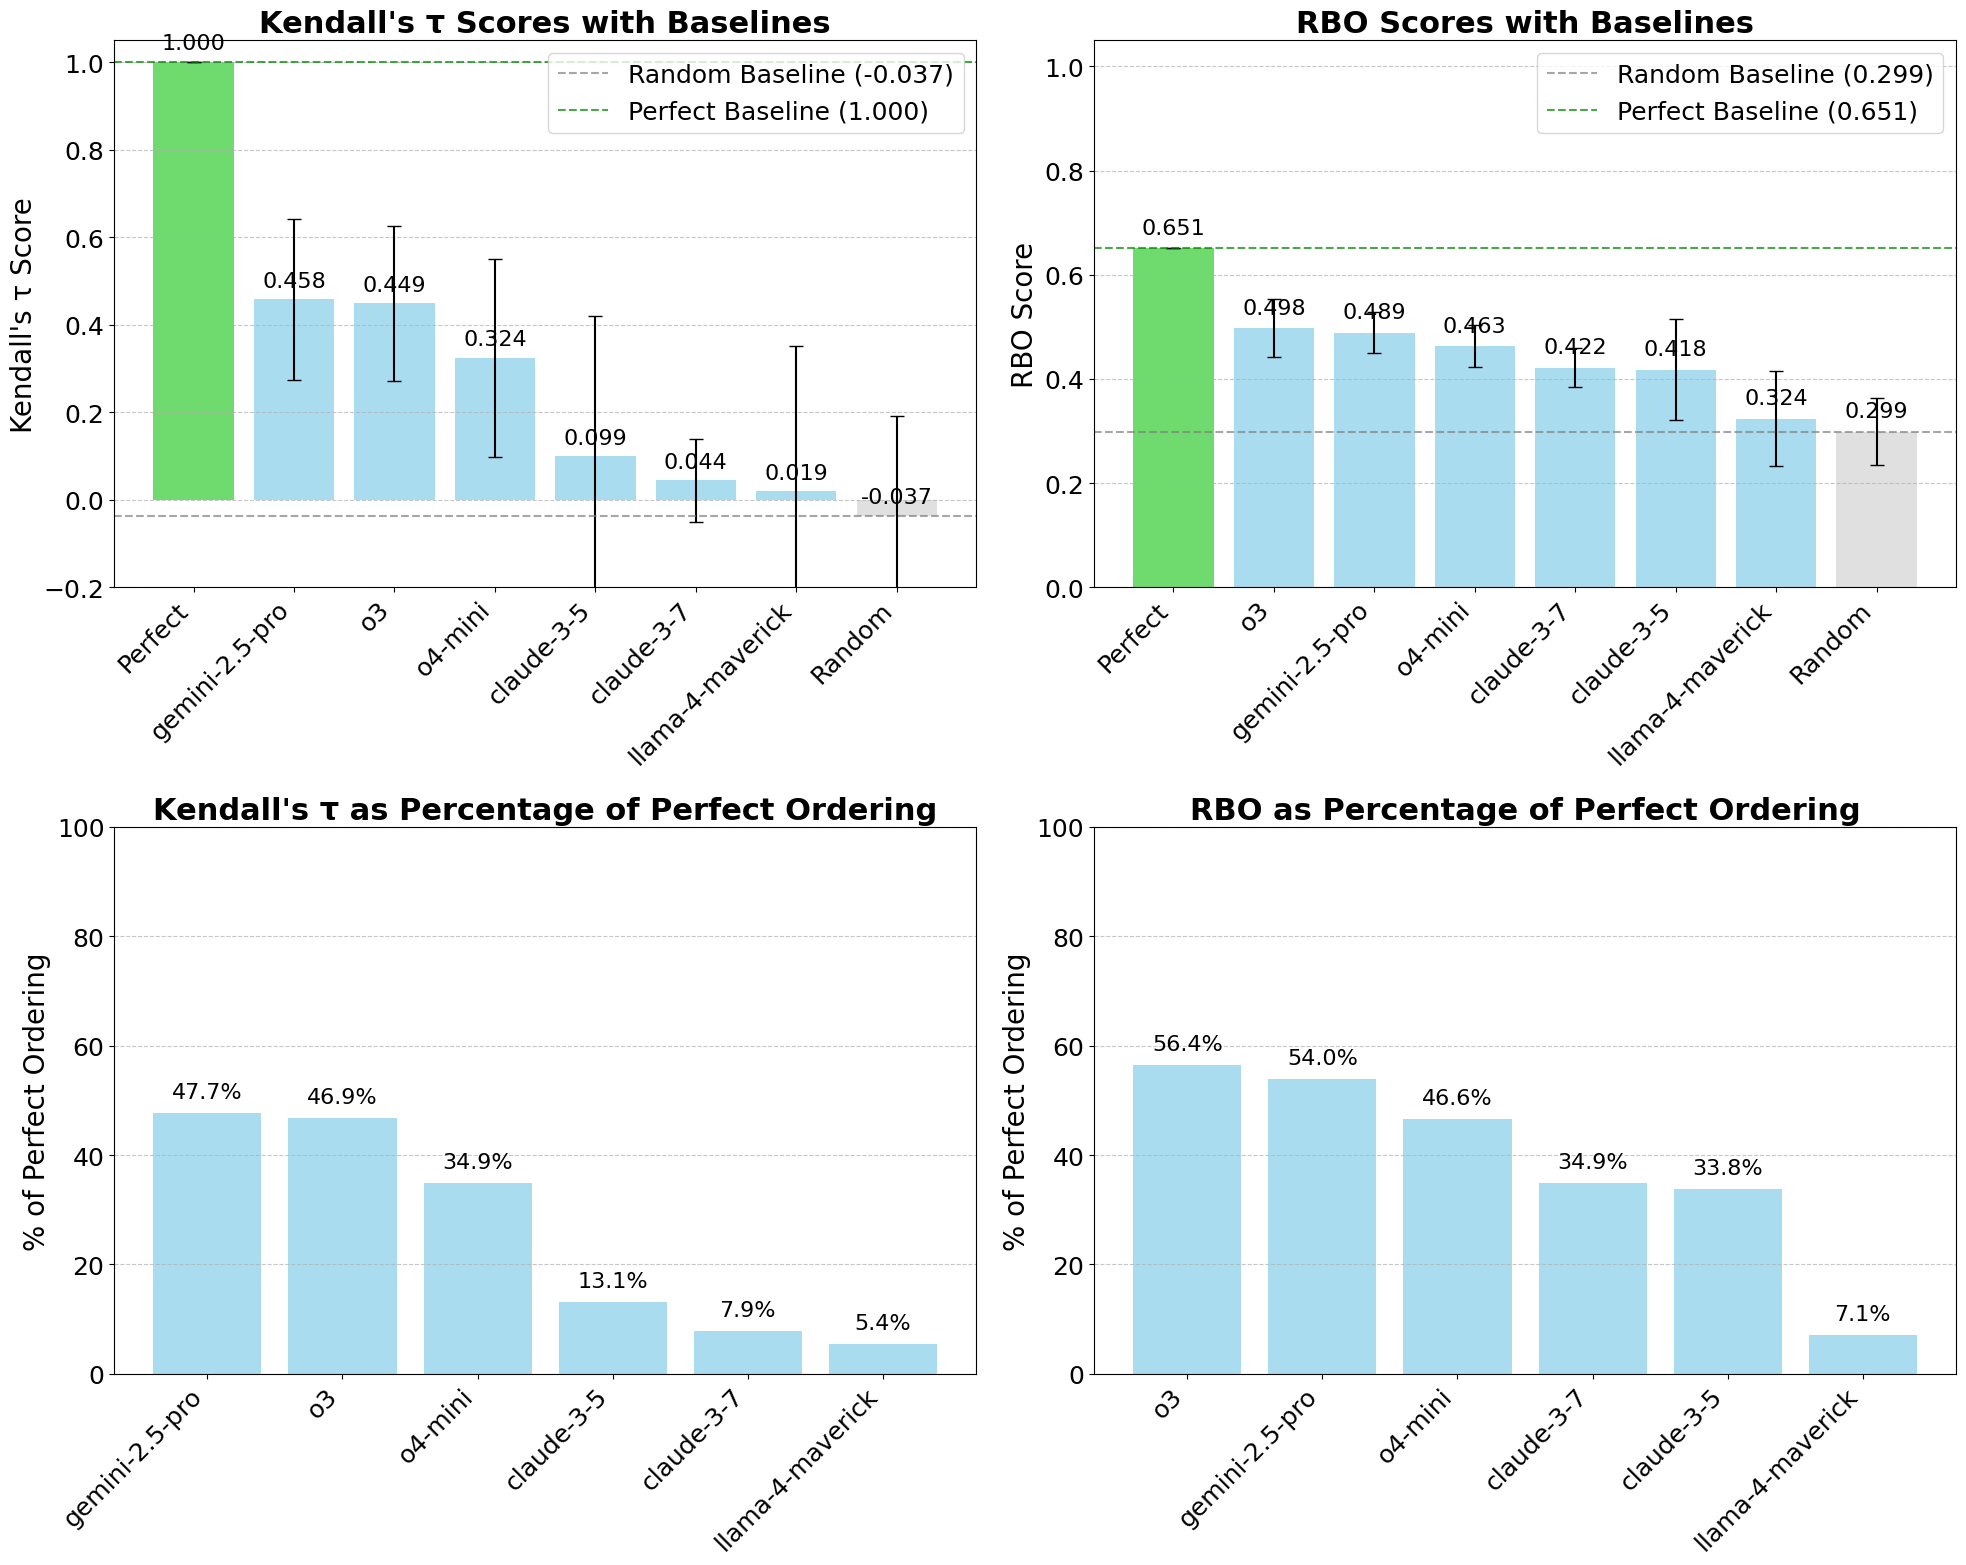

Paper-quality combined plot saved to: combined_plots_paper.png


(                                    Model  Mean Kendall's τ  Std Kendall's τ  \
 6                        Perfect_Baseline          1.000000         0.000000   
 2            gemini-2.5-pro-preview-03-25          0.457778         0.183403   
 1                           o3-2025-04-16          0.448889         0.176823   
 0                      o4-mini-2025-04-16          0.324444         0.226124   
 5              claude-3-5-sonnet-20241022          0.099259         0.319818   
 3              claude-3-7-sonnet-20250219          0.044444         0.095397   
 4  Llama-4-Maverick-17B-128E-Instruct-FP8          0.019259         0.332790   
 7                         Random_Baseline         -0.037037         0.229510   
 
                                           Raw Values  Improvement_Over_Random  \
 6  ['1.0000', '1.0000', '1.0000', '1.0000', '1.00...                 1.037037   
 2  ['0.6444', '0.2444', '0.2444', '0.3333', '0.42...                 0.494815   
 1  ['0.6000', '0.6889'

In [3]:
# Bar plot visualization
def create_paper_quality_plots(tau_vals, rbo_vals, all_models, save_path='combined_plots_paper.png'):
    """
    Create paper-quality plots with four subplots: 
    1. Kendall's tau bar chart
    2. RBO bar chart
    3. Kendall's tau normalized performance
    4. RBO normalized performance
    
    Parameters:
    -----------
    tau_vals : dict
        Dictionary mapping model names to lists of tau values
    rbo_vals : dict
        Dictionary mapping model names to lists of rbo values
    all_models : list
        List of model names including baselines
    save_path : str
        Path to save the combined figure
    
    Returns:
    --------
    tuple: (tau_df, rbo_df)
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    import matplotlib.gridspec as gridspec
    
    # Set larger font sizes for paper-quality figures
    plt.rcParams.update({
        'font.size': 18,          # Base font size
        'axes.titlesize': 22,     # Title font size
        'axes.labelsize': 20,     # Axis label size
        'xtick.labelsize': 18,    # X tick label size
        'ytick.labelsize': 18,    # Y tick label size
        'legend.fontsize': 18,    # Legend font size
        'figure.titlesize': 24    # Figure title size
    })
    
    # Create a figure with 2x2 subplots
    fig = plt.figure(figsize=(20, 16))
    gs = gridspec.GridSpec(2, 2, figure=fig)
    
    # Process Kendall's tau data
    tau_results = []
    for m in all_models:
        if m in tau_vals and tau_vals[m]:
            tau_results.append({
                'Model': m,
                'Mean Kendall\'s τ': np.mean(tau_vals[m]),
                'Std Kendall\'s τ': np.std(tau_vals[m], ddof=1),
                'Raw Values': str([f"{val:.4f}" for val in tau_vals[m]])
            })
    
    tau_df = pd.DataFrame(tau_results)
    tau_df = tau_df.sort_values('Mean Kendall\'s τ', ascending=False)
    
    # Process RBO data
    rbo_results = []
    for m in all_models:
        if m in rbo_vals and rbo_vals[m]:
            rbo_results.append({
                'Model': m,
                'Mean RBO': np.mean(rbo_vals[m]),
                'Std RBO': np.std(rbo_vals[m], ddof=1),
                'Raw Values': str([f"{val:.4f}" for val in rbo_vals[m]])
            })
    
    rbo_df = pd.DataFrame(rbo_results)
    rbo_df = rbo_df.sort_values('Mean RBO', ascending=False)
    
    # Define shortened model names
    def get_short_name(model):
        if model == 'Random_Baseline':
            return 'Random'
        elif model == 'Perfect_Baseline':
            return 'Perfect'
        elif "o3-2025-04-16" in model:
            return "o3"
        elif "claude-3-7" in model:
            return "claude-3-7"
        elif "claude-3-5" in model:
            return "claude-3-5"
        elif "o4-mini" in model:
            return "o4-mini"
        elif "gemini-2.5-pro" in model:
            return "gemini-2.5-pro"
        elif "Llama-4-Maverick" in model:
            return "llama-4-maverick"
        else:
            # Fallback for any other models
            if "claude" in model.lower():
                return f"claude-{model.split('-')[2]}"
            elif "llama" in model.lower():
                return "llama-4"
            elif "o4" in model.lower():
                return "o4-mini"
            elif "o3" in model.lower():
                return "o3"
            elif "gemini" in model.lower():
                return "gemini"
            else:
                return model.split('-')[0]
    
    # 1. Kendall's tau bar chart
    ax1 = fig.add_subplot(gs[0, 0])
    x = np.arange(len(tau_df))
    colors = []
    
    for model in tau_df['Model']:
        if model == 'Random_Baseline':
            colors.append('lightgray')
        elif model == 'Perfect_Baseline':
            colors.append('limegreen')
        else:
            colors.append('skyblue')
    
    bars = ax1.bar(x, tau_df['Mean Kendall\'s τ'], yerr=tau_df['Std Kendall\'s τ'], 
                   alpha=0.7, capsize=5, color=colors)
    
    short_names = [get_short_name(model) for model in tau_df['Model']]
    ax1.set_xticks(x)
    ax1.set_xticklabels(short_names, rotation=45, ha='right')
    ax1.set_title('Kendall\'s τ Scores with Baselines', fontsize=22, fontweight='bold')
    ax1.set_ylabel('Kendall\'s τ Score', fontsize=20)
    ax1.set_ylim(-0.2, 1.05)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{height:.3f}', ha='center', va='bottom', fontsize=16)
    
    random_tau_val = tau_df[tau_df['Model'] == 'Random_Baseline']['Mean Kendall\'s τ'].values[0]
    perfect_tau_val = tau_df[tau_df['Model'] == 'Perfect_Baseline']['Mean Kendall\'s τ'].values[0]
    
    ax1.axhline(y=random_tau_val, color='gray', linestyle='--', alpha=0.7, 
                label=f'Random Baseline ({random_tau_val:.3f})')
    ax1.axhline(y=perfect_tau_val, color='green', linestyle='--', alpha=0.7,
                label=f'Perfect Baseline ({perfect_tau_val:.3f})')
    
    ax1.legend(loc='upper right')
    
    # Calculate improvement metrics for Kendall's tau
    tau_df['Improvement_Over_Random'] = tau_df['Mean Kendall\'s τ'] - random_tau_val
    tau_df['Percent_Of_Perfect'] = (tau_df['Mean Kendall\'s τ'] - random_tau_val) / (perfect_tau_val - random_tau_val) * 100
    
    # 2. RBO bar chart
    ax2 = fig.add_subplot(gs[0, 1])
    x = np.arange(len(rbo_df))
    colors = []
    
    for model in rbo_df['Model']:
        if model == 'Random_Baseline':
            colors.append('lightgray')
        elif model == 'Perfect_Baseline':
            colors.append('limegreen')
        else:
            colors.append('skyblue')
    
    bars = ax2.bar(x, rbo_df['Mean RBO'], yerr=rbo_df['Std RBO'], 
                   alpha=0.7, capsize=5, color=colors)
    
    short_names = [get_short_name(model) for model in rbo_df['Model']]
    ax2.set_xticks(x)
    ax2.set_xticklabels(short_names, rotation=45, ha='right')
    ax2.set_title('RBO Scores with Baselines', fontsize=22, fontweight='bold')
    ax2.set_ylabel('RBO Score', fontsize=20)
    ax2.set_ylim(0, 1.05)
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{height:.3f}', ha='center', va='bottom', fontsize=16)
    
    random_rbo_val = rbo_df[rbo_df['Model'] == 'Random_Baseline']['Mean RBO'].values[0]
    perfect_rbo_val = rbo_df[rbo_df['Model'] == 'Perfect_Baseline']['Mean RBO'].values[0]
    
    ax2.axhline(y=random_rbo_val, color='gray', linestyle='--', alpha=0.7, 
                label=f'Random Baseline ({random_rbo_val:.3f})')
    ax2.axhline(y=perfect_rbo_val, color='green', linestyle='--', alpha=0.7,
                label=f'Perfect Baseline ({perfect_rbo_val:.3f})')
    
    ax2.legend(loc='upper right')
    
    # Calculate improvement metrics for RBO
    rbo_df['Improvement_Over_Random'] = rbo_df['Mean RBO'] - random_rbo_val
    rbo_df['Percent_Of_Perfect'] = (rbo_df['Mean RBO'] - random_rbo_val) / (perfect_rbo_val - random_rbo_val) * 100
    
    # 3. Kendall's tau normalized performance
    ax3 = fig.add_subplot(gs[1, 0])
    model_df_tau = tau_df[~tau_df['Model'].isin(['Random_Baseline', 'Perfect_Baseline'])]
    model_df_tau = model_df_tau.sort_values('Percent_Of_Perfect', ascending=False)
    
    x = np.arange(len(model_df_tau))
    bars = ax3.bar(x, model_df_tau['Percent_Of_Perfect'], alpha=0.7, color='skyblue')
    
    short_names = [get_short_name(model) for model in model_df_tau['Model']]
    ax3.set_xticks(x)
    ax3.set_xticklabels(short_names, rotation=45, ha='right')
    ax3.set_title('Kendall\'s τ as Percentage of Perfect Ordering', fontsize=22, fontweight='bold')
    ax3.set_ylabel('% of Perfect Ordering', fontsize=20)
    ax3.set_ylim(0, 100)
    ax3.grid(axis='y', linestyle='--', alpha=0.7)
    
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 2,
                 f'{height:.1f}%', ha='center', va='bottom', fontsize=16)
    
    # 4. RBO normalized performance
    ax4 = fig.add_subplot(gs[1, 1])
    model_df_rbo = rbo_df[~rbo_df['Model'].isin(['Random_Baseline', 'Perfect_Baseline'])]
    model_df_rbo = model_df_rbo.sort_values('Percent_Of_Perfect', ascending=False)
    
    x = np.arange(len(model_df_rbo))
    bars = ax4.bar(x, model_df_rbo['Percent_Of_Perfect'], alpha=0.7, color='skyblue')
    
    short_names = [get_short_name(model) for model in model_df_rbo['Model']]
    ax4.set_xticks(x)
    ax4.set_xticklabels(short_names, rotation=45, ha='right')
    ax4.set_title('RBO as Percentage of Perfect Ordering', fontsize=22, fontweight='bold')
    ax4.set_ylabel('% of Perfect Ordering', fontsize=20)
    ax4.set_ylim(0, 100)
    ax4.grid(axis='y', linestyle='--', alpha=0.7)
    
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 2,
                 f'{height:.1f}%', ha='center', va='bottom', fontsize=16)
    
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.show()
    
    print(f"Paper-quality combined plot saved to: {save_path}")
    
    # Save data to CSV
    tau_df.to_csv('kendall_tau_results_paper.csv', index=False)
    rbo_df.to_csv('rbo_results_paper.csv', index=False)
    
    return tau_df, rbo_df

create_paper_quality_plots(tau_vals, rbo_vals, all_models)

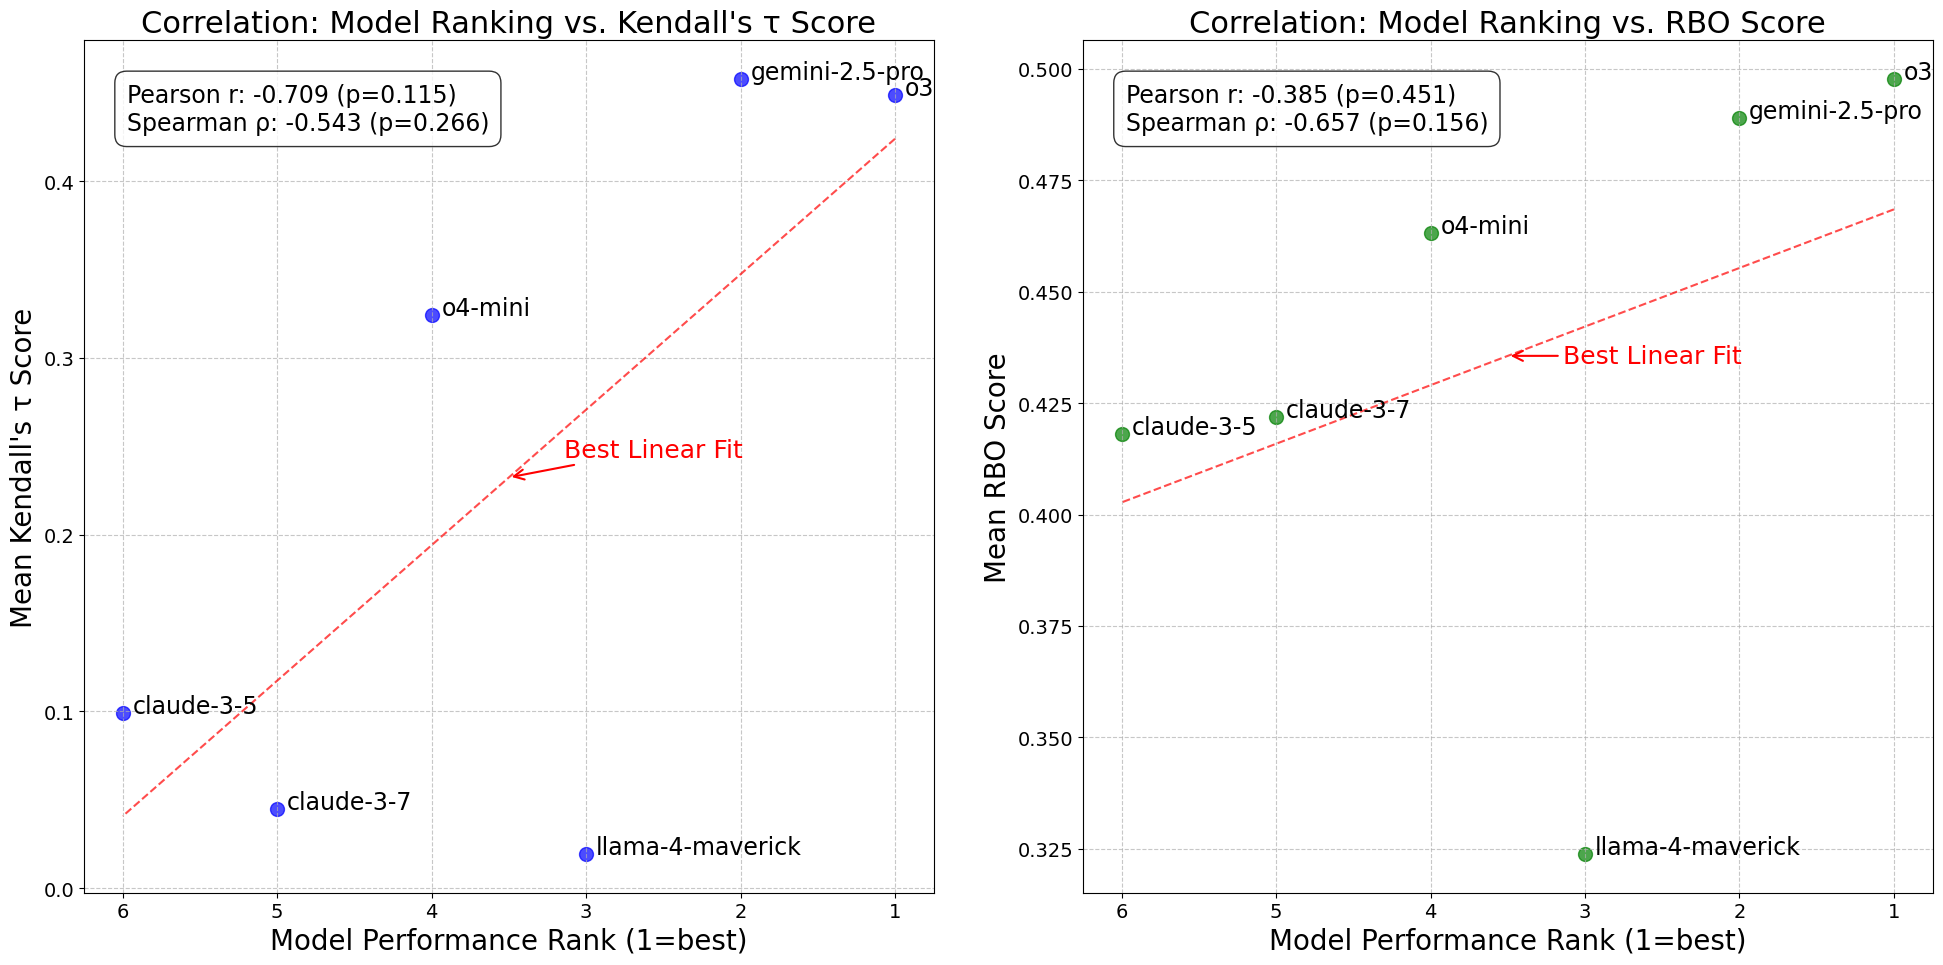


Correlation results:
Kendall's τ vs Rank (Pearson): r=-0.7089, p=0.1148
Kendall's τ vs Rank (Spearman): ρ=-0.5429, p=0.2657
RBO vs Rank (Pearson): r=-0.3847, p=0.4515
RBO vs Rank (Spearman): ρ=-0.6571, p=0.1562
Kendall's τ vs RBO: r=0.8772, p=0.0217


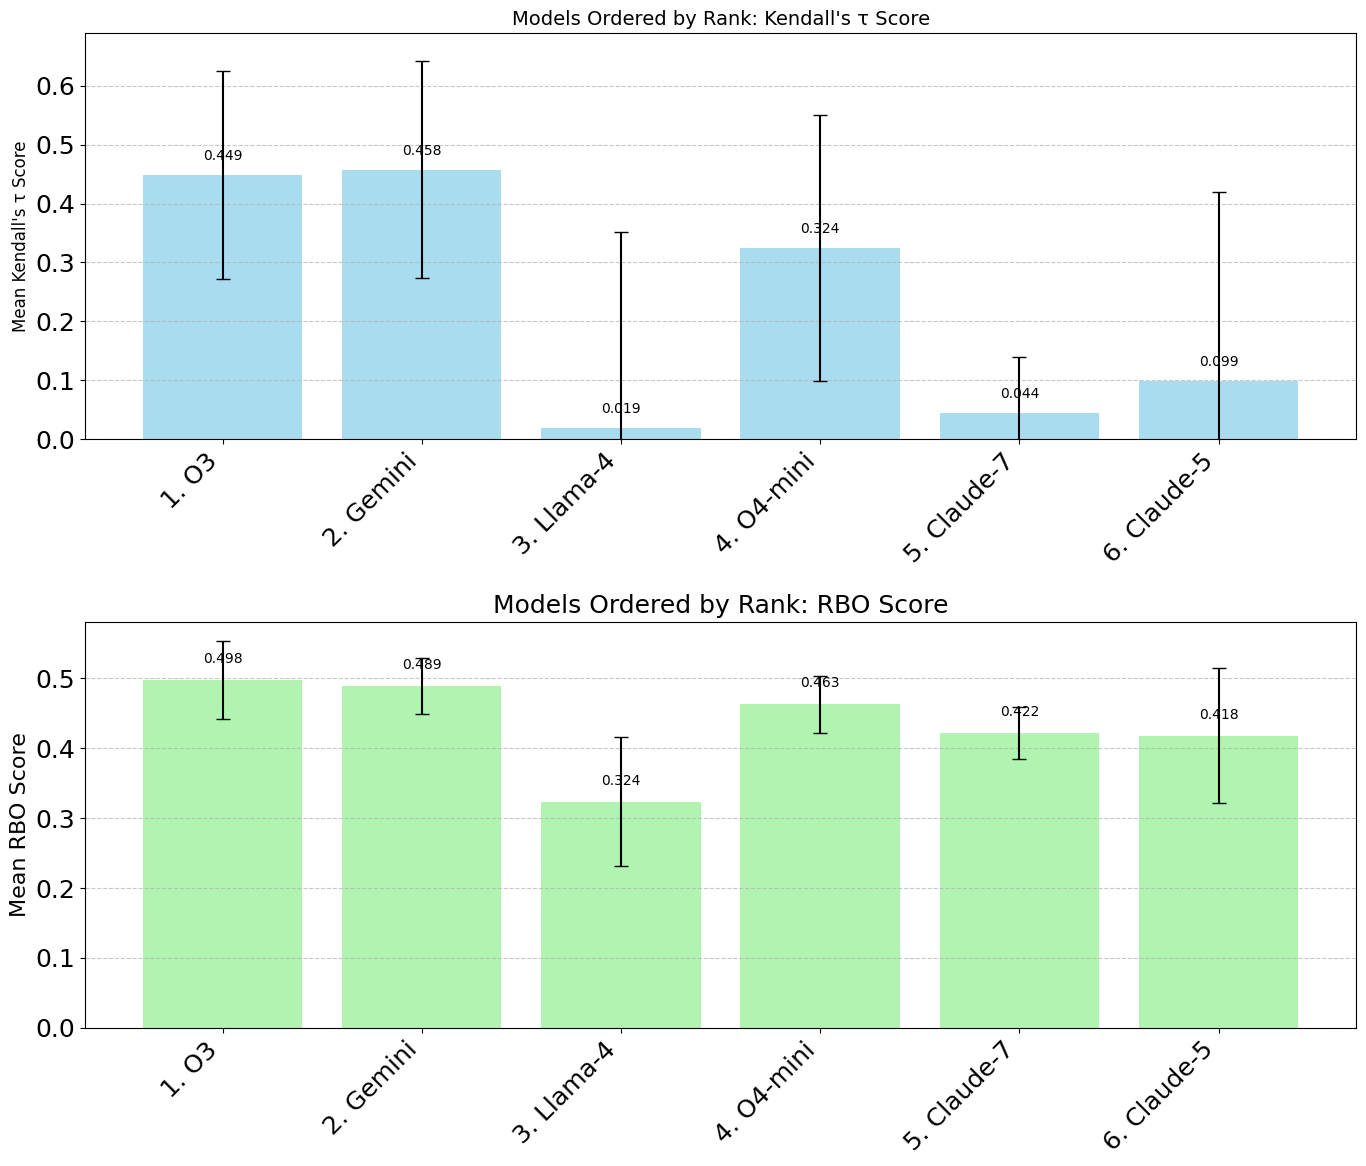


Rank-ordered bar charts saved to rank_ordered_metric_bar_charts.png


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
def plot_ordered_bar_charts(tau_vals, rbo_vals, all_models, model_ranking):
    """
    Create bar charts showing tau and RBO values ordered by model ranking.
    
    Parameters:
    -----------
    tau_vals : dict
        Dictionary mapping model names to lists of tau values
    rbo_vals : dict
        Dictionary mapping model names to lists of rbo values
    all_models : list
        List of all model names
    model_ranking : dict
        Dictionary mapping model names to their ranks (lower is better)
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Filter out baselines if desired
    real_models = [m for m in all_models if m not in ['Random_Baseline', 'Perfect_Baseline']]
    
    # Create DataFrames for metrics
    tau_df = pd.DataFrame({
        'Model': real_models,
        'Mean τ': [np.mean(tau_vals[m]) for m in real_models],
        'Std τ': [np.std(tau_vals[m], ddof=1) for m in real_models]
    })
    
    rbo_df = pd.DataFrame({
        'Model': real_models,
        'Mean RBO': [np.mean(rbo_vals[m]) for m in real_models],
        'Std RBO': [np.std(rbo_vals[m], ddof=1) for m in real_models]
    })
    
    # Add rank information
    tau_df['Rank'] = tau_df['Model'].map(model_ranking)
    rbo_df['Rank'] = rbo_df['Model'].map(model_ranking)
    
    # Sort by rank (ascending) instead of by metric values
    tau_df = tau_df.sort_values('Rank')
    rbo_df = rbo_df.sort_values('Rank')
    
    # Create a figure with two subplots
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))
    
    # 1. Tau bar chart
    x = np.arange(len(tau_df))
    bars = axes[0].bar(x, tau_df['Mean τ'], yerr=tau_df['Std τ'], 
                     alpha=0.7, capsize=5, color='skyblue')
    
    # Add value labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{height:.3f}', ha='center', va='bottom', fontsize=10)
    
    # Customize x-ticks with shortened model names
    short_names = []
    for model in tau_df['Model']:
        if "claude" in model.lower():
            short_names.append(f"Claude-{model.split('-')[2]}")
        elif "llama" in model.lower():
            short_names.append("Llama-4")
        elif "o4" in model.lower():
            short_names.append("O4-mini")
        elif "o3" in model.lower():
            short_names.append("O3")
        elif "gemini" in model.lower():
            short_names.append("Gemini")
        else:
            short_names.append(model.split('-')[0])
    
    # Add rank to labels
    x_labels = [f"{tau_df['Rank'].iloc[i]}. {name}" for i, name in enumerate(short_names)]
    
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(x_labels, rotation=45, ha='right')
    axes[0].set_title("Models Ordered by Rank: Kendall's τ Score", fontsize=14)
    axes[0].set_ylabel("Mean Kendall's τ Score", fontsize=12)
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)
    axes[0].set_ylim(bottom=0)  # Start y-axis from 0
    
    # 2. RBO bar chart
    x = np.arange(len(rbo_df))
    bars = axes[1].bar(x, rbo_df['Mean RBO'], yerr=rbo_df['Std RBO'], 
                     alpha=0.7, capsize=5, color='lightgreen')
    
    # Add value labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{height:.3f}', ha='center', va='bottom', fontsize=10)
    
    # Customize x-ticks with shortened model names
    short_names = []
    for model in rbo_df['Model']:
        if "claude" in model.lower():
            short_names.append(f"Claude-{model.split('-')[2]}")
        elif "llama" in model.lower():
            short_names.append("Llama-4")
        elif "o4" in model.lower():
            short_names.append("O4-mini")
        elif "o3" in model.lower():
            short_names.append("O3")
        elif "gemini" in model.lower():
            short_names.append("Gemini")
        else:
            short_names.append(model.split('-')[0])
    
    # Add rank to labels
    x_labels = [f"{rbo_df['Rank'].iloc[i]}. {name}" for i, name in enumerate(short_names)]
    
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(x_labels, rotation=45, ha='right')
    axes[1].set_title("Models Ordered by Rank: RBO Score", fontsize=18)
    axes[1].set_ylabel("Mean RBO Score", fontsize=16)
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)
    axes[1].set_ylim(bottom=0)  # Start y-axis from 0
    
    plt.tight_layout()
    plt.savefig('rank_ordered_metric_bar_charts.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nRank-ordered bar charts saved to rank_ordered_metric_bar_charts.png")
    
    return tau_df, rbo_df


def plot_pearson_correlations(tau_vals, rbo_vals, model_ranking):
    """
    Create correlation plots showing the relationship between metrics and model ranks.

    Parameters:
    -----------
    tau_vals : dict
        Dictionary mapping model names to lists of tau values
    rbo_vals : dict
        Dictionary mapping model names to lists of rbo values
    model_ranking : dict
        Dictionary mapping model names to their ranks (lower is better)
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import spearmanr, pearsonr # Ensure spearmanr is imported

    # Filter out baselines from metrics
    real_models = [m for m in tau_vals.keys() if m not in ['Random_Baseline', 'Perfect_Baseline']]

    # Create DataFrame with metrics and rankings
    df = pd.DataFrame({
        'Model': real_models,
        'MeanTau': [np.mean(tau_vals[m]) for m in real_models],
        'StdTau': [np.std(tau_vals[m], ddof=1) for m in real_models],
        'MeanRBO': [np.mean(rbo_vals[m]) for m in real_models],
        'StdRBO': [np.std(rbo_vals[m], ddof=1) for m in real_models]
    })

    # Add ranking information
    df['Rank'] = df['Model'].map(model_ranking)

    # Sort by rank for display
    df = df.sort_values('Rank')

    # Calculate correlations
    rank_values = df['Rank'].values
    tau_values = df['MeanTau'].values
    rbo_values = df['MeanRBO'].values

    # Tau correlations
    tau_spearman, tau_spearman_p = spearmanr(rank_values, tau_values)
    tau_pearson, tau_pearson_p = pearsonr(rank_values, tau_values)

    # RBO correlations
    rbo_spearman, rbo_spearman_p = spearmanr(rank_values, rbo_values)
    rbo_pearson, rbo_pearson_p = pearsonr(rank_values, rbo_values)

    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(20, 10)) # Increased figure size slightly more

    # --- Tau vs Rank subplot ---
    axes[0].scatter(rank_values, tau_values, s=100, alpha=0.7, c='blue')

    # Add model names as labels with updated shortening logic
    for i, model in enumerate(df['Model']):
        short_name = ""
        if "o4-mini" in model.lower():
            short_name = "o4-mini"
        elif "gemini-2.5-pro" in model.lower(): # Assuming "2..5" was a typo for "2.5"
             short_name = "gemini-2.5-pro"
        elif "o3" in model.lower():
            short_name = "o3"
        elif "claude-3-7" in model.lower():
            short_name = "claude-3-7"
        elif "claude-3-5" in model.lower():
            short_name = "claude-3-5"
        elif "llama-4" in model.lower():
            short_name = "llama-4-maverick"
        else:
            # Fallback if name doesn't match known patterns
            short_name = model.split('-')[0] if '-' in model else model.split('_')[0]

        axes[0].annotate(short_name,
                     (rank_values[i], tau_values[i]),
                     xytext=(7, 0), # Offset text from the point
                     textcoords='offset points',
                     fontsize=17) # Increased font size

    # Add regression line
    z_tau = np.polyfit(rank_values, tau_values, 1)
    p_tau = np.poly1d(z_tau)
    x_fit_tau = np.linspace(min(rank_values), max(rank_values), 100)
    axes[0].plot(x_fit_tau, p_tau(x_fit_tau), "r--", alpha=0.7)

    # Annotate the regression line as "Best Linear Fit"
    annotate_rank_tau = min(rank_values) + (max(rank_values) - min(rank_values)) * 0.5
    annotate_tau_value = p_tau(annotate_rank_tau)
    axes[0].annotate('Best Linear Fit',
                     xy=(annotate_rank_tau, annotate_tau_value),
                     xytext=(40, 15), # Further adjusted offset
                     textcoords='offset points',
                     fontsize=18, # Increased font size
                     color='red',
                     arrowprops=dict(arrowstyle="->", color='red', lw=1.5))


    # Add correlation statistics to the top right
    axes[0].text(0.05, 0.95,
                 f"Pearson r: {tau_pearson:.3f} (p={tau_pearson_p:.3f})\nSpearman ρ: {tau_spearman:.3f} (p={tau_spearman_p:.3f})",
                 transform=axes[0].transAxes,
                 horizontalalignment='left',
                 verticalalignment='top', # Changed to top
                 bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'),
                 fontsize=17)


    # Customize titles and labels with increased font size
    axes[0].set_title("Correlation: Model Ranking vs. Kendall's τ Score", fontsize=22) # Increased
    axes[0].set_xlabel("Model Performance Rank (1=best)", fontsize=20) # Increased
    axes[0].set_ylabel("Mean Kendall's τ Score", fontsize=20) # Increased

    # Increase tick label font size
    axes[0].tick_params(axis='both', which='major', labelsize=14) # Increased

    axes[0].grid(True, linestyle='--', alpha=0.7)
    axes[0].invert_xaxis()  # Invert x-axis so rank 1 is on the right (better)

    # --- RBO vs Rank subplot ---
    axes[1].scatter(rank_values, rbo_values, s=100, alpha=0.7, c='green')

    # Add model names as labels with updated shortening logic
    for i, model in enumerate(df['Model']):
        short_name = ""
        if "o4-mini" in model.lower():
            short_name = "o4-mini"
        elif "gemini-2.5-pro" in model.lower(): # Assuming "2..5" was a typo for "2.5"
             short_name = "gemini-2.5-pro"
        elif "o3" in model.lower():
            short_name = "o3"
        elif "claude-3-7" in model.lower():
            short_name = "claude-3-7"
        elif "claude-3-5" in model.lower():
            short_name = "claude-3-5"
        elif "llama-4" in model.lower():
            short_name = "llama-4-maverick"
        else:
            # Fallback if name doesn't match known patterns
            short_name = model.split('-')[0] if '-' in model else model.split('_')[0]

        axes[1].annotate(short_name,
                     (rank_values[i], rbo_values[i]),
                     xytext=(7, 0),
                     textcoords='offset points',
                     fontsize=17) # Increased font size

    # Add regression line
    z_rbo = np.polyfit(rank_values, rbo_values, 1)
    p_rbo = np.poly1d(z_rbo)
    x_fit_rbo = np.linspace(min(rank_values), max(rank_values), 100)
    axes[1].plot(x_fit_rbo, p_rbo(x_fit_rbo), "r--", alpha=0.7)

    # Annotate the regression line as "Best Linear Fit"
    annotate_rank_rbo = min(rank_values) + (max(rank_values) - min(rank_values)) * 0.5
    annotate_rbo_value = p_rbo(annotate_rank_rbo)
    axes[1].annotate('Best Linear Fit',
                     xy=(annotate_rank_rbo, annotate_rbo_value),
                     xytext=(40, -5), # Further adjusted offset
                     textcoords='offset points',
                     fontsize=18, # Increased font size
                     color='red',
                     arrowprops=dict(arrowstyle="->", color='red', lw=1.5))


    # Add correlation statistics to the top right
    axes[1].text(0.05, 0.95,
                 f"Pearson r: {rbo_pearson:.3f} (p={rbo_pearson_p:.3f})\nSpearman ρ: {rbo_spearman:.3f} (p={rbo_spearman_p:.3f})",
                 transform=axes[1].transAxes,
                 horizontalalignment='left',
                 verticalalignment='top', # Changed to top
                 bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'),
                 fontsize=17)

    # Customize titles and labels with increased font size
    axes[1].set_title("Correlation: Model Ranking vs. RBO Score", fontsize=22) # Increased
    axes[1].set_xlabel("Model Performance Rank (1=best)", fontsize=20) # Increased
    axes[1].set_ylabel("Mean RBO Score", fontsize=20) # Increased

    # Increase tick label font size
    axes[1].tick_params(axis='both', which='major', labelsize=14) # Increased


    axes[1].grid(True, linestyle='--', alpha=0.7)
    axes[1].invert_xaxis()  # Invert x-axis so rank 1 is on the right

    plt.tight_layout()
    plt.savefig('pearson_correlation_plots_enhanced.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nCorrelation results:")
    print(f"Kendall's τ vs Rank (Pearson): r={tau_pearson:.4f}, p={tau_pearson_p:.4f}")
    print(f"Kendall's τ vs Rank (Spearman): ρ={tau_spearman:.4f}, p={tau_spearman_p:.4f}") # Added Spearman
    print(f"RBO vs Rank (Pearson): r={rbo_pearson:.4f}, p={rbo_pearson_p:.4f}")
    print(f"RBO vs Rank (Spearman): ρ={rbo_spearman:.4f}, p={rbo_spearman_p:.4f}") # Added Spearman

    # Calculate correlation between metrics
    tau_rbo_corr, tau_rbo_p = pearsonr(tau_values, rbo_values)
    print(f"Kendall's τ vs RBO: r={tau_rbo_corr:.4f}, p={tau_rbo_p:.4f}")

    return df

# Example usage:
# After calculating tau_vals and rbo_vals

# Define model ranking
model_ranking = {
    "o3-2025-04-16": 1,  # O3 is ranked 1st
    "gemini-2.5-pro-preview-03-25": 2,  # Gemini is ranked 2nd
    "claude-3-5-sonnet-20241022": 6,  # Claude-3-5 is ranked 3rd
    "claude-3-7-sonnet-20250219": 5,  # Claude-3-7 is ranked 4th
    "o4-mini-2025-04-16": 4,  # O4-mini is ranked 5th
    "Llama-4-Maverick-17B-128E-Instruct-FP8": 3  # Llama is ranked 6th
}

# Create correlation plots
correlation_df = plot_pearson_correlations(tau_vals, rbo_vals, model_ranking)

# Create ordered bar charts by model rank
tau_ordered_df, rbo_ordered_df = plot_ordered_bar_charts(tau_vals, rbo_vals, all_models, model_ranking)

In [ ]:
import random

# Define the ground truth
ground_truth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
num_samples = len(ground_truth)
num_runs = 15
accuracies = []

# Range of values for random sampling (1 to 10 based on ground_truth values)
min_value = min(ground_truth)
max_value = max(ground_truth)

# Set the seed *outside* the loop for reproducibility of the entire sequence
random.seed(42)

for run_num in range(num_runs):
    # Generate random samples of the same length as ground_truth
    # Since the seed is set outside the loop, each iteration will produce a different sequence
    random_samples = [random.randint(min_value, max_value) for _ in range(num_samples)]

    # Calculate position-wise accuracy
    correct_predictions = sum(1 for gt, rs in zip(ground_truth, random_samples) if gt == rs)
    accuracy = correct_predictions / num_samples if num_samples > 0 else 0
    accuracies.append(accuracy)

    print(f"Run {run_num + 1}: Random Samples: {random_samples}, Accuracy: {accuracy:.2f}")


# Calculate the average accuracy
average_accuracy = sum(accuracies) / num_runs if num_runs > 0 else 0

print(f"\nGround Truth: {ground_truth}")
print(f"Number of runs: {num_runs}")
print(f"All individual accuracies: {accuracies}")
print(f"Average position-wise accuracy over {num_runs} runs: {average_accuracy:.2f}")

Run 1: Random Samples: [2, 1, 5, 4, 4, 3, 2, 9, 2, 10], Accuracy: 0.20
Run 2: Random Samples: [7, 1, 1, 2, 4, 4, 9, 10, 1, 9], Accuracy: 0.00
Run 3: Random Samples: [4, 9, 7, 4, 8, 10, 5, 1, 3, 7], Accuracy: 0.10
Run 4: Random Samples: [6, 5, 3, 4, 6, 2, 2, 7, 2, 6], Accuracy: 0.20
Run 5: Random Samples: [6, 10, 5, 1, 8, 9, 2, 7, 2, 9], Accuracy: 0.00
Run 6: Random Samples: [5, 10, 6, 10, 4, 2, 1, 4, 5, 2], Accuracy: 0.00
Run 7: Random Samples: [4, 2, 7, 5, 8, 6, 3, 6, 6, 4], Accuracy: 0.20
Run 8: Random Samples: [5, 2, 10, 3, 9, 4, 3, 8, 7, 5], Accuracy: 0.20
Run 9: Random Samples: [9, 4, 6, 1, 4, 1, 6, 7, 5, 2], Accuracy: 0.00
Run 10: Random Samples: [4, 10, 6, 4, 8, 7, 8, 3, 5, 3], Accuracy: 0.10
Run 11: Random Samples: [4, 9, 9, 5, 10, 7, 10, 7, 6, 4], Accuracy: 0.00
Run 12: Random Samples: [3, 9, 8, 2, 1, 2, 3, 3, 7, 10], Accuracy: 0.10
Run 13: Random Samples: [2, 7, 7, 10, 8, 9, 5, 9, 1, 2], Accuracy: 0.00
Run 14: Random Samples: [9, 5, 6, 2, 5, 7, 3, 8, 1, 5], Accuracy: 0.20
Run

In [ ]:
import random

# Define the ground truth
ground_truth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
num_samples = len(ground_truth)
num_runs = 15
accuracies = []

# Range of values for random sampling (1 to 10 based on ground_truth values)
min_value = min(ground_truth)
max_value = max(ground_truth)

# Set the seed *outside* the loop for reproducibility of the entire sequence
random.seed(42)

for run_num in range(num_runs):
    # Generate random samples of the same length as ground_truth
    # Since the seed is set outside the loop, each iteration will produce a different sequence
    random_samples = [random.randint(min_value, max_value) for _ in range(num_samples)]

    # Calculate position-wise accuracy
    correct_predictions = sum(1 for gt, rs in zip(ground_truth, random_samples) if gt == rs)
    accuracy = correct_predictions / num_samples if num_samples > 0 else 0
    accuracies.append(accuracy)

    print(f"Run {run_num + 1}: Random Samples: {random_samples}, Accuracy: {accuracy:.2f}")


# Calculate the average accuracy
average_accuracy = sum(accuracies) / num_runs if num_runs > 0 else 0

print(f"\nGround Truth: {ground_truth}")
print(f"Number of runs: {num_runs}")
print(f"All individual accuracies: {accuracies}")
print(f"Average position-wise accuracy over {num_runs} runs: {average_accuracy:.2f}")

Run 1: Random Samples: [2, 1, 5, 4, 4, 3, 2, 9, 2, 10], Accuracy: 0.20
Run 2: Random Samples: [7, 1, 1, 2, 4, 4, 9, 10, 1, 9], Accuracy: 0.00
Run 3: Random Samples: [4, 9, 7, 4, 8, 10, 5, 1, 3, 7], Accuracy: 0.10
Run 4: Random Samples: [6, 5, 3, 4, 6, 2, 2, 7, 2, 6], Accuracy: 0.20
Run 5: Random Samples: [6, 10, 5, 1, 8, 9, 2, 7, 2, 9], Accuracy: 0.00
Run 6: Random Samples: [5, 10, 6, 10, 4, 2, 1, 4, 5, 2], Accuracy: 0.00
Run 7: Random Samples: [4, 2, 7, 5, 8, 6, 3, 6, 6, 4], Accuracy: 0.20
Run 8: Random Samples: [5, 2, 10, 3, 9, 4, 3, 8, 7, 5], Accuracy: 0.20
Run 9: Random Samples: [9, 4, 6, 1, 4, 1, 6, 7, 5, 2], Accuracy: 0.00
Run 10: Random Samples: [4, 10, 6, 4, 8, 7, 8, 3, 5, 3], Accuracy: 0.10
Run 11: Random Samples: [4, 9, 9, 5, 10, 7, 10, 7, 6, 4], Accuracy: 0.00
Run 12: Random Samples: [3, 9, 8, 2, 1, 2, 3, 3, 7, 10], Accuracy: 0.10
Run 13: Random Samples: [2, 7, 7, 10, 8, 9, 5, 9, 1, 2], Accuracy: 0.00
Run 14: Random Samples: [9, 5, 6, 2, 5, 7, 3, 8, 1, 5], Accuracy: 0.20
Run

In [ ]:
import random

# Define the ground truth
ground_truth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
num_samples = len(ground_truth)
num_runs = 15
accuracies = []

# Range of values for random sampling (1 to 10 based on ground_truth values)
min_value = min(ground_truth)
max_value = max(ground_truth)

# Set the seed *outside* the loop for reproducibility of the entire sequence
random.seed(42)

for run_num in range(num_runs):
    # Generate random samples of the same length as ground_truth
    # Since the seed is set outside the loop, each iteration will produce a different sequence
    random_samples = [random.randint(min_value, max_value) for _ in range(num_samples)]

    # Calculate position-wise accuracy
    correct_predictions = sum(1 for gt, rs in zip(ground_truth, random_samples) if gt == rs)
    accuracy = correct_predictions / num_samples if num_samples > 0 else 0
    accuracies.append(accuracy)

    print(f"Run {run_num + 1}: Random Samples: {random_samples}, Accuracy: {accuracy:.2f}")


# Calculate the average accuracy
average_accuracy = sum(accuracies) / num_runs if num_runs > 0 else 0

print(f"\nGround Truth: {ground_truth}")
print(f"Number of runs: {num_runs}")
print(f"All individual accuracies: {accuracies}")
print(f"Average position-wise accuracy over {num_runs} runs: {average_accuracy:.2f}")

Run 1: Random Samples: [2, 1, 5, 4, 4, 3, 2, 9, 2, 10], Accuracy: 0.20
Run 2: Random Samples: [7, 1, 1, 2, 4, 4, 9, 10, 1, 9], Accuracy: 0.00
Run 3: Random Samples: [4, 9, 7, 4, 8, 10, 5, 1, 3, 7], Accuracy: 0.10
Run 4: Random Samples: [6, 5, 3, 4, 6, 2, 2, 7, 2, 6], Accuracy: 0.20
Run 5: Random Samples: [6, 10, 5, 1, 8, 9, 2, 7, 2, 9], Accuracy: 0.00
Run 6: Random Samples: [5, 10, 6, 10, 4, 2, 1, 4, 5, 2], Accuracy: 0.00
Run 7: Random Samples: [4, 2, 7, 5, 8, 6, 3, 6, 6, 4], Accuracy: 0.20
Run 8: Random Samples: [5, 2, 10, 3, 9, 4, 3, 8, 7, 5], Accuracy: 0.20
Run 9: Random Samples: [9, 4, 6, 1, 4, 1, 6, 7, 5, 2], Accuracy: 0.00
Run 10: Random Samples: [4, 10, 6, 4, 8, 7, 8, 3, 5, 3], Accuracy: 0.10
Run 11: Random Samples: [4, 9, 9, 5, 10, 7, 10, 7, 6, 4], Accuracy: 0.00
Run 12: Random Samples: [3, 9, 8, 2, 1, 2, 3, 3, 7, 10], Accuracy: 0.10
Run 13: Random Samples: [2, 7, 7, 10, 8, 9, 5, 9, 1, 2], Accuracy: 0.00
Run 14: Random Samples: [9, 5, 6, 2, 5, 7, 3, 8, 1, 5], Accuracy: 0.20
Run

In [ ]:
import random

# Define the ground truth
ground_truth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
num_samples = len(ground_truth)
num_runs = 15
accuracies = []

# Range of values for random sampling (1 to 10 based on ground_truth values)
min_value = min(ground_truth)
max_value = max(ground_truth)

# Set the seed *outside* the loop for reproducibility of the entire sequence
random.seed(42)

for run_num in range(num_runs):
    # Generate random samples of the same length as ground_truth
    # Since the seed is set outside the loop, each iteration will produce a different sequence
    random_samples = [random.randint(min_value, max_value) for _ in range(num_samples)]

    # Calculate position-wise accuracy
    correct_predictions = sum(1 for gt, rs in zip(ground_truth, random_samples) if gt == rs)
    accuracy = correct_predictions / num_samples if num_samples > 0 else 0
    accuracies.append(accuracy)

    print(f"Run {run_num + 1}: Random Samples: {random_samples}, Accuracy: {accuracy:.2f}")


# Calculate the average accuracy
average_accuracy = sum(accuracies) / num_runs if num_runs > 0 else 0

print(f"\nGround Truth: {ground_truth}")
print(f"Number of runs: {num_runs}")
print(f"All individual accuracies: {accuracies}")
print(f"Average position-wise accuracy over {num_runs} runs: {average_accuracy:.2f}")

Run 1: Random Samples: [2, 1, 5, 4, 4, 3, 2, 9, 2, 10], Accuracy: 0.20
Run 2: Random Samples: [7, 1, 1, 2, 4, 4, 9, 10, 1, 9], Accuracy: 0.00
Run 3: Random Samples: [4, 9, 7, 4, 8, 10, 5, 1, 3, 7], Accuracy: 0.10
Run 4: Random Samples: [6, 5, 3, 4, 6, 2, 2, 7, 2, 6], Accuracy: 0.20
Run 5: Random Samples: [6, 10, 5, 1, 8, 9, 2, 7, 2, 9], Accuracy: 0.00
Run 6: Random Samples: [5, 10, 6, 10, 4, 2, 1, 4, 5, 2], Accuracy: 0.00
Run 7: Random Samples: [4, 2, 7, 5, 8, 6, 3, 6, 6, 4], Accuracy: 0.20
Run 8: Random Samples: [5, 2, 10, 3, 9, 4, 3, 8, 7, 5], Accuracy: 0.20
Run 9: Random Samples: [9, 4, 6, 1, 4, 1, 6, 7, 5, 2], Accuracy: 0.00
Run 10: Random Samples: [4, 10, 6, 4, 8, 7, 8, 3, 5, 3], Accuracy: 0.10
Run 11: Random Samples: [4, 9, 9, 5, 10, 7, 10, 7, 6, 4], Accuracy: 0.00
Run 12: Random Samples: [3, 9, 8, 2, 1, 2, 3, 3, 7, 10], Accuracy: 0.10
Run 13: Random Samples: [2, 7, 7, 10, 8, 9, 5, 9, 1, 2], Accuracy: 0.00
Run 14: Random Samples: [9, 5, 6, 2, 5, 7, 3, 8, 1, 5], Accuracy: 0.20
Run

In [ ]:
import random

# Define the ground truth
ground_truth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
num_samples = len(ground_truth)
num_runs = 15
accuracies = []

# Range of values for random sampling (1 to 10 based on ground_truth values)
min_value = min(ground_truth)
max_value = max(ground_truth)

# Set the seed *outside* the loop for reproducibility of the entire sequence
random.seed(42)

for run_num in range(num_runs):
    # Generate random samples of the same length as ground_truth
    # Since the seed is set outside the loop, each iteration will produce a different sequence
    random_samples = [random.randint(min_value, max_value) for _ in range(num_samples)]

    # Calculate position-wise accuracy
    correct_predictions = sum(1 for gt, rs in zip(ground_truth, random_samples) if gt == rs)
    accuracy = correct_predictions / num_samples if num_samples > 0 else 0
    accuracies.append(accuracy)

    print(f"Run {run_num + 1}: Random Samples: {random_samples}, Accuracy: {accuracy:.2f}")


# Calculate the average accuracy
average_accuracy = sum(accuracies) / num_runs if num_runs > 0 else 0

print(f"\nGround Truth: {ground_truth}")
print(f"Number of runs: {num_runs}")
print(f"All individual accuracies: {accuracies}")
print(f"Average position-wise accuracy over {num_runs} runs: {average_accuracy:.2f}")

Run 1: Random Samples: [2, 1, 5, 4, 4, 3, 2, 9, 2, 10], Accuracy: 0.20
Run 2: Random Samples: [7, 1, 1, 2, 4, 4, 9, 10, 1, 9], Accuracy: 0.00
Run 3: Random Samples: [4, 9, 7, 4, 8, 10, 5, 1, 3, 7], Accuracy: 0.10
Run 4: Random Samples: [6, 5, 3, 4, 6, 2, 2, 7, 2, 6], Accuracy: 0.20
Run 5: Random Samples: [6, 10, 5, 1, 8, 9, 2, 7, 2, 9], Accuracy: 0.00
Run 6: Random Samples: [5, 10, 6, 10, 4, 2, 1, 4, 5, 2], Accuracy: 0.00
Run 7: Random Samples: [4, 2, 7, 5, 8, 6, 3, 6, 6, 4], Accuracy: 0.20
Run 8: Random Samples: [5, 2, 10, 3, 9, 4, 3, 8, 7, 5], Accuracy: 0.20
Run 9: Random Samples: [9, 4, 6, 1, 4, 1, 6, 7, 5, 2], Accuracy: 0.00
Run 10: Random Samples: [4, 10, 6, 4, 8, 7, 8, 3, 5, 3], Accuracy: 0.10
Run 11: Random Samples: [4, 9, 9, 5, 10, 7, 10, 7, 6, 4], Accuracy: 0.00
Run 12: Random Samples: [3, 9, 8, 2, 1, 2, 3, 3, 7, 10], Accuracy: 0.10
Run 13: Random Samples: [2, 7, 7, 10, 8, 9, 5, 9, 1, 2], Accuracy: 0.00
Run 14: Random Samples: [9, 5, 6, 2, 5, 7, 3, 8, 1, 5], Accuracy: 0.20
Run

In [ ]:
import random

# Define the ground truth
ground_truth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
num_samples = len(ground_truth)
num_runs = 15
accuracies = []

# Range of values for random sampling (1 to 10 based on ground_truth values)
min_value = min(ground_truth)
max_value = max(ground_truth)

# Set the seed *outside* the loop for reproducibility of the entire sequence
random.seed(42)

for run_num in range(num_runs):
    # Generate random samples of the same length as ground_truth
    # Since the seed is set outside the loop, each iteration will produce a different sequence
    random_samples = [random.randint(min_value, max_value) for _ in range(num_samples)]

    # Calculate position-wise accuracy
    correct_predictions = sum(1 for gt, rs in zip(ground_truth, random_samples) if gt == rs)
    accuracy = correct_predictions / num_samples if num_samples > 0 else 0
    accuracies.append(accuracy)

    print(f"Run {run_num + 1}: Random Samples: {random_samples}, Accuracy: {accuracy:.2f}")


# Calculate the average accuracy
average_accuracy = sum(accuracies) / num_runs if num_runs > 0 else 0

print(f"\nGround Truth: {ground_truth}")
print(f"Number of runs: {num_runs}")
print(f"All individual accuracies: {accuracies}")
print(f"Average position-wise accuracy over {num_runs} runs: {average_accuracy:.2f}")

Run 1: Random Samples: [2, 1, 5, 4, 4, 3, 2, 9, 2, 10], Accuracy: 0.20
Run 2: Random Samples: [7, 1, 1, 2, 4, 4, 9, 10, 1, 9], Accuracy: 0.00
Run 3: Random Samples: [4, 9, 7, 4, 8, 10, 5, 1, 3, 7], Accuracy: 0.10
Run 4: Random Samples: [6, 5, 3, 4, 6, 2, 2, 7, 2, 6], Accuracy: 0.20
Run 5: Random Samples: [6, 10, 5, 1, 8, 9, 2, 7, 2, 9], Accuracy: 0.00
Run 6: Random Samples: [5, 10, 6, 10, 4, 2, 1, 4, 5, 2], Accuracy: 0.00
Run 7: Random Samples: [4, 2, 7, 5, 8, 6, 3, 6, 6, 4], Accuracy: 0.20
Run 8: Random Samples: [5, 2, 10, 3, 9, 4, 3, 8, 7, 5], Accuracy: 0.20
Run 9: Random Samples: [9, 4, 6, 1, 4, 1, 6, 7, 5, 2], Accuracy: 0.00
Run 10: Random Samples: [4, 10, 6, 4, 8, 7, 8, 3, 5, 3], Accuracy: 0.10
Run 11: Random Samples: [4, 9, 9, 5, 10, 7, 10, 7, 6, 4], Accuracy: 0.00
Run 12: Random Samples: [3, 9, 8, 2, 1, 2, 3, 3, 7, 10], Accuracy: 0.10
Run 13: Random Samples: [2, 7, 7, 10, 8, 9, 5, 9, 1, 2], Accuracy: 0.00
Run 14: Random Samples: [9, 5, 6, 2, 5, 7, 3, 8, 1, 5], Accuracy: 0.20
Run

In [ ]:
import random

# Define the ground truth
ground_truth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
num_samples = len(ground_truth)
num_runs = 15
accuracies = []

# Range of values for random sampling (1 to 10 based on ground_truth values)
min_value = min(ground_truth)
max_value = max(ground_truth)

# Set the seed *outside* the loop for reproducibility of the entire sequence
random.seed(42)

for run_num in range(num_runs):
    # Generate random samples of the same length as ground_truth
    # Since the seed is set outside the loop, each iteration will produce a different sequence
    random_samples = [random.randint(min_value, max_value) for _ in range(num_samples)]

    # Calculate position-wise accuracy
    correct_predictions = sum(1 for gt, rs in zip(ground_truth, random_samples) if gt == rs)
    accuracy = correct_predictions / num_samples if num_samples > 0 else 0
    accuracies.append(accuracy)

    print(f"Run {run_num + 1}: Random Samples: {random_samples}, Accuracy: {accuracy:.2f}")


# Calculate the average accuracy
average_accuracy = sum(accuracies) / num_runs if num_runs > 0 else 0

print(f"\nGround Truth: {ground_truth}")
print(f"Number of runs: {num_runs}")
print(f"All individual accuracies: {accuracies}")
print(f"Average position-wise accuracy over {num_runs} runs: {average_accuracy:.2f}")

Run 1: Random Samples: [2, 1, 5, 4, 4, 3, 2, 9, 2, 10], Accuracy: 0.20
Run 2: Random Samples: [7, 1, 1, 2, 4, 4, 9, 10, 1, 9], Accuracy: 0.00
Run 3: Random Samples: [4, 9, 7, 4, 8, 10, 5, 1, 3, 7], Accuracy: 0.10
Run 4: Random Samples: [6, 5, 3, 4, 6, 2, 2, 7, 2, 6], Accuracy: 0.20
Run 5: Random Samples: [6, 10, 5, 1, 8, 9, 2, 7, 2, 9], Accuracy: 0.00
Run 6: Random Samples: [5, 10, 6, 10, 4, 2, 1, 4, 5, 2], Accuracy: 0.00
Run 7: Random Samples: [4, 2, 7, 5, 8, 6, 3, 6, 6, 4], Accuracy: 0.20
Run 8: Random Samples: [5, 2, 10, 3, 9, 4, 3, 8, 7, 5], Accuracy: 0.20
Run 9: Random Samples: [9, 4, 6, 1, 4, 1, 6, 7, 5, 2], Accuracy: 0.00
Run 10: Random Samples: [4, 10, 6, 4, 8, 7, 8, 3, 5, 3], Accuracy: 0.10
Run 11: Random Samples: [4, 9, 9, 5, 10, 7, 10, 7, 6, 4], Accuracy: 0.00
Run 12: Random Samples: [3, 9, 8, 2, 1, 2, 3, 3, 7, 10], Accuracy: 0.10
Run 13: Random Samples: [2, 7, 7, 10, 8, 9, 5, 9, 1, 2], Accuracy: 0.00
Run 14: Random Samples: [9, 5, 6, 2, 5, 7, 3, 8, 1, 5], Accuracy: 0.20
Run

In [ ]:
import random

# Define the ground truth
ground_truth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
num_samples = len(ground_truth)
num_runs = 15
accuracies = []

# Range of values for random sampling (1 to 10 based on ground_truth values)
min_value = min(ground_truth)
max_value = max(ground_truth)

# Set the seed *outside* the loop for reproducibility of the entire sequence
random.seed(42)

for run_num in range(num_runs):
    # Generate random samples of the same length as ground_truth
    # Since the seed is set outside the loop, each iteration will produce a different sequence
    random_samples = [random.randint(min_value, max_value) for _ in range(num_samples)]

    # Calculate position-wise accuracy
    correct_predictions = sum(1 for gt, rs in zip(ground_truth, random_samples) if gt == rs)
    accuracy = correct_predictions / num_samples if num_samples > 0 else 0
    accuracies.append(accuracy)

    print(f"Run {run_num + 1}: Random Samples: {random_samples}, Accuracy: {accuracy:.2f}")


# Calculate the average accuracy
average_accuracy = sum(accuracies) / num_runs if num_runs > 0 else 0

print(f"\nGround Truth: {ground_truth}")
print(f"Number of runs: {num_runs}")
print(f"All individual accuracies: {accuracies}")
print(f"Average position-wise accuracy over {num_runs} runs: {average_accuracy:.2f}")

Run 1: Random Samples: [2, 1, 5, 4, 4, 3, 2, 9, 2, 10], Accuracy: 0.20
Run 2: Random Samples: [7, 1, 1, 2, 4, 4, 9, 10, 1, 9], Accuracy: 0.00
Run 3: Random Samples: [4, 9, 7, 4, 8, 10, 5, 1, 3, 7], Accuracy: 0.10
Run 4: Random Samples: [6, 5, 3, 4, 6, 2, 2, 7, 2, 6], Accuracy: 0.20
Run 5: Random Samples: [6, 10, 5, 1, 8, 9, 2, 7, 2, 9], Accuracy: 0.00
Run 6: Random Samples: [5, 10, 6, 10, 4, 2, 1, 4, 5, 2], Accuracy: 0.00
Run 7: Random Samples: [4, 2, 7, 5, 8, 6, 3, 6, 6, 4], Accuracy: 0.20
Run 8: Random Samples: [5, 2, 10, 3, 9, 4, 3, 8, 7, 5], Accuracy: 0.20
Run 9: Random Samples: [9, 4, 6, 1, 4, 1, 6, 7, 5, 2], Accuracy: 0.00
Run 10: Random Samples: [4, 10, 6, 4, 8, 7, 8, 3, 5, 3], Accuracy: 0.10
Run 11: Random Samples: [4, 9, 9, 5, 10, 7, 10, 7, 6, 4], Accuracy: 0.00
Run 12: Random Samples: [3, 9, 8, 2, 1, 2, 3, 3, 7, 10], Accuracy: 0.10
Run 13: Random Samples: [2, 7, 7, 10, 8, 9, 5, 9, 1, 2], Accuracy: 0.00
Run 14: Random Samples: [9, 5, 6, 2, 5, 7, 3, 8, 1, 5], Accuracy: 0.20
Run

In [ ]:
import random

# Define the ground truth
ground_truth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
num_samples = len(ground_truth)
num_runs = 15
accuracies = []

# Range of values for random sampling (1 to 10 based on ground_truth values)
min_value = min(ground_truth)
max_value = max(ground_truth)

# Set the seed *outside* the loop for reproducibility of the entire sequence
random.seed(42)

for run_num in range(num_runs):
    # Generate random samples of the same length as ground_truth
    # Since the seed is set outside the loop, each iteration will produce a different sequence
    random_samples = [random.randint(min_value, max_value) for _ in range(num_samples)]

    # Calculate position-wise accuracy
    correct_predictions = sum(1 for gt, rs in zip(ground_truth, random_samples) if gt == rs)
    accuracy = correct_predictions / num_samples if num_samples > 0 else 0
    accuracies.append(accuracy)

    print(f"Run {run_num + 1}: Random Samples: {random_samples}, Accuracy: {accuracy:.2f}")


# Calculate the average accuracy
average_accuracy = sum(accuracies) / num_runs if num_runs > 0 else 0

print(f"\nGround Truth: {ground_truth}")
print(f"Number of runs: {num_runs}")
print(f"All individual accuracies: {accuracies}")
print(f"Average position-wise accuracy over {num_runs} runs: {average_accuracy:.2f}")

Run 1: Random Samples: [2, 1, 5, 4, 4, 3, 2, 9, 2, 10], Accuracy: 0.20
Run 2: Random Samples: [7, 1, 1, 2, 4, 4, 9, 10, 1, 9], Accuracy: 0.00
Run 3: Random Samples: [4, 9, 7, 4, 8, 10, 5, 1, 3, 7], Accuracy: 0.10
Run 4: Random Samples: [6, 5, 3, 4, 6, 2, 2, 7, 2, 6], Accuracy: 0.20
Run 5: Random Samples: [6, 10, 5, 1, 8, 9, 2, 7, 2, 9], Accuracy: 0.00
Run 6: Random Samples: [5, 10, 6, 10, 4, 2, 1, 4, 5, 2], Accuracy: 0.00
Run 7: Random Samples: [4, 2, 7, 5, 8, 6, 3, 6, 6, 4], Accuracy: 0.20
Run 8: Random Samples: [5, 2, 10, 3, 9, 4, 3, 8, 7, 5], Accuracy: 0.20
Run 9: Random Samples: [9, 4, 6, 1, 4, 1, 6, 7, 5, 2], Accuracy: 0.00
Run 10: Random Samples: [4, 10, 6, 4, 8, 7, 8, 3, 5, 3], Accuracy: 0.10
Run 11: Random Samples: [4, 9, 9, 5, 10, 7, 10, 7, 6, 4], Accuracy: 0.00
Run 12: Random Samples: [3, 9, 8, 2, 1, 2, 3, 3, 7, 10], Accuracy: 0.10
Run 13: Random Samples: [2, 7, 7, 10, 8, 9, 5, 9, 1, 2], Accuracy: 0.00
Run 14: Random Samples: [9, 5, 6, 2, 5, 7, 3, 8, 1, 5], Accuracy: 0.20
Run

In [ ]:
import random

# Define the ground truth
ground_truth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
num_samples = len(ground_truth)
num_runs = 15
accuracies = []

# Range of values for random sampling (1 to 10 based on ground_truth values)
min_value = min(ground_truth)
max_value = max(ground_truth)

# Set the seed *outside* the loop for reproducibility of the entire sequence
random.seed(42)

for run_num in range(num_runs):
    # Generate random samples of the same length as ground_truth
    # Since the seed is set outside the loop, each iteration will produce a different sequence
    random_samples = [random.randint(min_value, max_value) for _ in range(num_samples)]

    # Calculate position-wise accuracy
    correct_predictions = sum(1 for gt, rs in zip(ground_truth, random_samples) if gt == rs)
    accuracy = correct_predictions / num_samples if num_samples > 0 else 0
    accuracies.append(accuracy)

    print(f"Run {run_num + 1}: Random Samples: {random_samples}, Accuracy: {accuracy:.2f}")


# Calculate the average accuracy
average_accuracy = sum(accuracies) / num_runs if num_runs > 0 else 0

print(f"\nGround Truth: {ground_truth}")
print(f"Number of runs: {num_runs}")
print(f"All individual accuracies: {accuracies}")
print(f"Average position-wise accuracy over {num_runs} runs: {average_accuracy:.2f}")

Run 1: Random Samples: [2, 1, 5, 4, 4, 3, 2, 9, 2, 10], Accuracy: 0.20
Run 2: Random Samples: [7, 1, 1, 2, 4, 4, 9, 10, 1, 9], Accuracy: 0.00
Run 3: Random Samples: [4, 9, 7, 4, 8, 10, 5, 1, 3, 7], Accuracy: 0.10
Run 4: Random Samples: [6, 5, 3, 4, 6, 2, 2, 7, 2, 6], Accuracy: 0.20
Run 5: Random Samples: [6, 10, 5, 1, 8, 9, 2, 7, 2, 9], Accuracy: 0.00
Run 6: Random Samples: [5, 10, 6, 10, 4, 2, 1, 4, 5, 2], Accuracy: 0.00
Run 7: Random Samples: [4, 2, 7, 5, 8, 6, 3, 6, 6, 4], Accuracy: 0.20
Run 8: Random Samples: [5, 2, 10, 3, 9, 4, 3, 8, 7, 5], Accuracy: 0.20
Run 9: Random Samples: [9, 4, 6, 1, 4, 1, 6, 7, 5, 2], Accuracy: 0.00
Run 10: Random Samples: [4, 10, 6, 4, 8, 7, 8, 3, 5, 3], Accuracy: 0.10
Run 11: Random Samples: [4, 9, 9, 5, 10, 7, 10, 7, 6, 4], Accuracy: 0.00
Run 12: Random Samples: [3, 9, 8, 2, 1, 2, 3, 3, 7, 10], Accuracy: 0.10
Run 13: Random Samples: [2, 7, 7, 10, 8, 9, 5, 9, 1, 2], Accuracy: 0.00
Run 14: Random Samples: [9, 5, 6, 2, 5, 7, 3, 8, 1, 5], Accuracy: 0.20
Run

In [ ]:
import random

# Define the ground truth
ground_truth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
num_samples = len(ground_truth)
num_runs = 15
accuracies = []

# Range of values for random sampling (1 to 10 based on ground_truth values)
min_value = min(ground_truth)
max_value = max(ground_truth)

# Set the seed *outside* the loop for reproducibility of the entire sequence
random.seed(42)

for run_num in range(num_runs):
    # Generate random samples of the same length as ground_truth
    # Since the seed is set outside the loop, each iteration will produce a different sequence
    random_samples = [random.randint(min_value, max_value) for _ in range(num_samples)]

    # Calculate position-wise accuracy
    correct_predictions = sum(1 for gt, rs in zip(ground_truth, random_samples) if gt == rs)
    accuracy = correct_predictions / num_samples if num_samples > 0 else 0
    accuracies.append(accuracy)

    print(f"Run {run_num + 1}: Random Samples: {random_samples}, Accuracy: {accuracy:.2f}")


# Calculate the average accuracy
average_accuracy = sum(accuracies) / num_runs if num_runs > 0 else 0

print(f"\nGround Truth: {ground_truth}")
print(f"Number of runs: {num_runs}")
print(f"All individual accuracies: {accuracies}")
print(f"Average position-wise accuracy over {num_runs} runs: {average_accuracy:.2f}")

Run 1: Random Samples: [2, 1, 5, 4, 4, 3, 2, 9, 2, 10], Accuracy: 0.20
Run 2: Random Samples: [7, 1, 1, 2, 4, 4, 9, 10, 1, 9], Accuracy: 0.00
Run 3: Random Samples: [4, 9, 7, 4, 8, 10, 5, 1, 3, 7], Accuracy: 0.10
Run 4: Random Samples: [6, 5, 3, 4, 6, 2, 2, 7, 2, 6], Accuracy: 0.20
Run 5: Random Samples: [6, 10, 5, 1, 8, 9, 2, 7, 2, 9], Accuracy: 0.00
Run 6: Random Samples: [5, 10, 6, 10, 4, 2, 1, 4, 5, 2], Accuracy: 0.00
Run 7: Random Samples: [4, 2, 7, 5, 8, 6, 3, 6, 6, 4], Accuracy: 0.20
Run 8: Random Samples: [5, 2, 10, 3, 9, 4, 3, 8, 7, 5], Accuracy: 0.20
Run 9: Random Samples: [9, 4, 6, 1, 4, 1, 6, 7, 5, 2], Accuracy: 0.00
Run 10: Random Samples: [4, 10, 6, 4, 8, 7, 8, 3, 5, 3], Accuracy: 0.10
Run 11: Random Samples: [4, 9, 9, 5, 10, 7, 10, 7, 6, 4], Accuracy: 0.00
Run 12: Random Samples: [3, 9, 8, 2, 1, 2, 3, 3, 7, 10], Accuracy: 0.10
Run 13: Random Samples: [2, 7, 7, 10, 8, 9, 5, 9, 1, 2], Accuracy: 0.00
Run 14: Random Samples: [9, 5, 6, 2, 5, 7, 3, 8, 1, 5], Accuracy: 0.20
Run

In [ ]:
import random

# Define the ground truth
ground_truth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
num_samples = len(ground_truth)
num_runs = 15
accuracies = []

# Range of values for random sampling (1 to 10 based on ground_truth values)
min_value = min(ground_truth)
max_value = max(ground_truth)

# Set the seed *outside* the loop for reproducibility of the entire sequence
random.seed(42)

for run_num in range(num_runs):
    # Generate random samples of the same length as ground_truth
    # Since the seed is set outside the loop, each iteration will produce a different sequence
    random_samples = [random.randint(min_value, max_value) for _ in range(num_samples)]

    # Calculate position-wise accuracy
    correct_predictions = sum(1 for gt, rs in zip(ground_truth, random_samples) if gt == rs)
    accuracy = correct_predictions / num_samples if num_samples > 0 else 0
    accuracies.append(accuracy)

    print(f"Run {run_num + 1}: Random Samples: {random_samples}, Accuracy: {accuracy:.2f}")


# Calculate the average accuracy
average_accuracy = sum(accuracies) / num_runs if num_runs > 0 else 0

print(f"\nGround Truth: {ground_truth}")
print(f"Number of runs: {num_runs}")
print(f"All individual accuracies: {accuracies}")
print(f"Average position-wise accuracy over {num_runs} runs: {average_accuracy:.2f}")

Run 1: Random Samples: [2, 1, 5, 4, 4, 3, 2, 9, 2, 10], Accuracy: 0.20
Run 2: Random Samples: [7, 1, 1, 2, 4, 4, 9, 10, 1, 9], Accuracy: 0.00
Run 3: Random Samples: [4, 9, 7, 4, 8, 10, 5, 1, 3, 7], Accuracy: 0.10
Run 4: Random Samples: [6, 5, 3, 4, 6, 2, 2, 7, 2, 6], Accuracy: 0.20
Run 5: Random Samples: [6, 10, 5, 1, 8, 9, 2, 7, 2, 9], Accuracy: 0.00
Run 6: Random Samples: [5, 10, 6, 10, 4, 2, 1, 4, 5, 2], Accuracy: 0.00
Run 7: Random Samples: [4, 2, 7, 5, 8, 6, 3, 6, 6, 4], Accuracy: 0.20
Run 8: Random Samples: [5, 2, 10, 3, 9, 4, 3, 8, 7, 5], Accuracy: 0.20
Run 9: Random Samples: [9, 4, 6, 1, 4, 1, 6, 7, 5, 2], Accuracy: 0.00
Run 10: Random Samples: [4, 10, 6, 4, 8, 7, 8, 3, 5, 3], Accuracy: 0.10
Run 11: Random Samples: [4, 9, 9, 5, 10, 7, 10, 7, 6, 4], Accuracy: 0.00
Run 12: Random Samples: [3, 9, 8, 2, 1, 2, 3, 3, 7, 10], Accuracy: 0.10
Run 13: Random Samples: [2, 7, 7, 10, 8, 9, 5, 9, 1, 2], Accuracy: 0.00
Run 14: Random Samples: [9, 5, 6, 2, 5, 7, 3, 8, 1, 5], Accuracy: 0.20
Run

Ground truth sequence: ['J', 'N', 'H', 'G', 'P', 'M', 'F', 'C', 'K', 'D']

Position Accuracy Summary:
Perfect_Baseline: 1.0000 ± 0.0000 (15 runs)
o3-2025-04-16: 0.3067 ± 0.0961 (15 runs)
gemini-2.5-pro-preview-03-25: 0.3000 ± 0.1000 (15 runs)
o4-mini-2025-04-16: 0.2333 ± 0.0976 (15 runs)
claude-3-5-sonnet-20241022: 0.1800 ± 0.1146 (15 runs)
claude-3-7-sonnet-20250219: 0.1467 ± 0.0743 (15 runs)
Llama-4-Maverick-17B-128E-Instruct-FP8: 0.1000 ± 0.1000 (15 runs)
Random_Baseline: 0.1000 ± 0.0845 (15 runs)

Per-Position Accuracy:
Perfect_Baseline    : 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00
o3-2025-04-16       : 1.00 0.33 0.13 0.33 0.00 0.00 0.20 0.00 0.33 0.73
gemini-2.5-pro-pr...: 1.00 0.07 0.07 0.07 0.13 0.20 0.33 0.00 0.40 0.73
o4-mini-2025-04-16  : 1.00 0.00 0.00 0.13 0.13 0.00 0.27 0.07 0.33 0.40
claude-3-5-sonnet...: 0.80 0.00 0.53 0.13 0.13 0.07 0.07 0.00 0.07 0.00
claude-3-7-sonnet...: 0.93 0.00 0.20 0.07 0.07 0.00 0.07 0.13 0.00 0.00
Llama-4-Maverick-...: 0.20 0.13 0.00 0

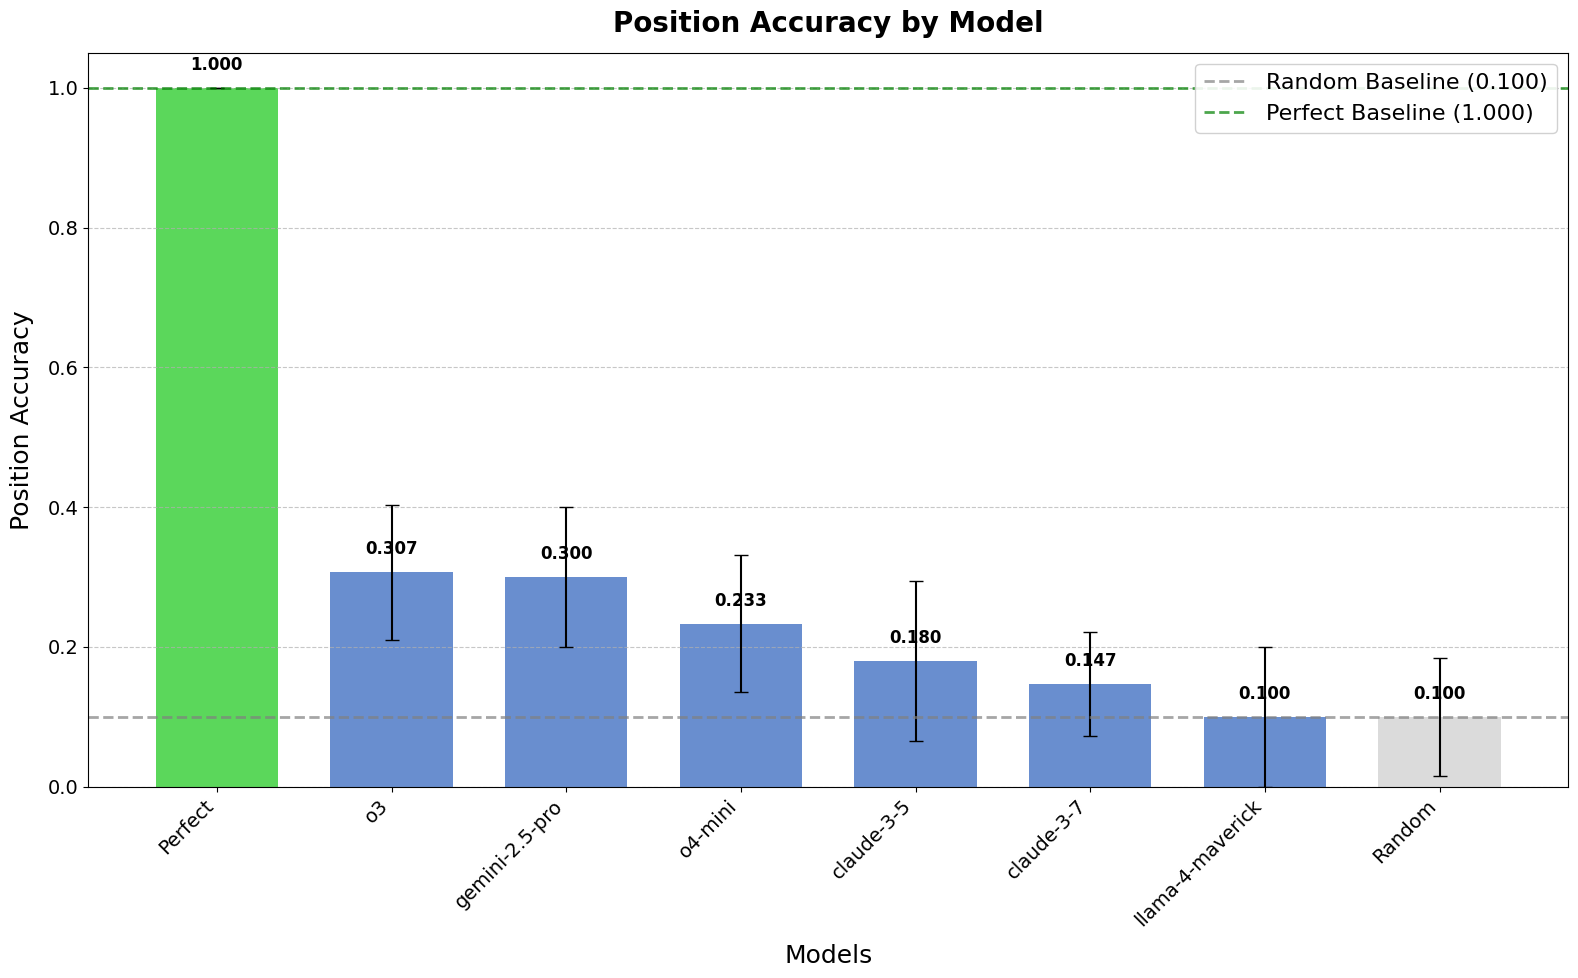

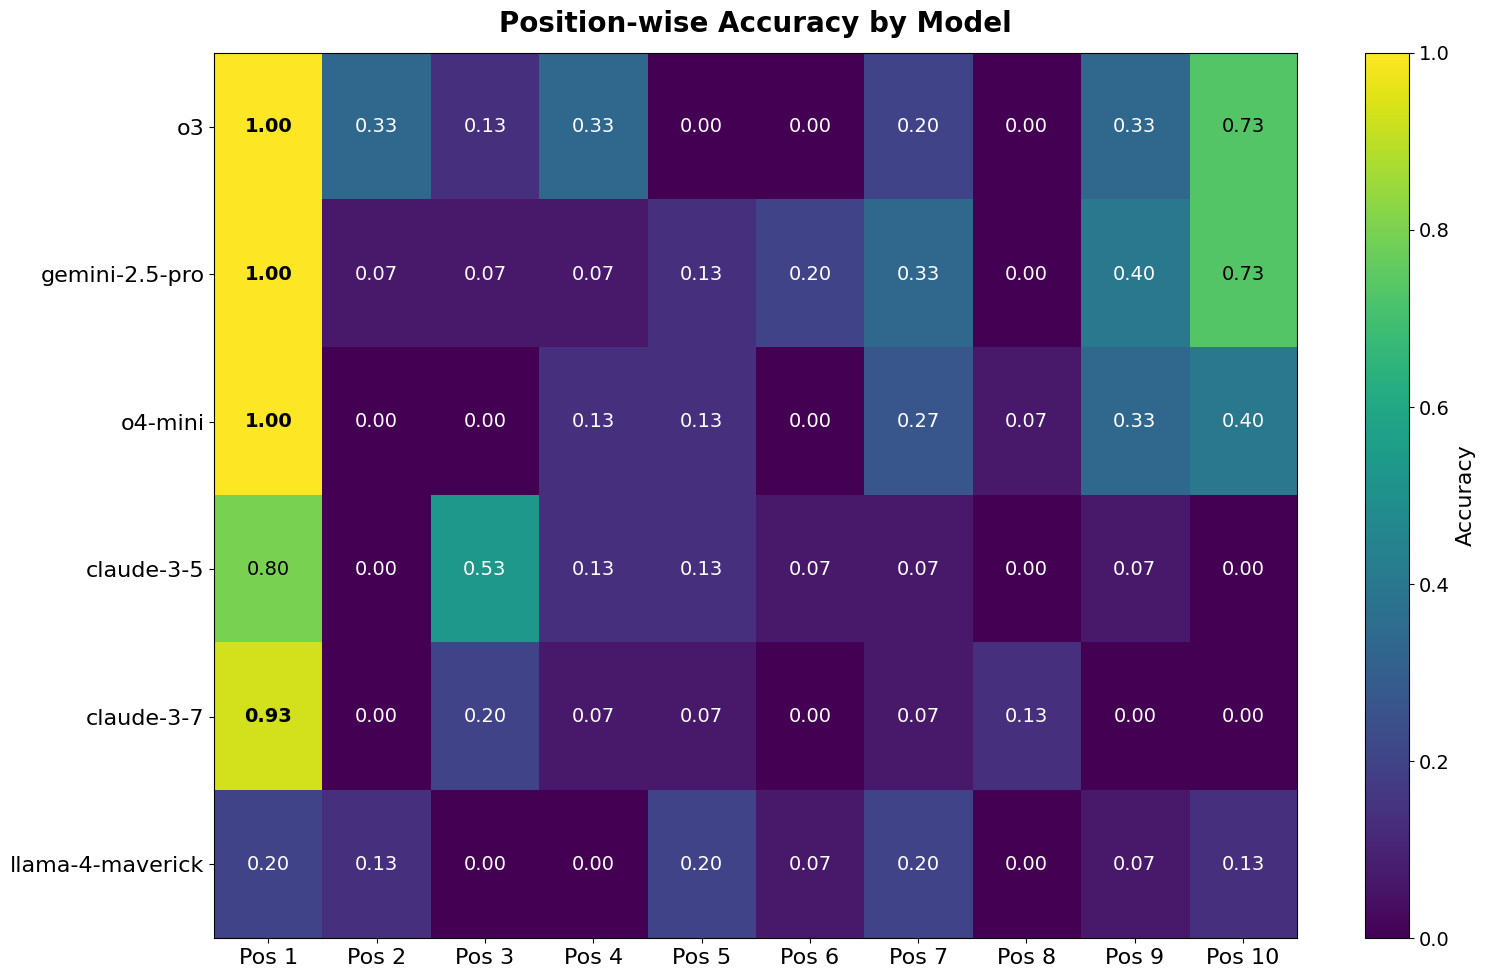

C:\Users\yuxua\AppData\Local\Temp\ipykernel_51840\2235559915.py:180: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pos_df = pd.concat([pos_df, pd.DataFrame([row])], ignore_index=True)


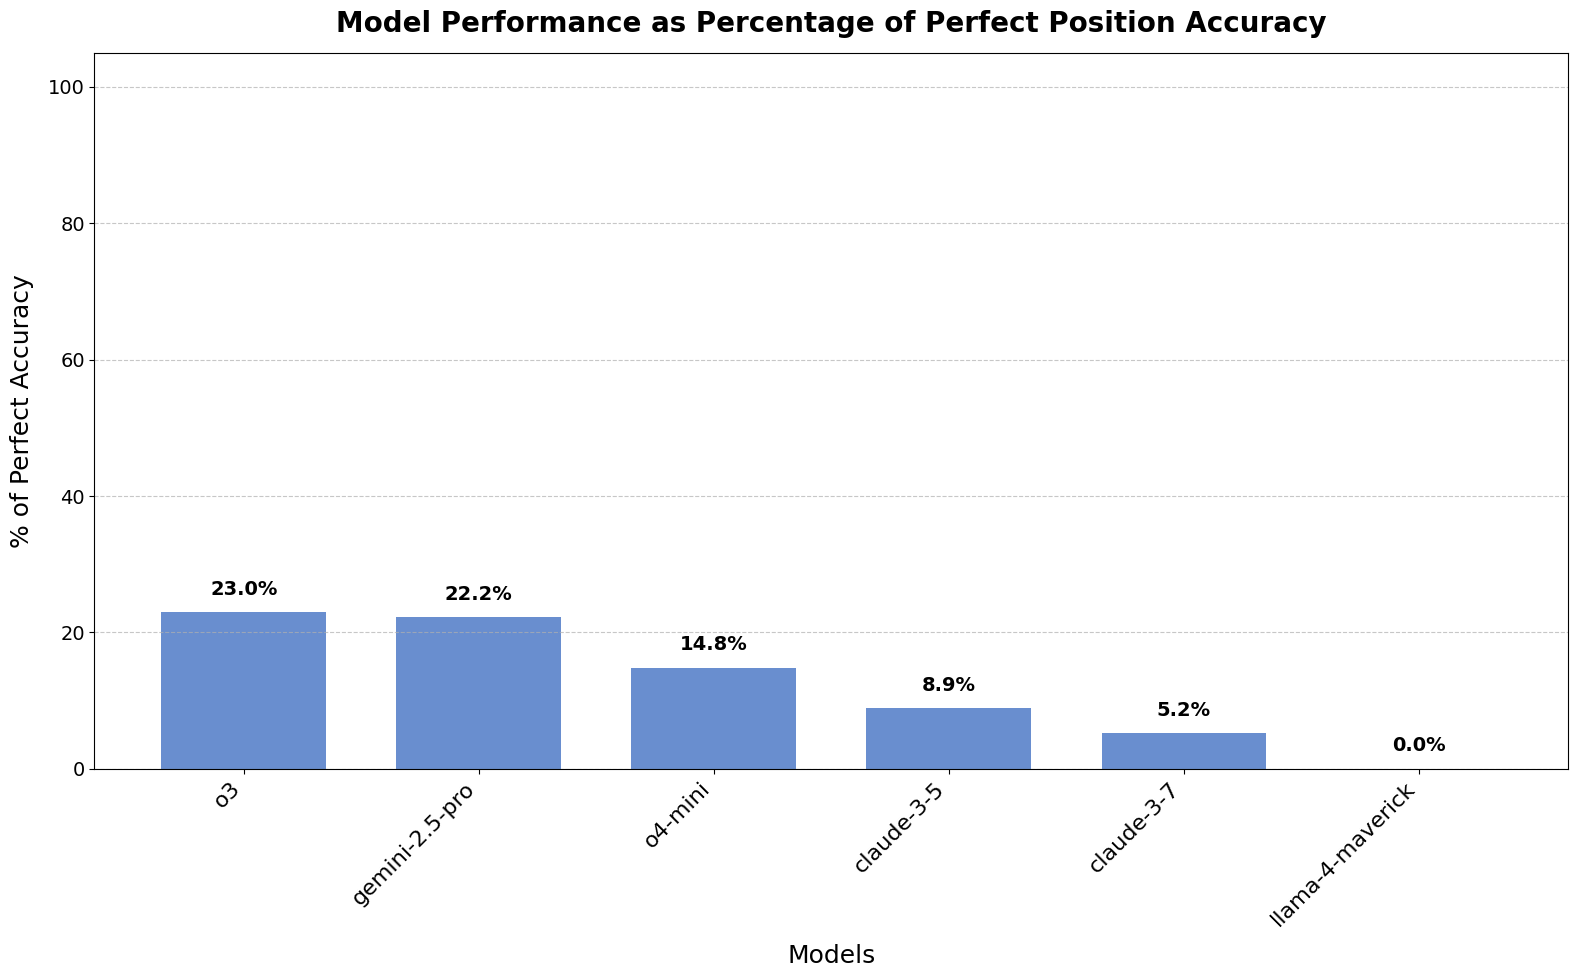


Paper-quality figures saved to:
- position_accuracy_ordered_paper.png
- per_position_accuracy_paper.png
- position_accuracy_normalized_paper.png


In [19]:
def plot_position_accuracy(position_acc, per_position_acc, all_models):
    """
    Create visualizations for position-wise accuracy ordered by accuracy value,
    with larger fonts suitable for inclusion in a paper.
    
    Parameters:
    -----------
    position_acc : dict
        Dictionary mapping model names to lists of overall position accuracy values
    per_position_acc : dict
        Dictionary mapping model names to lists of accuracy values for each position
    all_models : list
        List of model names
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    
    # Set larger font sizes for paper-quality figures
    plt.rcParams.update({
        'font.size': 14,          # Base font size
        'axes.titlesize': 18,     # Title font size
        'axes.labelsize': 16,     # Axis label size
        'xtick.labelsize': 14,    # X tick label size
        'ytick.labelsize': 14,    # Y tick label size
        'legend.fontsize': 14,    # Legend font size
        'figure.titlesize': 20    # Figure title size
    })
    
    # Create DataFrame for overall accuracy
    df = pd.DataFrame({
        'Model': all_models,
        'Mean Accuracy': [np.mean(position_acc[m]) for m in all_models],
        'Std Accuracy': [np.std(position_acc[m], ddof=1) for m in all_models]
    })
    
    # Sort by accuracy (descending)
    df = df.sort_values('Mean Accuracy', ascending=False)
    
    # Create bar chart for overall accuracy
    plt.figure(figsize=(16, 10))  # Larger figure size for better visibility in papers
    
    x = np.arange(len(df))
    colors = []
    
    # Assign colors based on model type
    for model in df['Model']:
        if model == 'Random_Baseline':
            colors.append('lightgray')  # Random baseline in gray
        elif model == 'Perfect_Baseline':
            colors.append('limegreen')  # Perfect baseline in green
        else:
            colors.append('#4472C4')  # Professional blue color for models
    
    bars = plt.bar(x, df['Mean Accuracy'], yerr=df['Std Accuracy'], 
                   alpha=0.8, capsize=5, color=colors, width=0.7)
    
    # Add value labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{height:.3f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # Prepare x-tick labels with requested shorter format
    short_names = []
    for model in df['Model']:
        if model == 'Random_Baseline':
            short_names.append('Random')
        elif model == 'Perfect_Baseline':
            short_names.append('Perfect')
        elif "o3-2025-04-16" in model:
            short_names.append("o3")
        elif "claude-3-7" in model:
            short_names.append("claude-3-7")
        elif "claude-3-5" in model:
            short_names.append("claude-3-5")
        elif "o4-mini" in model:
            short_names.append("o4-mini")
        elif "gemini-2.5-pro" in model:
            short_names.append("gemini-2.5-pro")
        elif "Llama-4-Maverick" in model:
            short_names.append("llama-4-maverick")
        else:
            # Fallback for any other models
            if "claude" in model.lower():
                short_names.append(f"claude-{model.split('-')[2]}")
            elif "llama" in model.lower():
                short_names.append("llama-4")
            elif "o4" in model.lower():
                short_names.append("o4-mini")
            elif "o3" in model.lower():
                short_names.append("o3")
            elif "gemini" in model.lower():
                short_names.append("gemini")
            else:
                short_names.append(model.split('-')[0])
    
    plt.xticks(x, short_names, rotation=45, ha='right')
    plt.title("Position Accuracy by Model", fontsize=20, fontweight='bold', pad=15)
    plt.ylabel("Position Accuracy", fontsize=18, labelpad=10)
    plt.xlabel("Models", fontsize=18, labelpad=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, 1.05)  # Accuracy is between 0 and 1
    
    # Add horizontal lines for baselines with larger line width
    if 'Random_Baseline' in df['Model'].values and 'Perfect_Baseline' in df['Model'].values:
        random_baseline_val = df[df['Model'] == 'Random_Baseline']['Mean Accuracy'].values[0]
        perfect_baseline_val = df[df['Model'] == 'Perfect_Baseline']['Mean Accuracy'].values[0]
        
        plt.axhline(y=random_baseline_val, color='gray', linestyle='--', alpha=0.7, linewidth=2,
                   label=f'Random Baseline ({random_baseline_val:.3f})')
        plt.axhline(y=perfect_baseline_val, color='green', linestyle='--', alpha=0.7, linewidth=2,
                   label=f'Perfect Baseline ({perfect_baseline_val:.3f})')
        
        # Move legend to upper right corner with larger font
        plt.legend(loc='upper right', fontsize=16, framealpha=0.9)
    
    plt.tight_layout()
    plt.savefig('position_accuracy_ordered_paper.png', dpi=600, bbox_inches='tight')  # Higher DPI for paper quality
    plt.show()
    
    # Create heatmap for per-position accuracy (excluding baselines for clarity)
    real_models = [m for m in df['Model'] if m not in ['Random_Baseline', 'Perfect_Baseline']]
    real_models_df = df[df['Model'].isin(real_models)]
    
    plt.figure(figsize=(16, 10))
    
    # Create per-position accuracy matrix
    position_matrix = []
    model_labels = []
    for model in real_models_df['Model']:
        position_means = [np.mean(per_position_acc[model][i]) for i in range(10)]
        position_matrix.append(position_means)
        
        # Get short name for this model
        idx = df['Model'].tolist().index(model)
        model_labels.append(short_names[idx])
    
    # Plot heatmap
    plt.imshow(position_matrix, cmap='viridis', aspect='auto', vmin=0, vmax=1)
    cbar = plt.colorbar(label='Accuracy')
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label('Accuracy', size=16)
    
    # Add labels with larger font
    plt.yticks(np.arange(len(model_labels)), model_labels, fontsize=16)
    plt.xticks(np.arange(10), [f"Pos {i+1}" for i in range(10)], fontsize=16)
    plt.title("Position-wise Accuracy by Model", fontsize=20, fontweight='bold', pad=15)
    
    # Add text annotations with adaptive coloring
    for i in range(len(model_labels)):
        for j in range(10):
            value = position_matrix[i][j]
            color = "white" if value < 0.7 else "black"
            weight = "bold" if value > 0.8 else "normal"
            plt.text(j, i, f"{value:.2f}", 
                     ha="center", va="center", color=color, 
                     fontsize=14, fontweight=weight)
    
    plt.tight_layout()
    plt.savefig('per_position_accuracy_paper.png', dpi=600, bbox_inches='tight')
    plt.show()
    
    # Calculate improvement metrics
    if 'Random_Baseline' in df['Model'].values and 'Perfect_Baseline' in df['Model'].values:
        random_baseline_val = df[df['Model'] == 'Random_Baseline']['Mean Accuracy'].values[0]
        perfect_baseline_val = df[df['Model'] == 'Perfect_Baseline']['Mean Accuracy'].values[0]
        
        df['Improvement_Over_Random'] = df['Mean Accuracy'] - random_baseline_val
        df['Percent_Of_Perfect'] = (df['Mean Accuracy'] - random_baseline_val) / (perfect_baseline_val - random_baseline_val) * 100
    
    # Save summary to CSV
    pos_cols = [f'Position {i+1}' for i in range(10)]
    pos_df = pd.DataFrame(columns=['Model'] + pos_cols)
    
    for model in df['Model']:
        row = {'Model': model}
        for j in range(10):
            row[f'Position {j+1}'] = np.mean(per_position_acc[model][j])
        pos_df = pd.concat([pos_df, pd.DataFrame([row])], ignore_index=True)
    
    # Save results
    df.to_csv('position_accuracy_summary.csv', index=False)
    pos_df.to_csv('per_position_accuracy.csv', index=False)
    
    # Create normalized performance visualization (excluding baselines)
    if 'Percent_Of_Perfect' in df.columns:
        model_df = df[~df['Model'].isin(['Random_Baseline', 'Perfect_Baseline'])]
        model_df = model_df.sort_values('Percent_Of_Perfect', ascending=False)
        
        plt.figure(figsize=(16, 10))
        
        x = np.arange(len(model_df))
        bars = plt.bar(x, model_df['Percent_Of_Perfect'], alpha=0.8, color='#4472C4', width=0.7)
        
        # Add value labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 2,
                     f'{height:.1f}%', ha='center', va='bottom', fontsize=14, fontweight='bold')
        
        # Get short names for models
        model_short_names = []
        for model in model_df['Model']:
            idx = df['Model'].tolist().index(model)
            model_short_names.append(short_names[idx])
        
        plt.xticks(x, model_short_names, rotation=45, ha='right', fontsize=16)
        plt.title('Model Performance as Percentage of Perfect Position Accuracy', 
                 fontsize=20, fontweight='bold', pad=15)
        plt.ylabel('% of Perfect Accuracy', fontsize=18, labelpad=10)
        plt.xlabel('Models', fontsize=18, labelpad=10)
        plt.ylim(0, 105)  # Give a little more room for labels
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.savefig('position_accuracy_normalized_paper.png', dpi=600, bbox_inches='tight')
        plt.show()
    
    print("\nPaper-quality figures saved to:")
    print("- position_accuracy_ordered_paper.png")
    print("- per_position_accuracy_paper.png")
    if 'Percent_Of_Perfect' in df.columns:
        print("- position_accuracy_normalized_paper.png")
    
    return df, pos_df

# Example usage:
if __name__ == "__main__":
    gt_file = "SMB_IMG/ground_truth_1-1.json"
    result_files = [
        "SMB_IMG/accuracy_results_1-1.json",
        "SMB_IMG/accuracy_results_1-1_2.json",
        "SMB_IMG/accuracy_results_1-1_3.json"
    ]
    
    # Calculate position accuracy with 15 random baselines and 1 perfect baseline
    position_acc, per_position_acc, summary_df = calculate_position_accuracy(
        gt_file, 
        result_files, 
        add_baselines=True, 
        num_random_baselines=15, 
        seed=42
    )
    
    # Create visualizations ordered by accuracy (not by rank)
    acc_df, pos_df = plot_position_accuracy(
        position_acc, 
        per_position_acc, 
        summary_df['Model'].tolist()
    )

In [10]:
rbo.RankingSimilarity([1,2,3,4,5,6,7,8,9,10], [1,2,3,4,5,6,7,8,9,10]).rbo()

1.0

In [10]:
rbo.RankingSimilarity([1,2,3,4,5,6,7,8,9,10], [1,2,3,4,5,6,7,8,9,10]).rbo(p=0.9)

0.6513215598999998

In [24]:
import random

# Define the ground truth
ground_truth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
num_samples = len(ground_truth)
num_runs = 15
accuracies = []

# Range of values for random sampling (1 to 10 based on ground_truth values)
min_value = min(ground_truth)
max_value = max(ground_truth)

# Set the seed *outside* the loop for reproducibility of the entire sequence
random.seed(42)

for run_num in range(num_runs):
    # Generate random samples of the same length as ground_truth
    # Since the seed is set outside the loop, each iteration will produce a different sequence
    random_samples = [random.randint(min_value, max_value) for _ in range(num_samples)]

    # Calculate position-wise accuracy
    correct_predictions = sum(1 for gt, rs in zip(ground_truth, random_samples) if gt == rs)
    accuracy = correct_predictions / num_samples if num_samples > 0 else 0
    accuracies.append(accuracy)

    print(f"Run {run_num + 1}: Random Samples: {random_samples}, Accuracy: {accuracy:.2f}")


# Calculate the average accuracy
average_accuracy = sum(accuracies) / num_runs if num_runs > 0 else 0

print(f"\nGround Truth: {ground_truth}")
print(f"Number of runs: {num_runs}")
print(f"All individual accuracies: {accuracies}")
print(f"Average position-wise accuracy over {num_runs} runs: {average_accuracy:.2f}")

Run 1: Random Samples: [2, 1, 5, 4, 4, 3, 2, 9, 2, 10], Accuracy: 0.20
Run 2: Random Samples: [7, 1, 1, 2, 4, 4, 9, 10, 1, 9], Accuracy: 0.00
Run 3: Random Samples: [4, 9, 7, 4, 8, 10, 5, 1, 3, 7], Accuracy: 0.10
Run 4: Random Samples: [6, 5, 3, 4, 6, 2, 2, 7, 2, 6], Accuracy: 0.20
Run 5: Random Samples: [6, 10, 5, 1, 8, 9, 2, 7, 2, 9], Accuracy: 0.00
Run 6: Random Samples: [5, 10, 6, 10, 4, 2, 1, 4, 5, 2], Accuracy: 0.00
Run 7: Random Samples: [4, 2, 7, 5, 8, 6, 3, 6, 6, 4], Accuracy: 0.20
Run 8: Random Samples: [5, 2, 10, 3, 9, 4, 3, 8, 7, 5], Accuracy: 0.20
Run 9: Random Samples: [9, 4, 6, 1, 4, 1, 6, 7, 5, 2], Accuracy: 0.00
Run 10: Random Samples: [4, 10, 6, 4, 8, 7, 8, 3, 5, 3], Accuracy: 0.10
Run 11: Random Samples: [4, 9, 9, 5, 10, 7, 10, 7, 6, 4], Accuracy: 0.00
Run 12: Random Samples: [3, 9, 8, 2, 1, 2, 3, 3, 7, 10], Accuracy: 0.10
Run 13: Random Samples: [2, 7, 7, 10, 8, 9, 5, 9, 1, 2], Accuracy: 0.00
Run 14: Random Samples: [9, 5, 6, 2, 5, 7, 3, 8, 1, 5], Accuracy: 0.20
Run